In [1]:
import sys
import wrapper_pkg

frames = 50
steps = 40000
save_every = steps // frames
grid_params = wrapper_pkg.DimParams(n=[100,50,5], d=1e-9)
time_params = wrapper_pkg.DimParams(d=1e-14, n=steps)

p_sets = [{"A":1e-11, "K":0, "Hmag":0}, {"A":0, "K":1e5, "Hmag":0}, {"A":0, "K":0, "Hmag":1e5}, {"A":1e-11, "K":1e5, "Hmag":1e5}]
params = [dict(p, **{"Ms":8e5, "e":[1,0,0], "Hdir":[0,0,1], "alpha":0.8}) for p in p_sets]
sims_classes = [wrapper_pkg.OommfSim, wrapper_pkg.OpenSbliSim, wrapper_pkg.DevitoSim]#, wrapper_pkg.NumpySim]

completed_sims = {}
for param in params:
    sim_params = wrapper_pkg.SimParams(**param)    
    print("\n", sim_params.terms, file=sys.stderr)
    pars = " + ".join(sim_params.terms)
    completed_sims[pars] = []
    for sim_class in sims_classes:
        print("\n" + sim_class.framework_name, file=sys.stderr)             
        try:
            sim = sim_class(sim_params, grid_params, time_params, save_every=save_every, periodic_boundary=True, print_params=False)
            sim.init_flower()
            #sim.init_vortex()
            #sim.init_disc()
            #sim.init_vector((0,0,1))
            sim.run()
        except (Exception) as e:
            print(e, file=sys.stderr)
        else:
            completed_sims[pars].append(sim)

Found translator module:  <module 'ops_translator.c.ops' from '/opt/conda/lib/python3.6/site-packages/ops_translator/c/ops.py'>


/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)

 ['Exchange']

OOMMF
Initialising simulation ...
Generated step kernel: 0.01 s
Running simulation ...
100% (50 of 50) |#########################| Elapsed Time: 0:01:03 Time: 0:01:03
Simulation Complete: 40000 steps, 51 frames, 63.56 s

OpenSBLI
Initialising simulation ...
2017-09-20 10:02:02 : problem : INFO : Expanding equations...
2017-09-20 10:02:02 : problem : DEBUG : The time taken for tensor expansion of equations in 3 Dimensions is 0.28 seconds.
2017-09-20 10:02:02 : opsc : DEBUG : Translating OPSC code...
Generated step kernel: 1.07 s
Running simulation ...
Simulation Complete: 40000 steps, 51 frames, 138.00 s

Devito
Initialising simulation ...
Solving LLG

OOMMF
testing_40000/OOMMF_Exchange


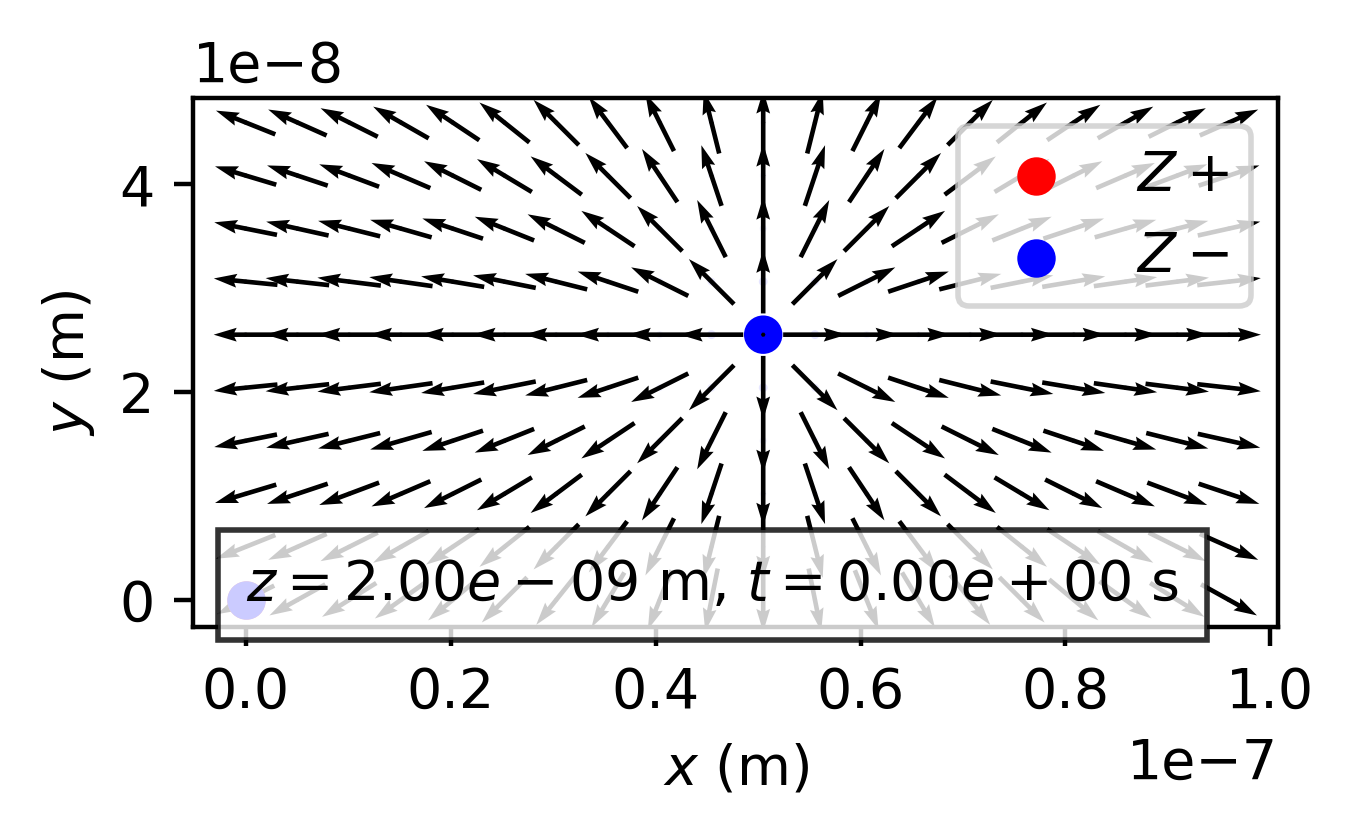

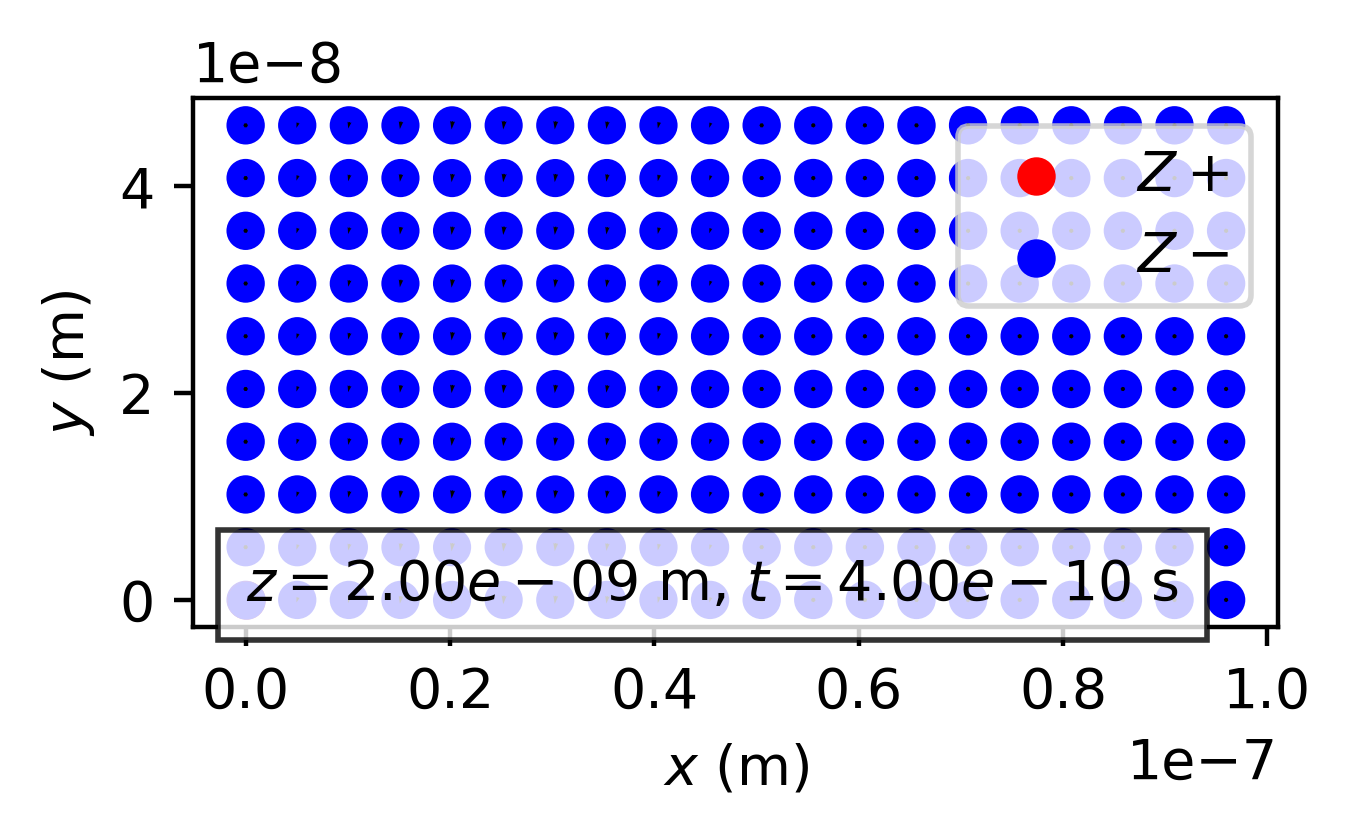

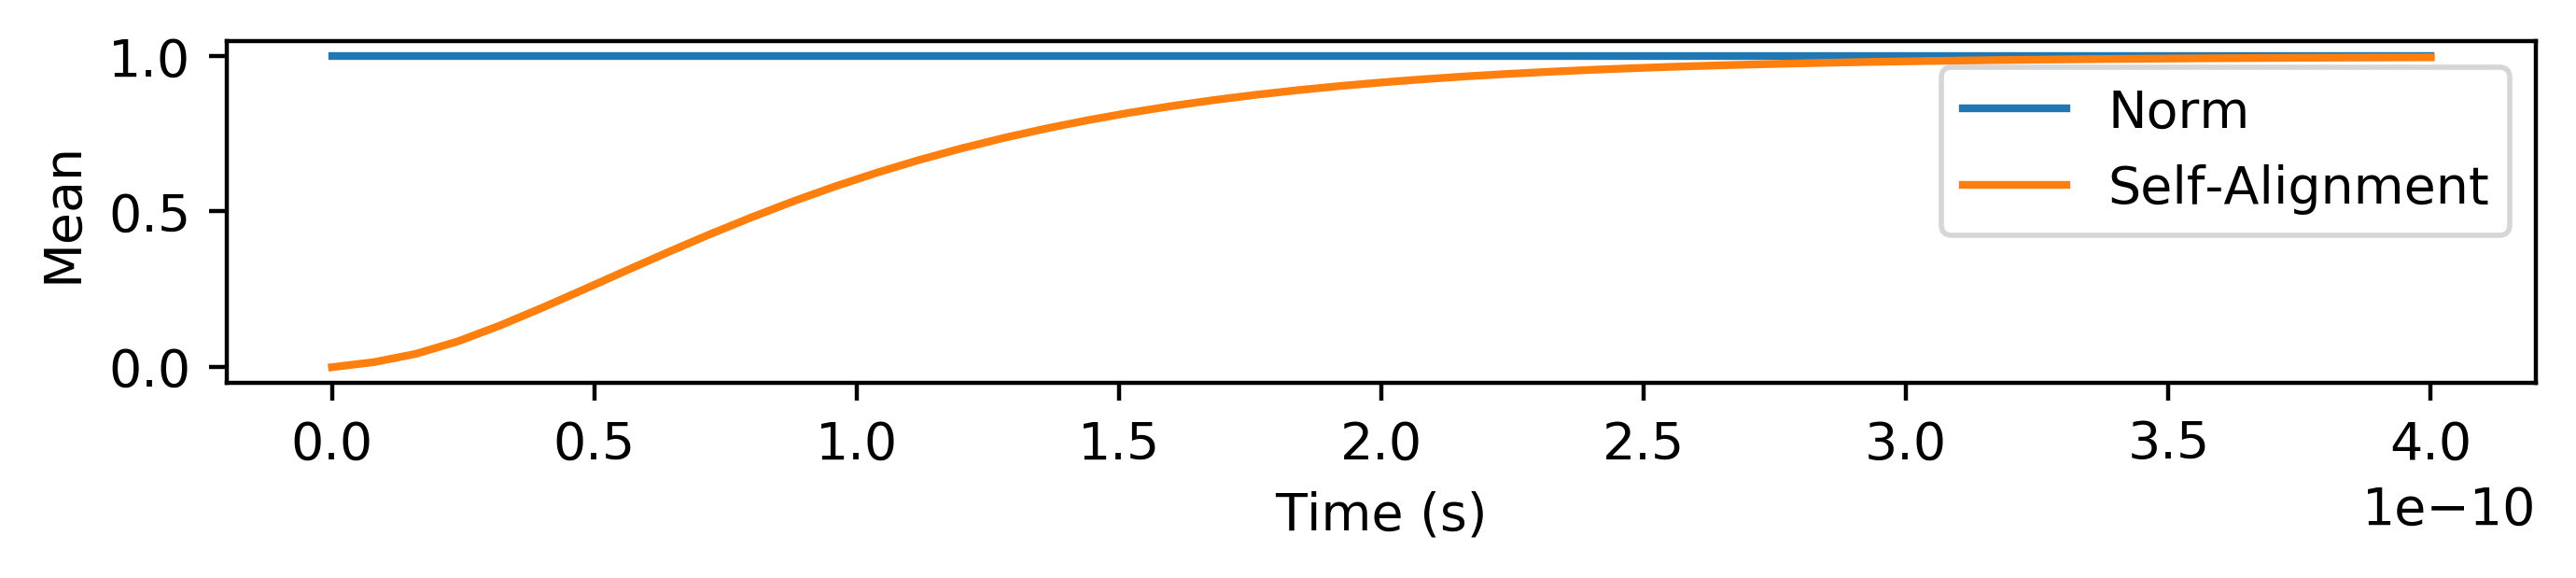

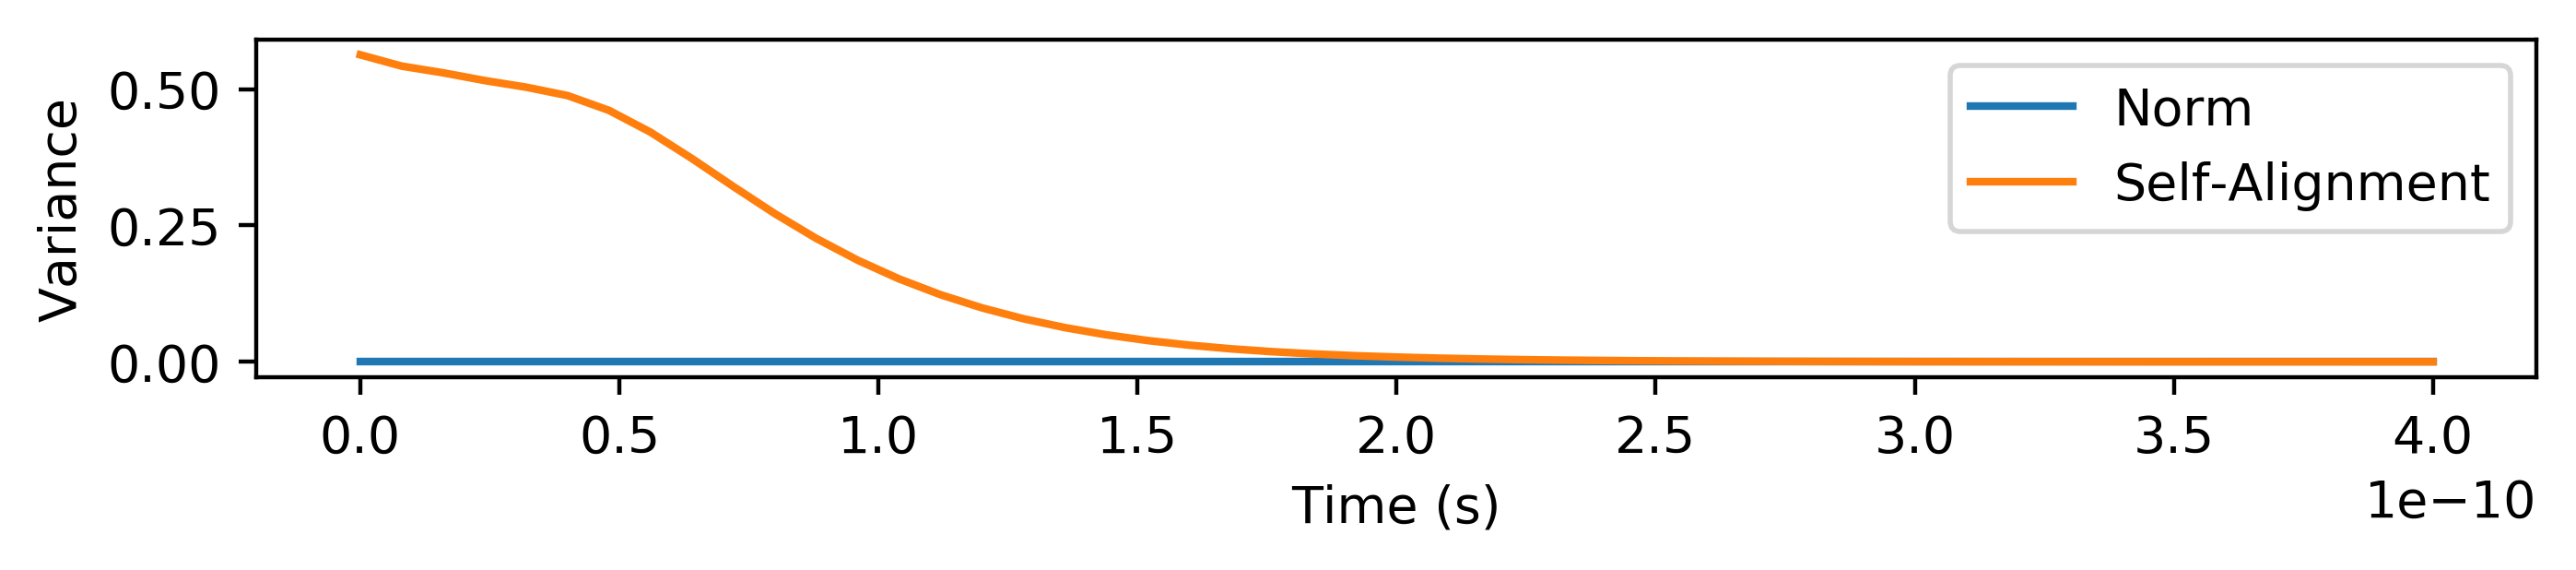

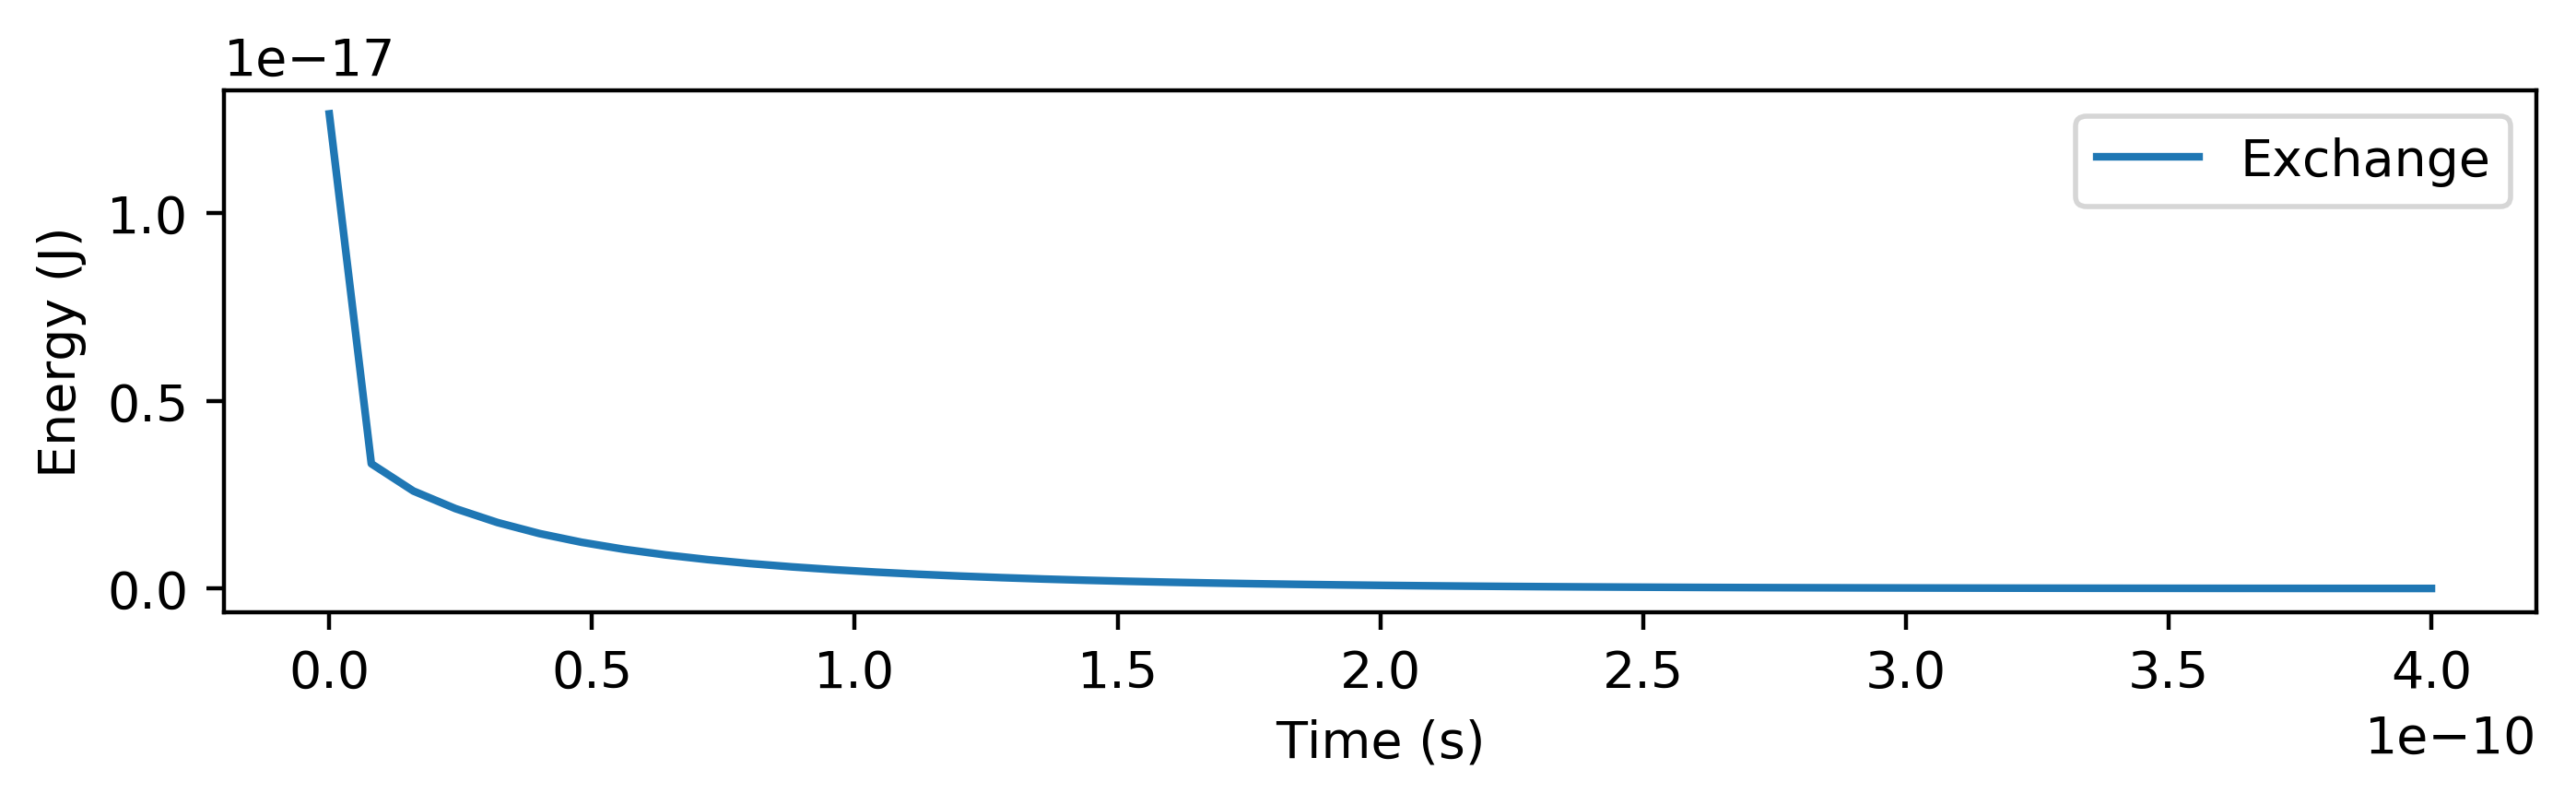

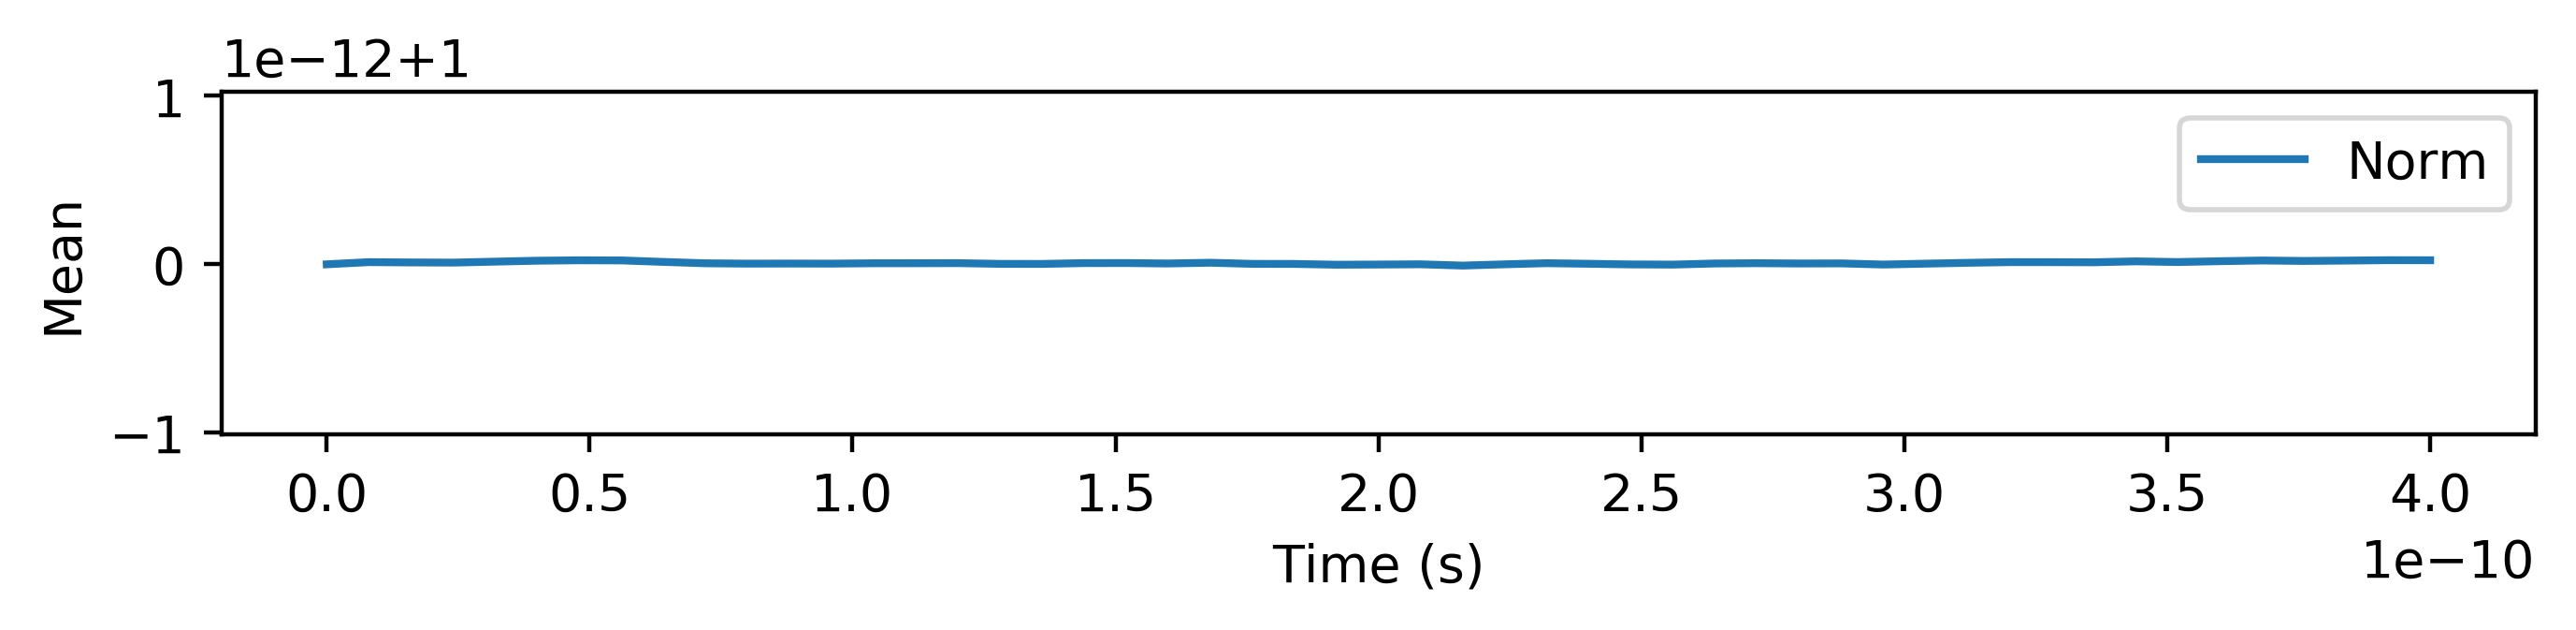

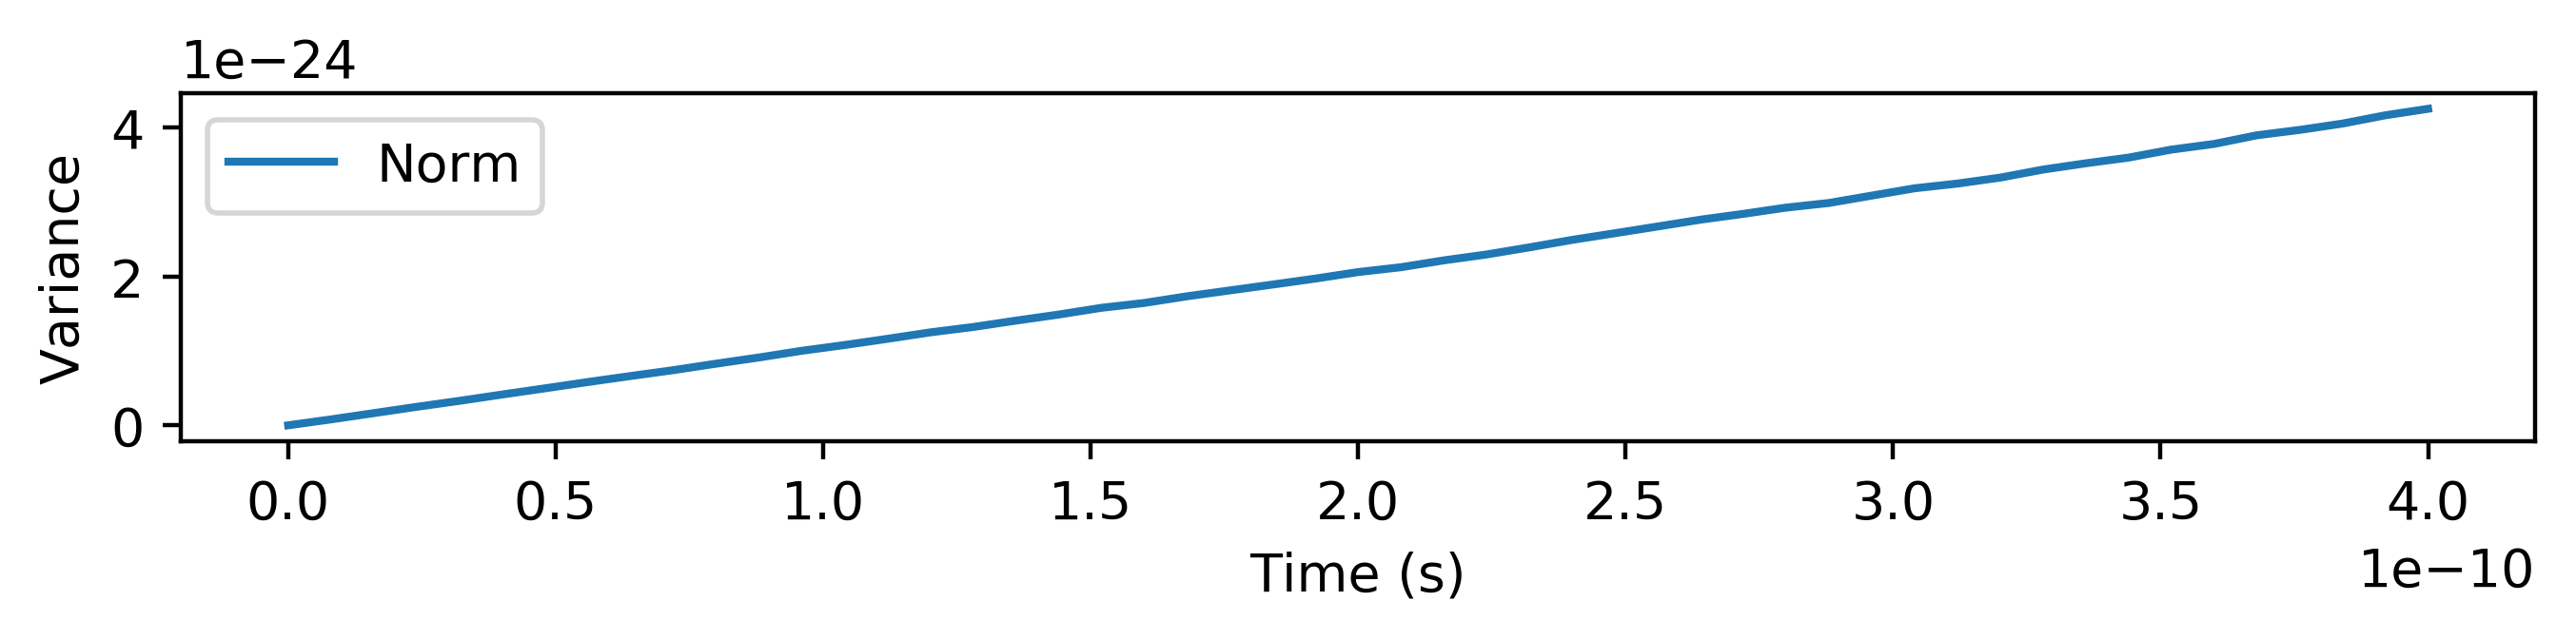

OpenSBLI
testing_40000/OpenSBLI_Exchange


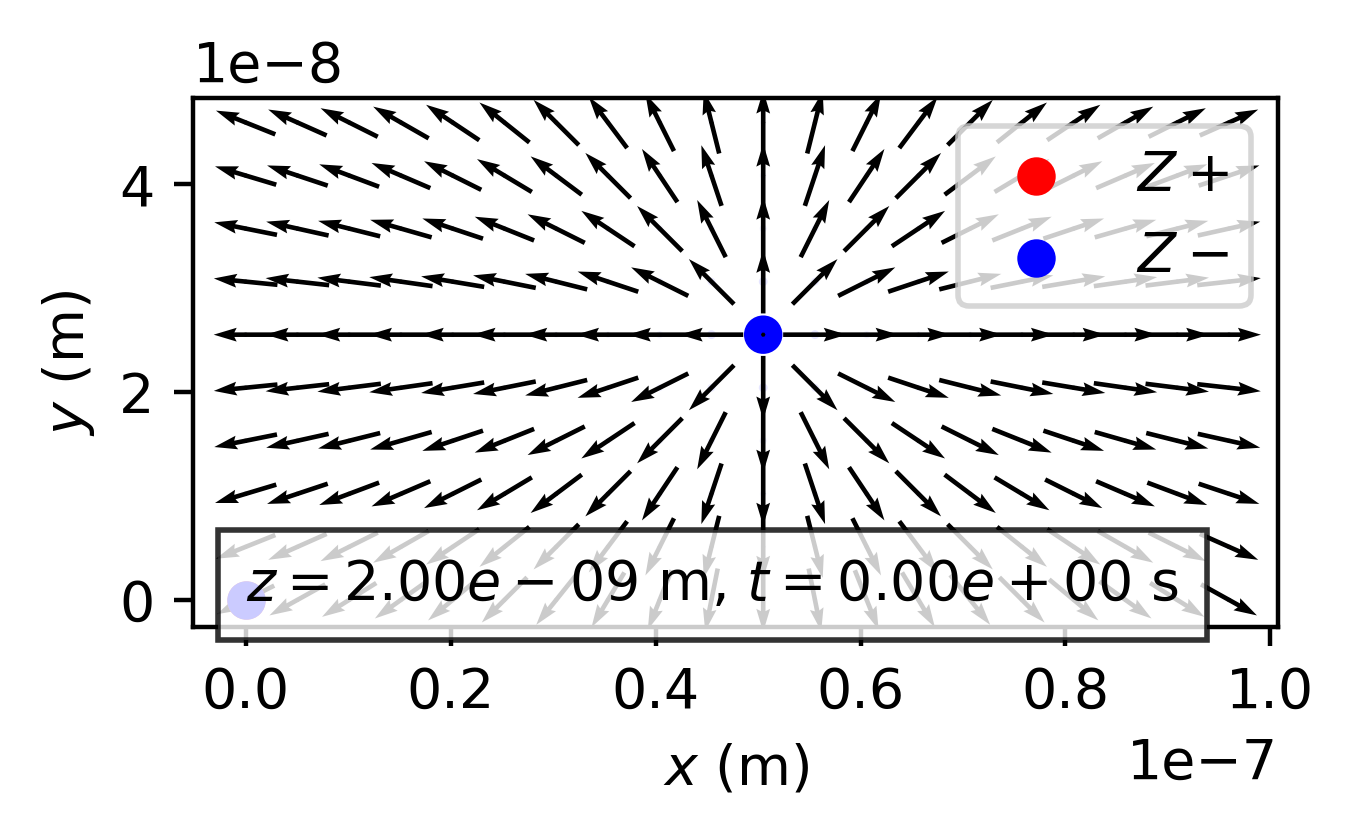

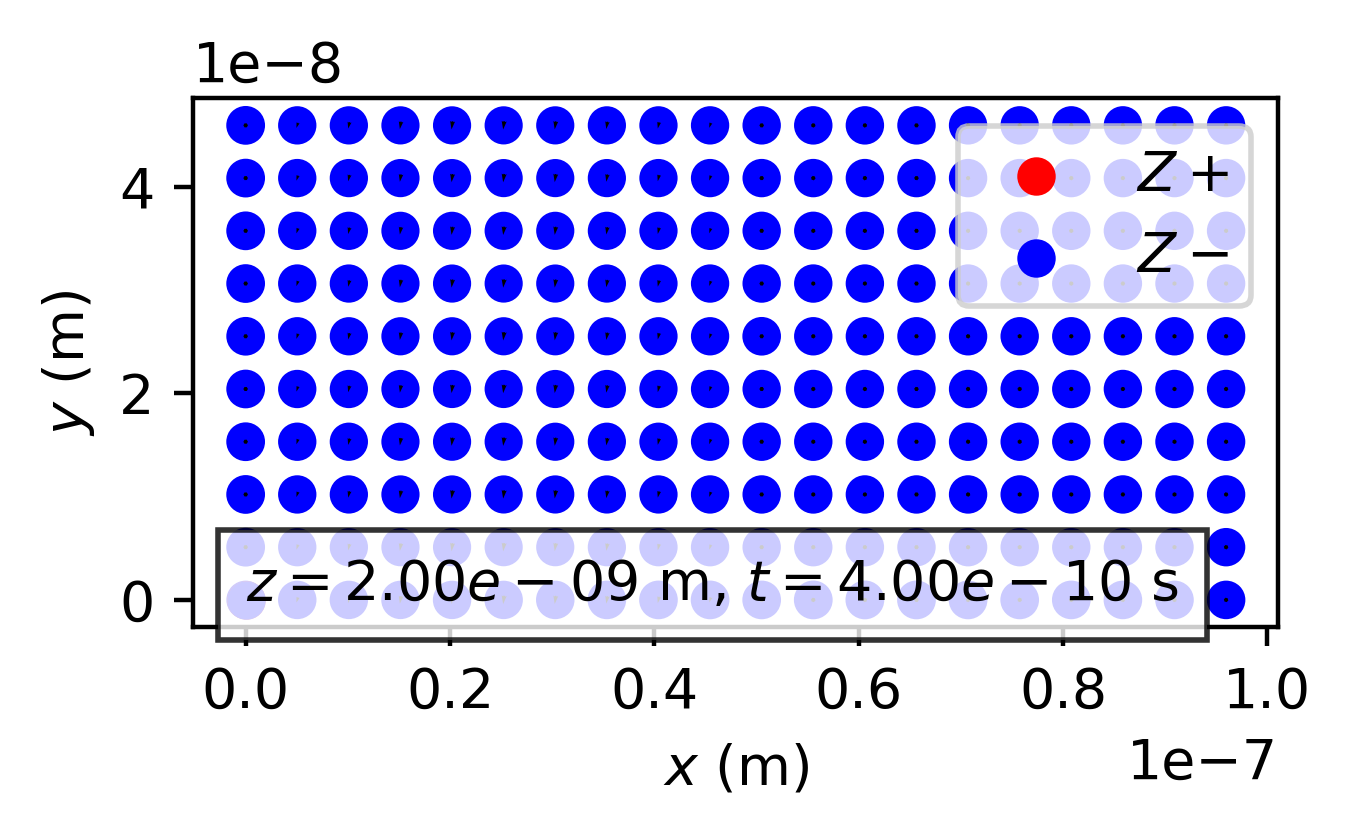

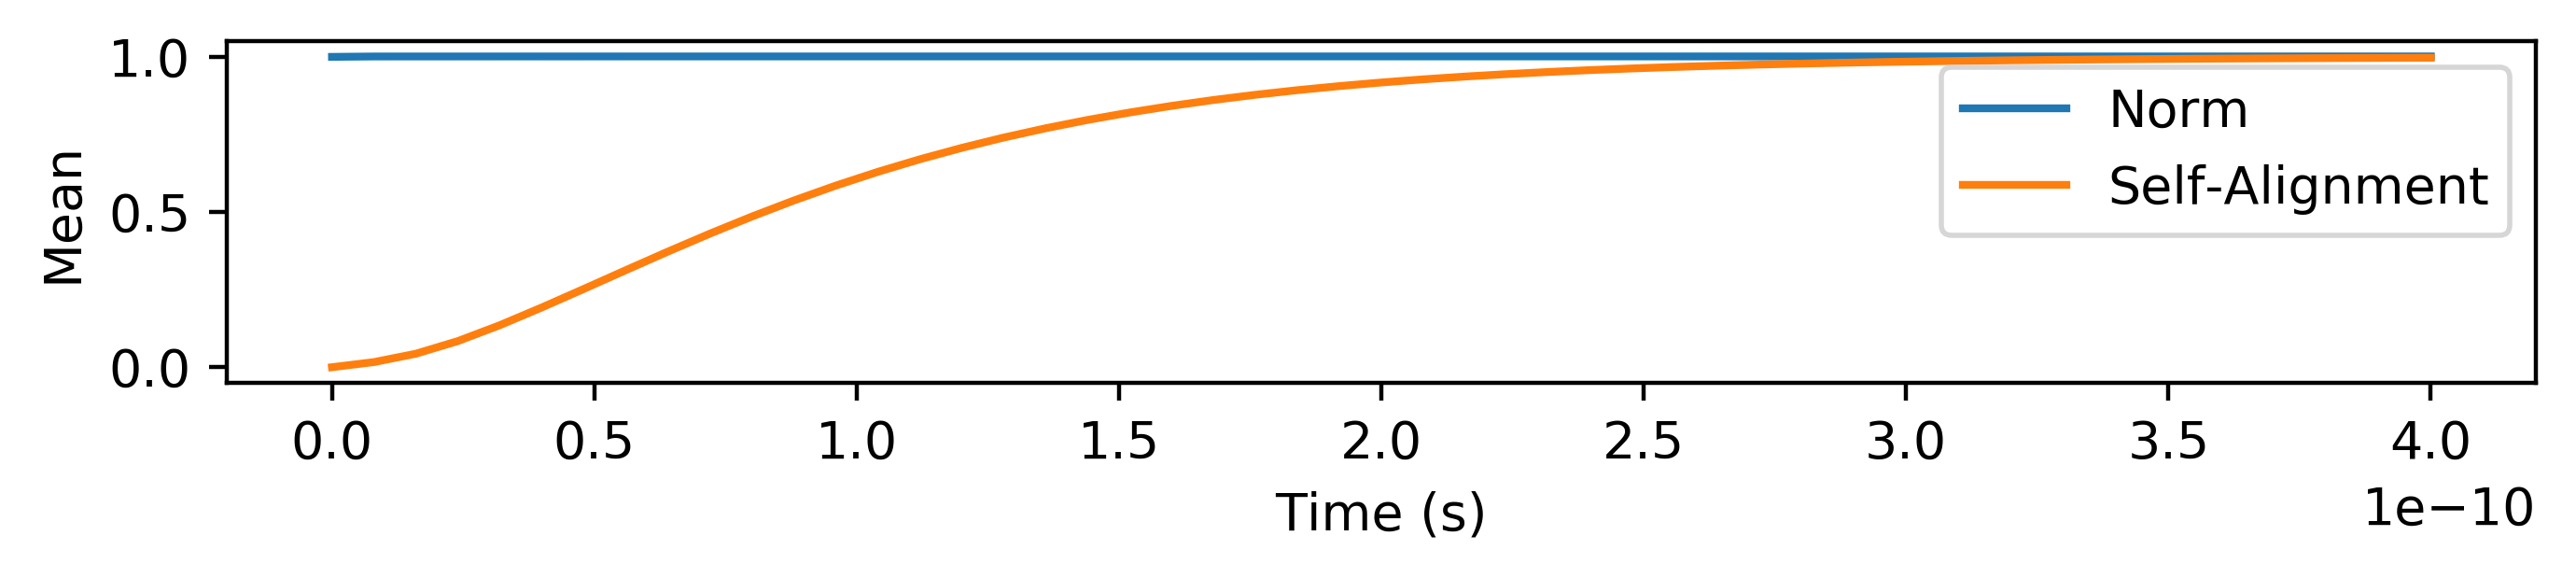

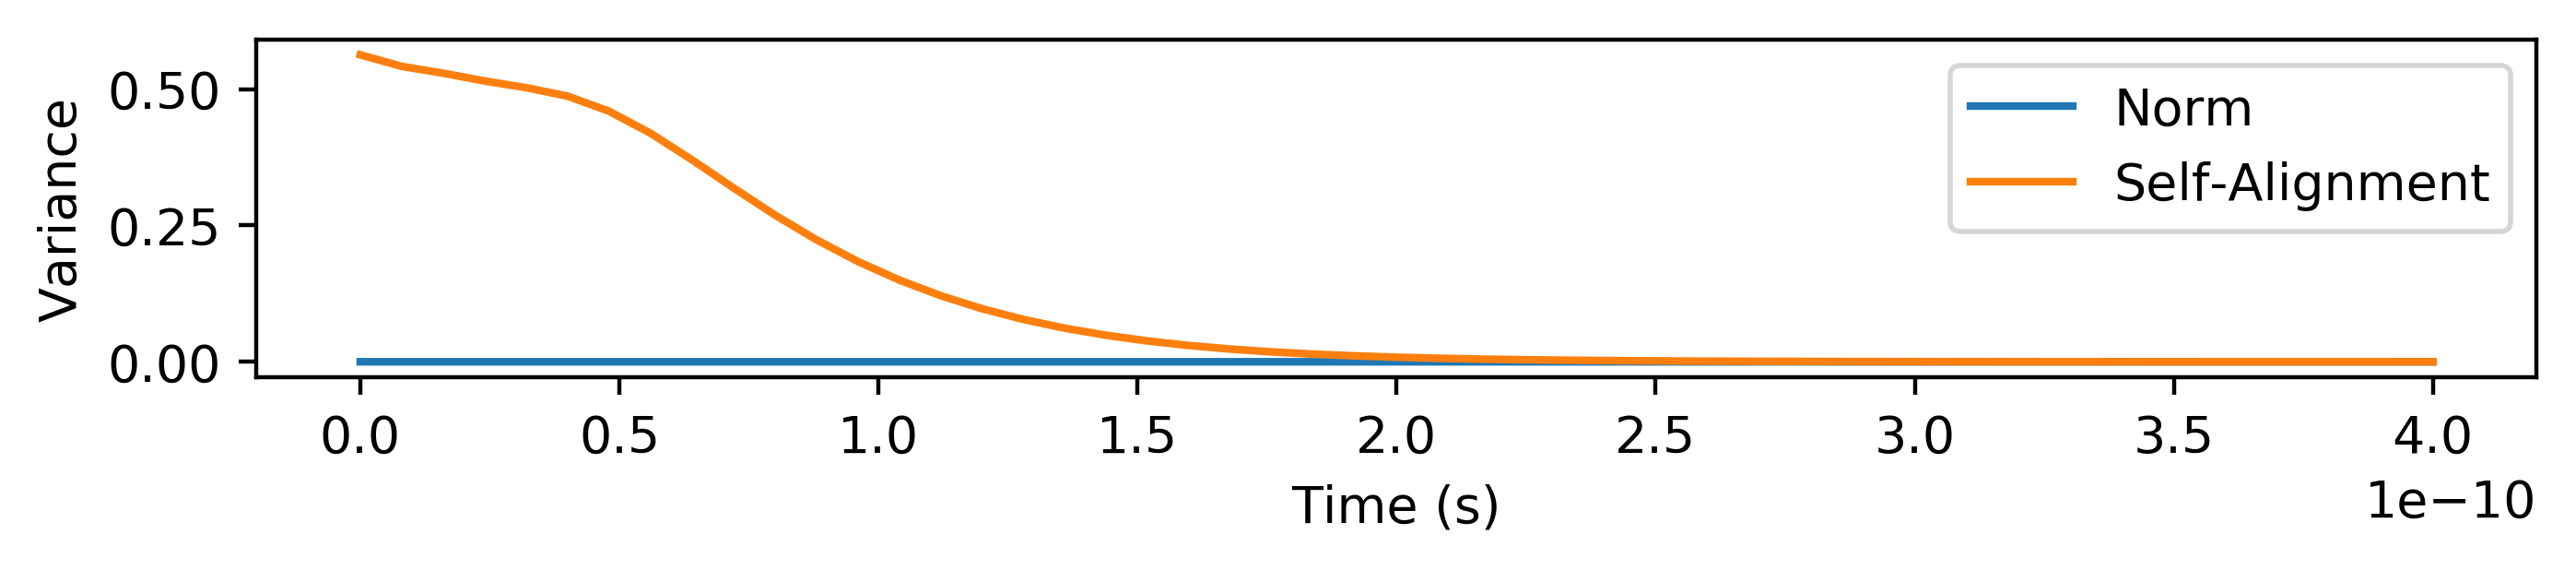

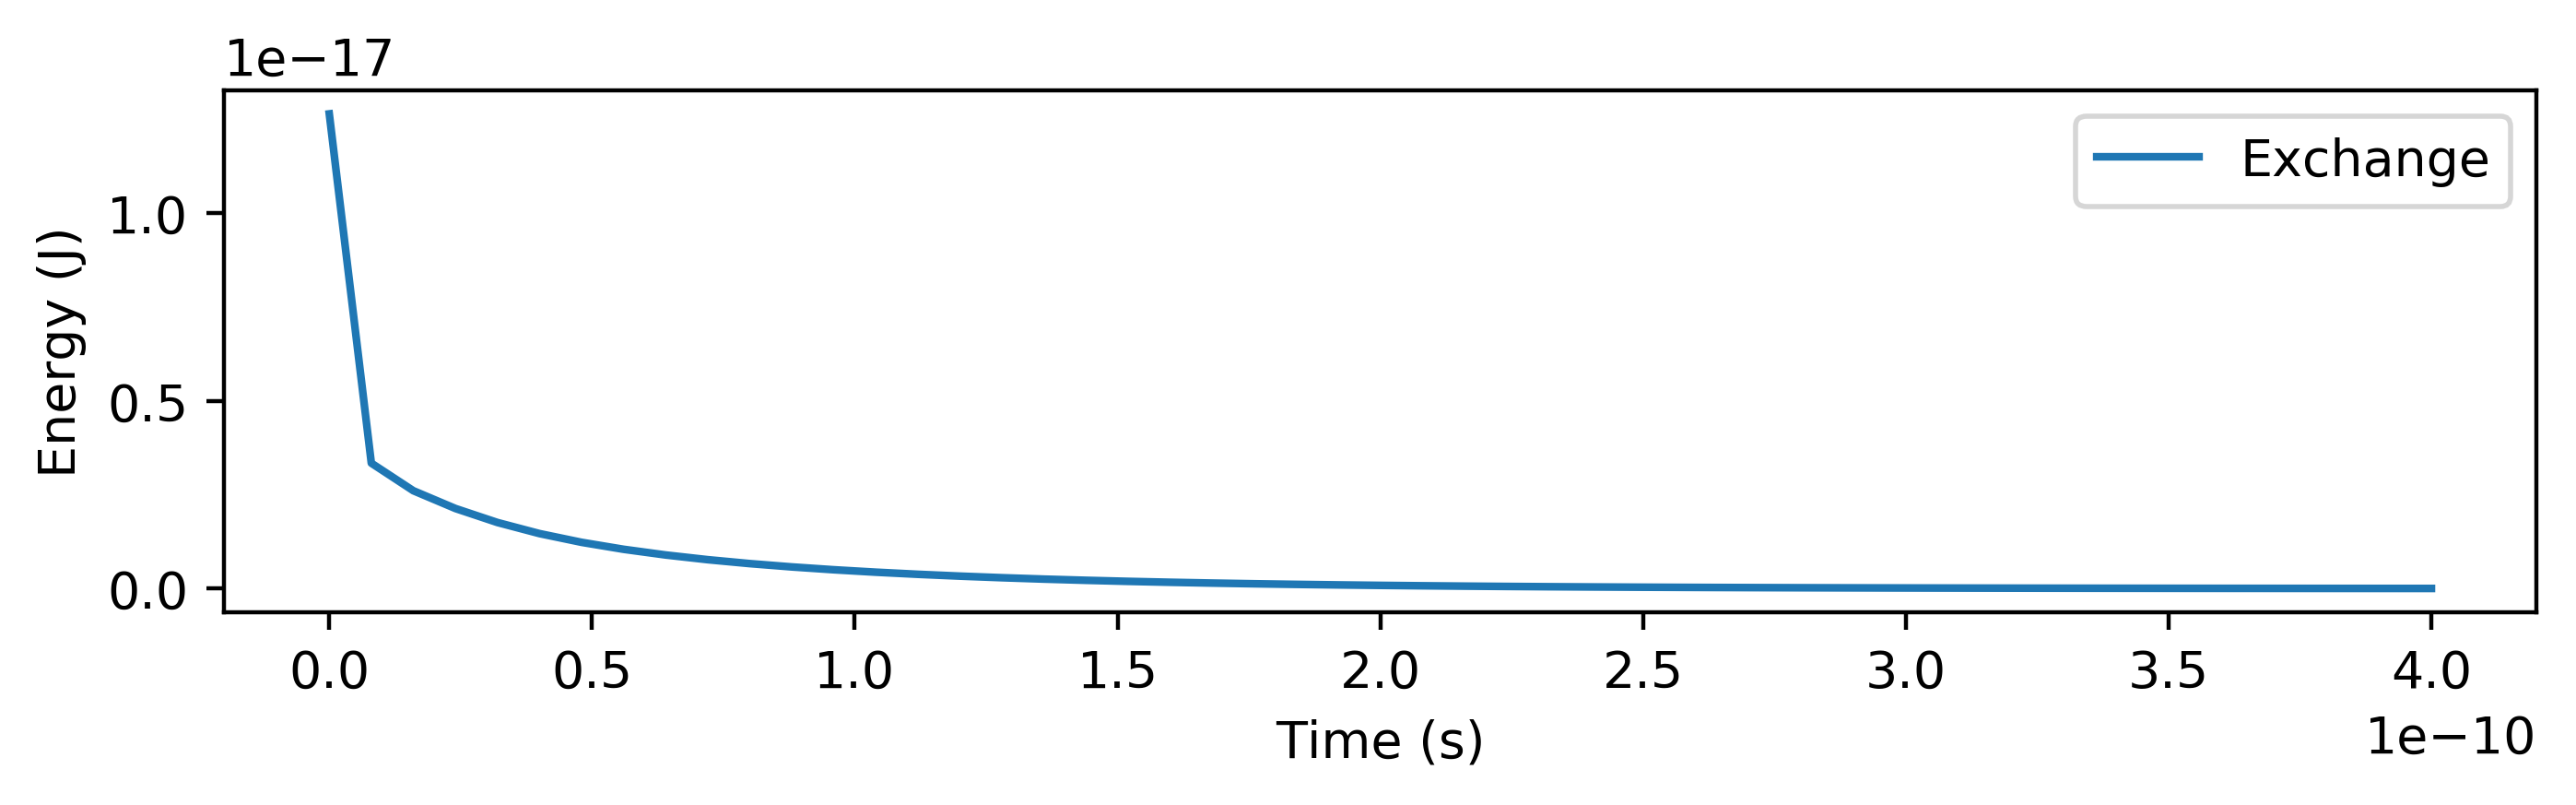

Devito
testing_40000/Devito_Exchange


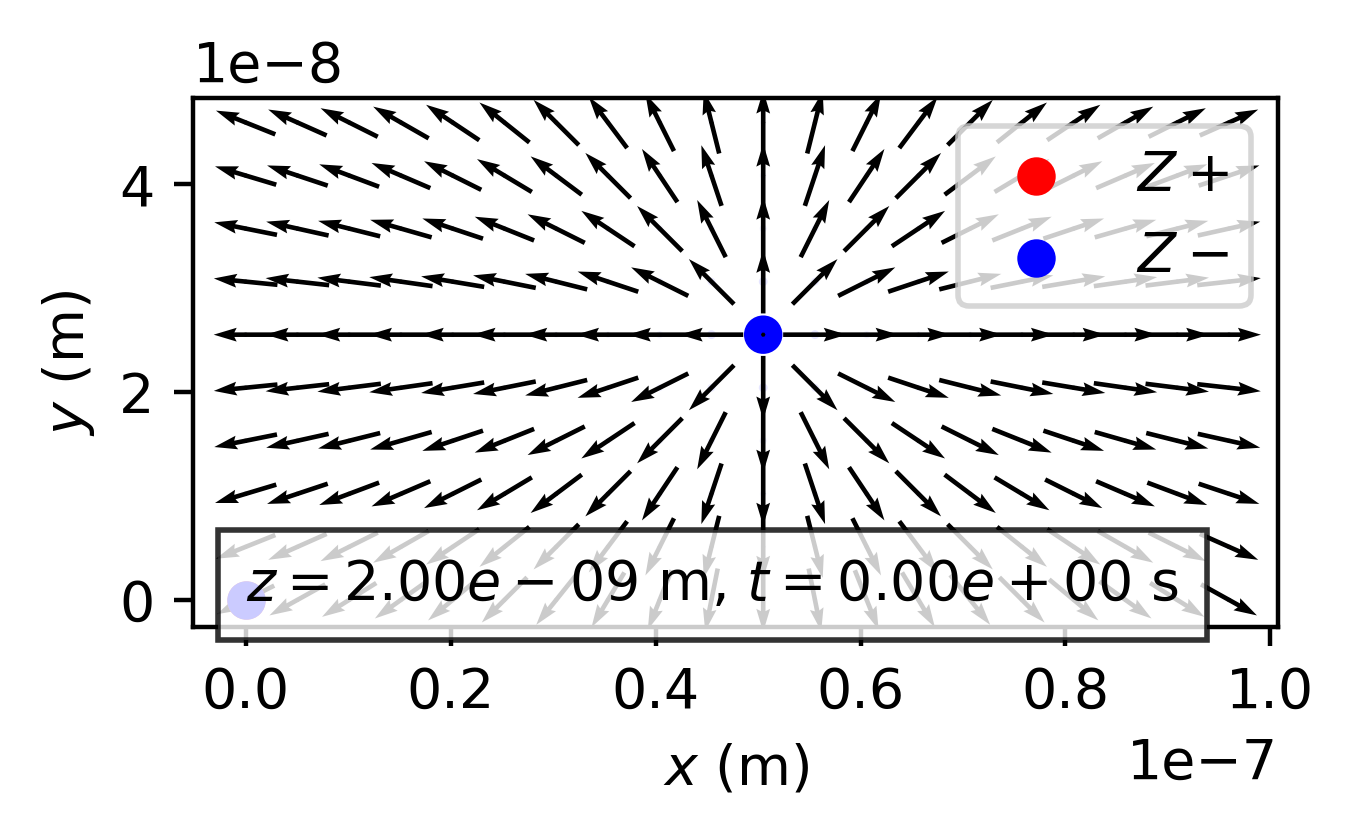

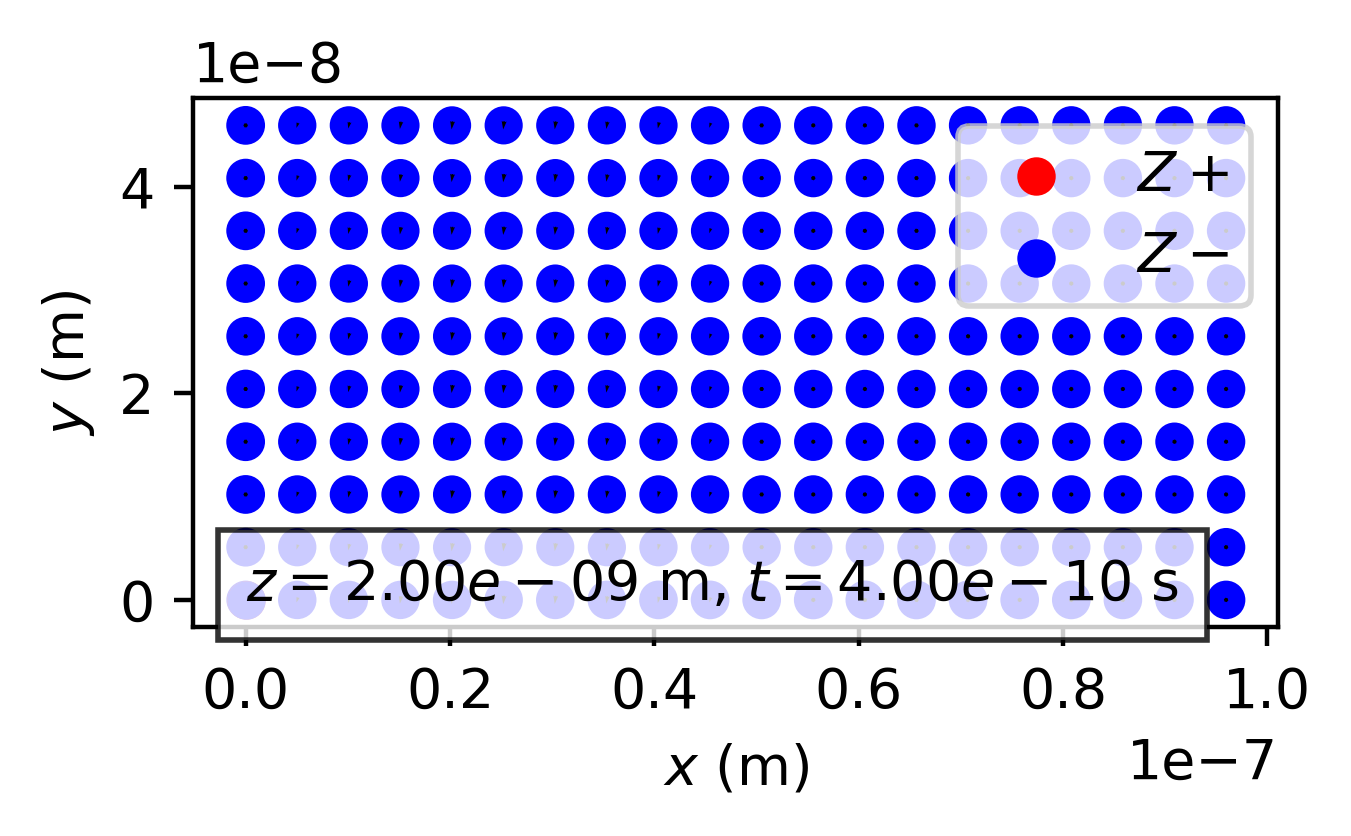

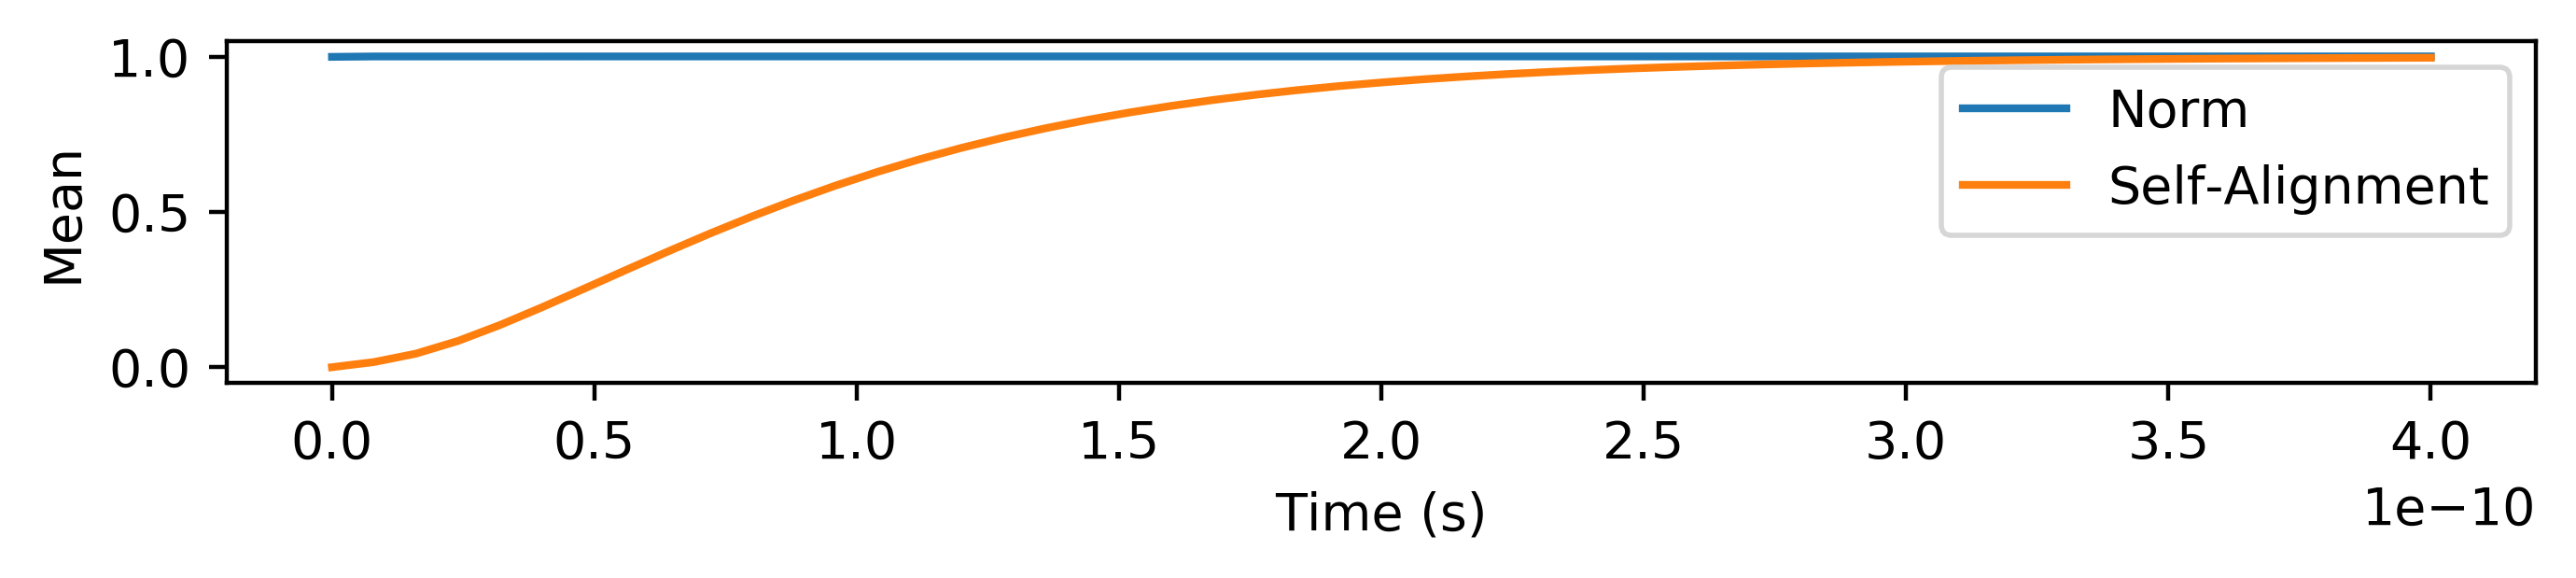

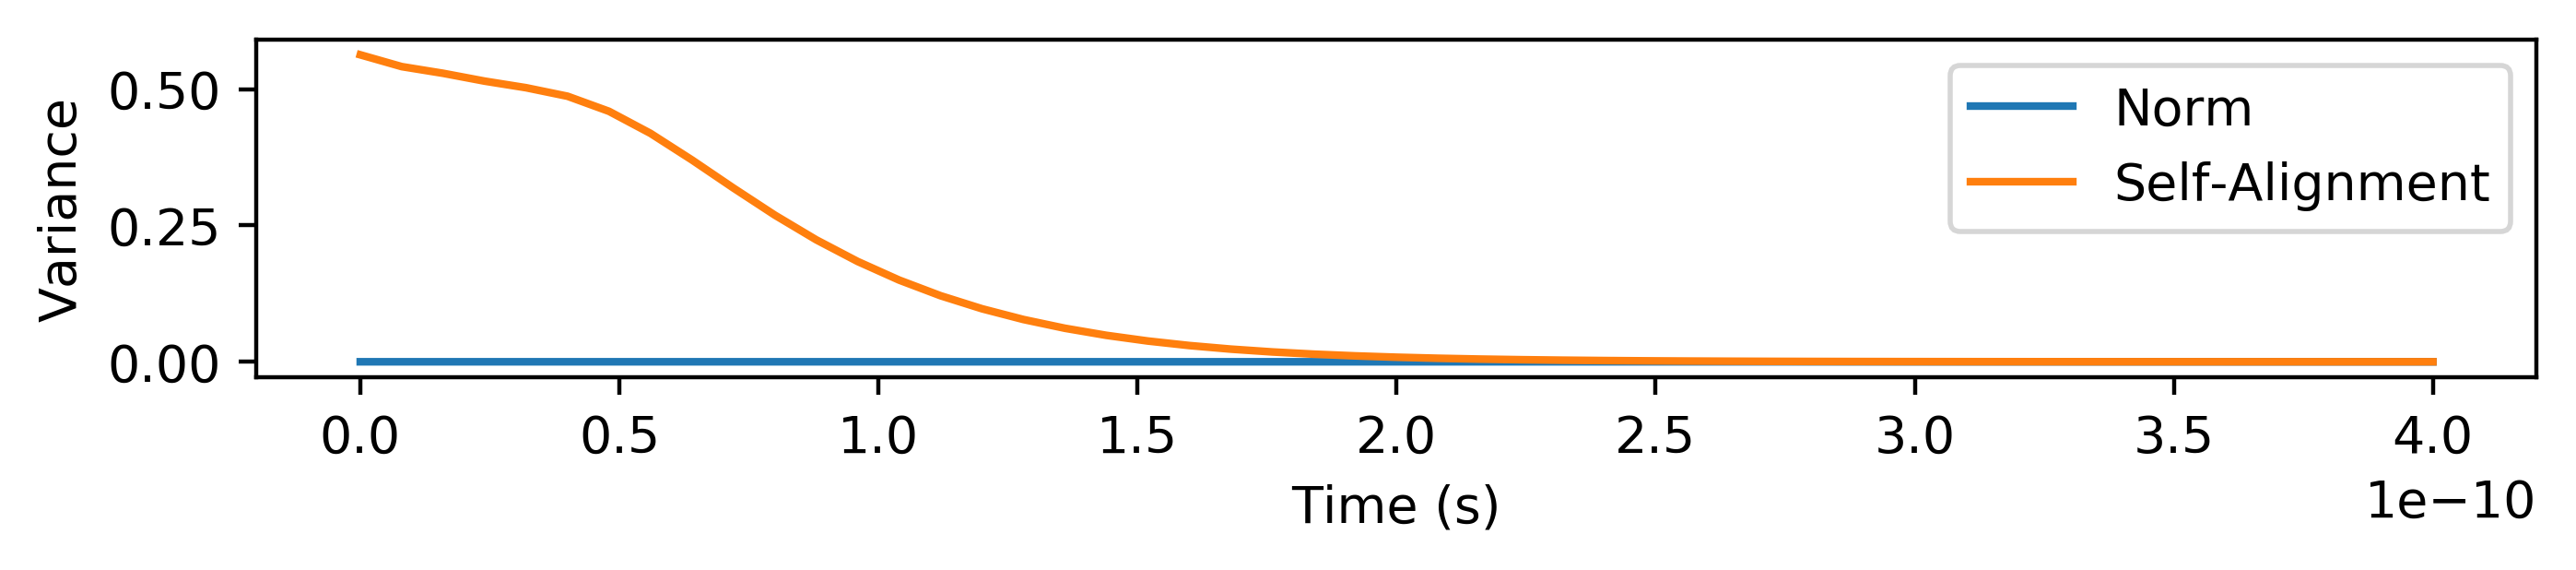

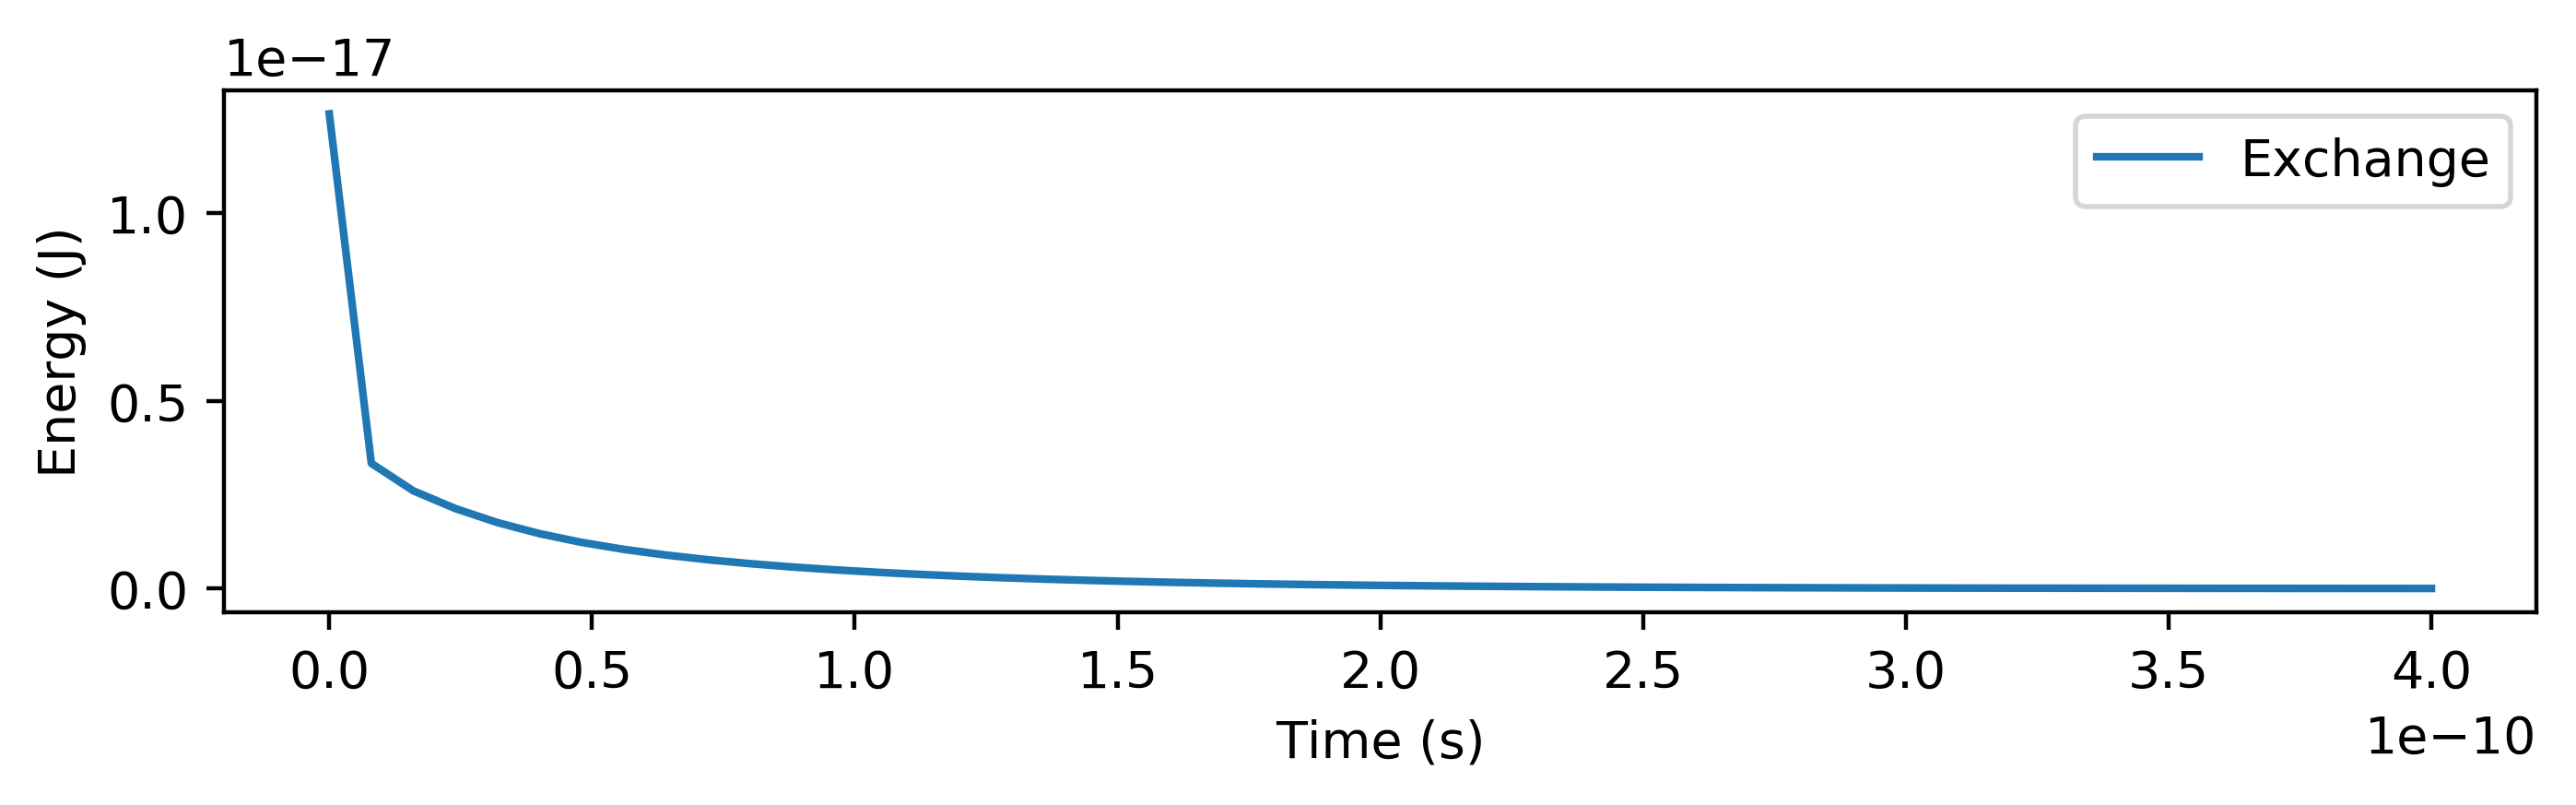

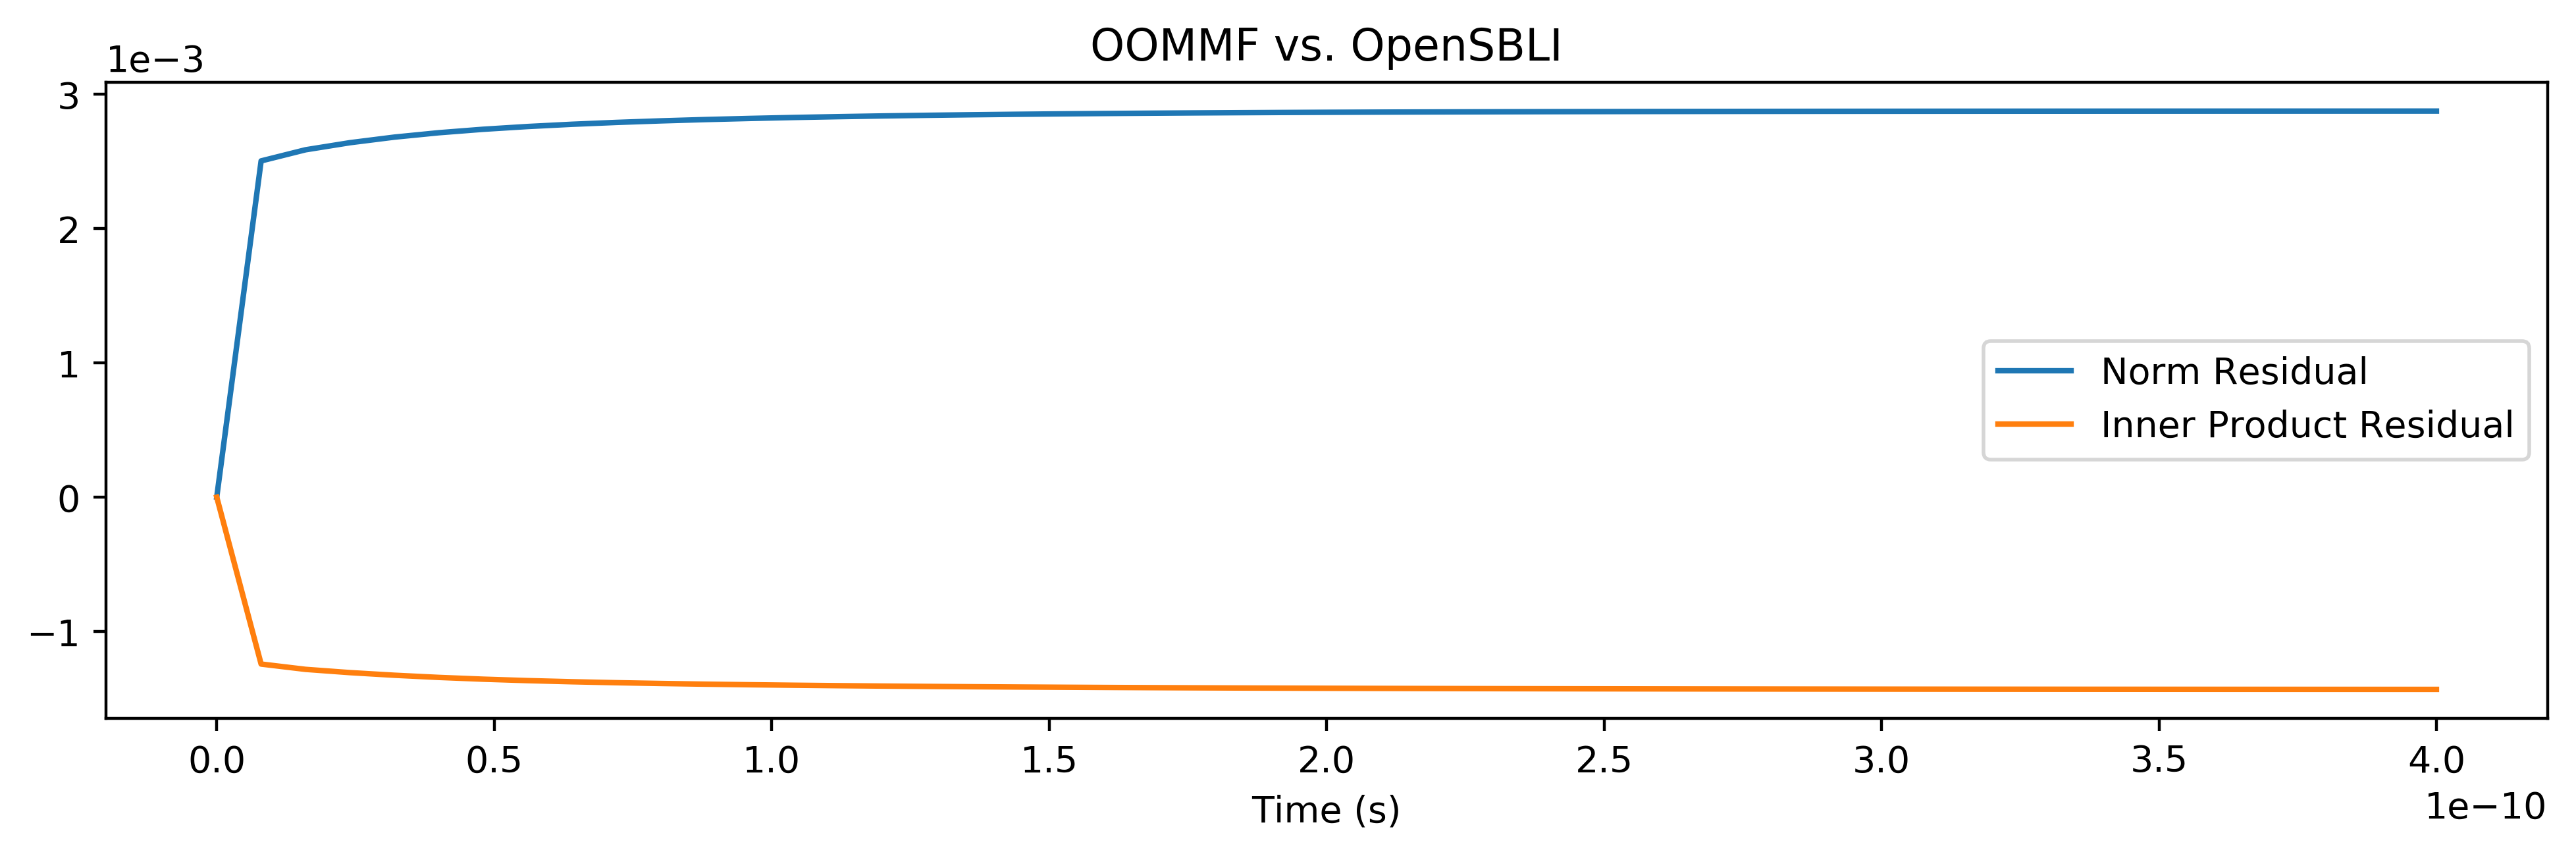

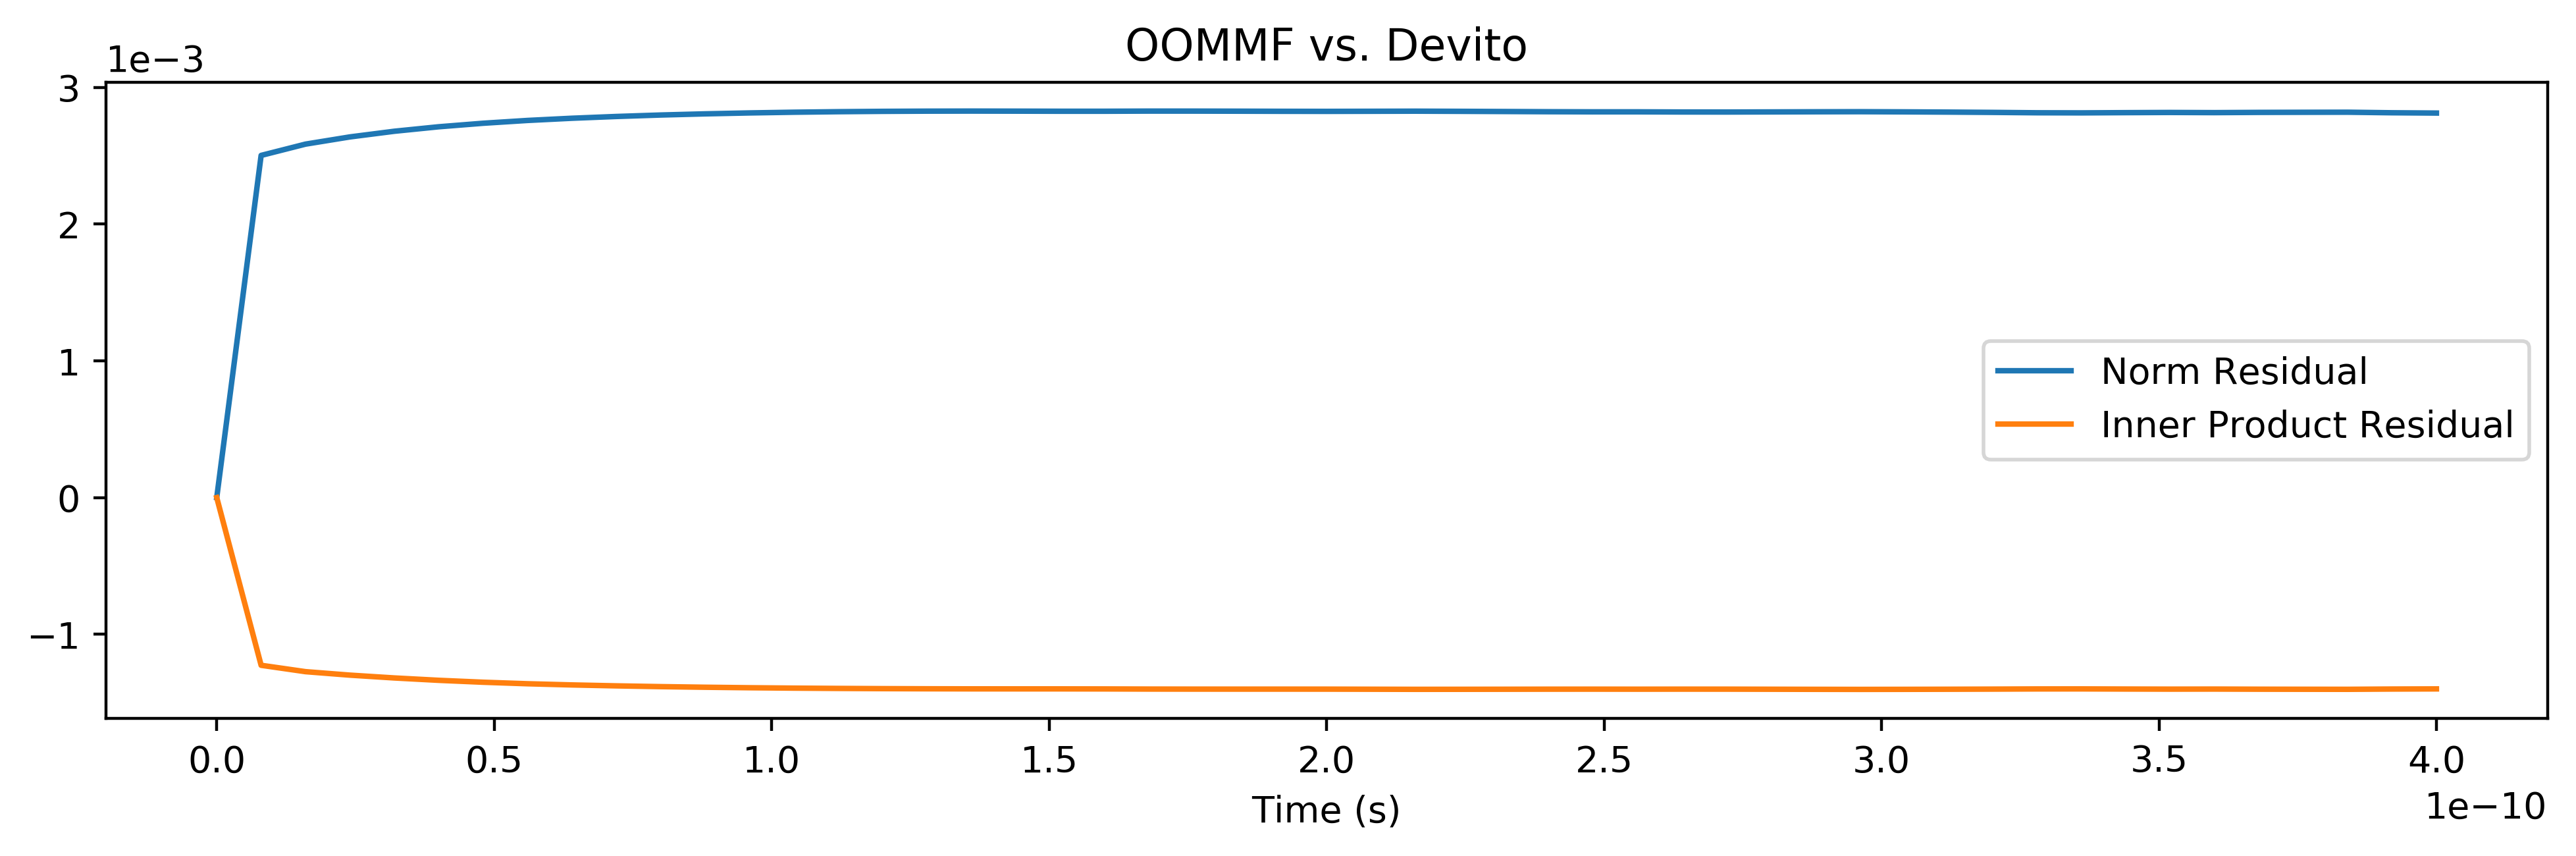

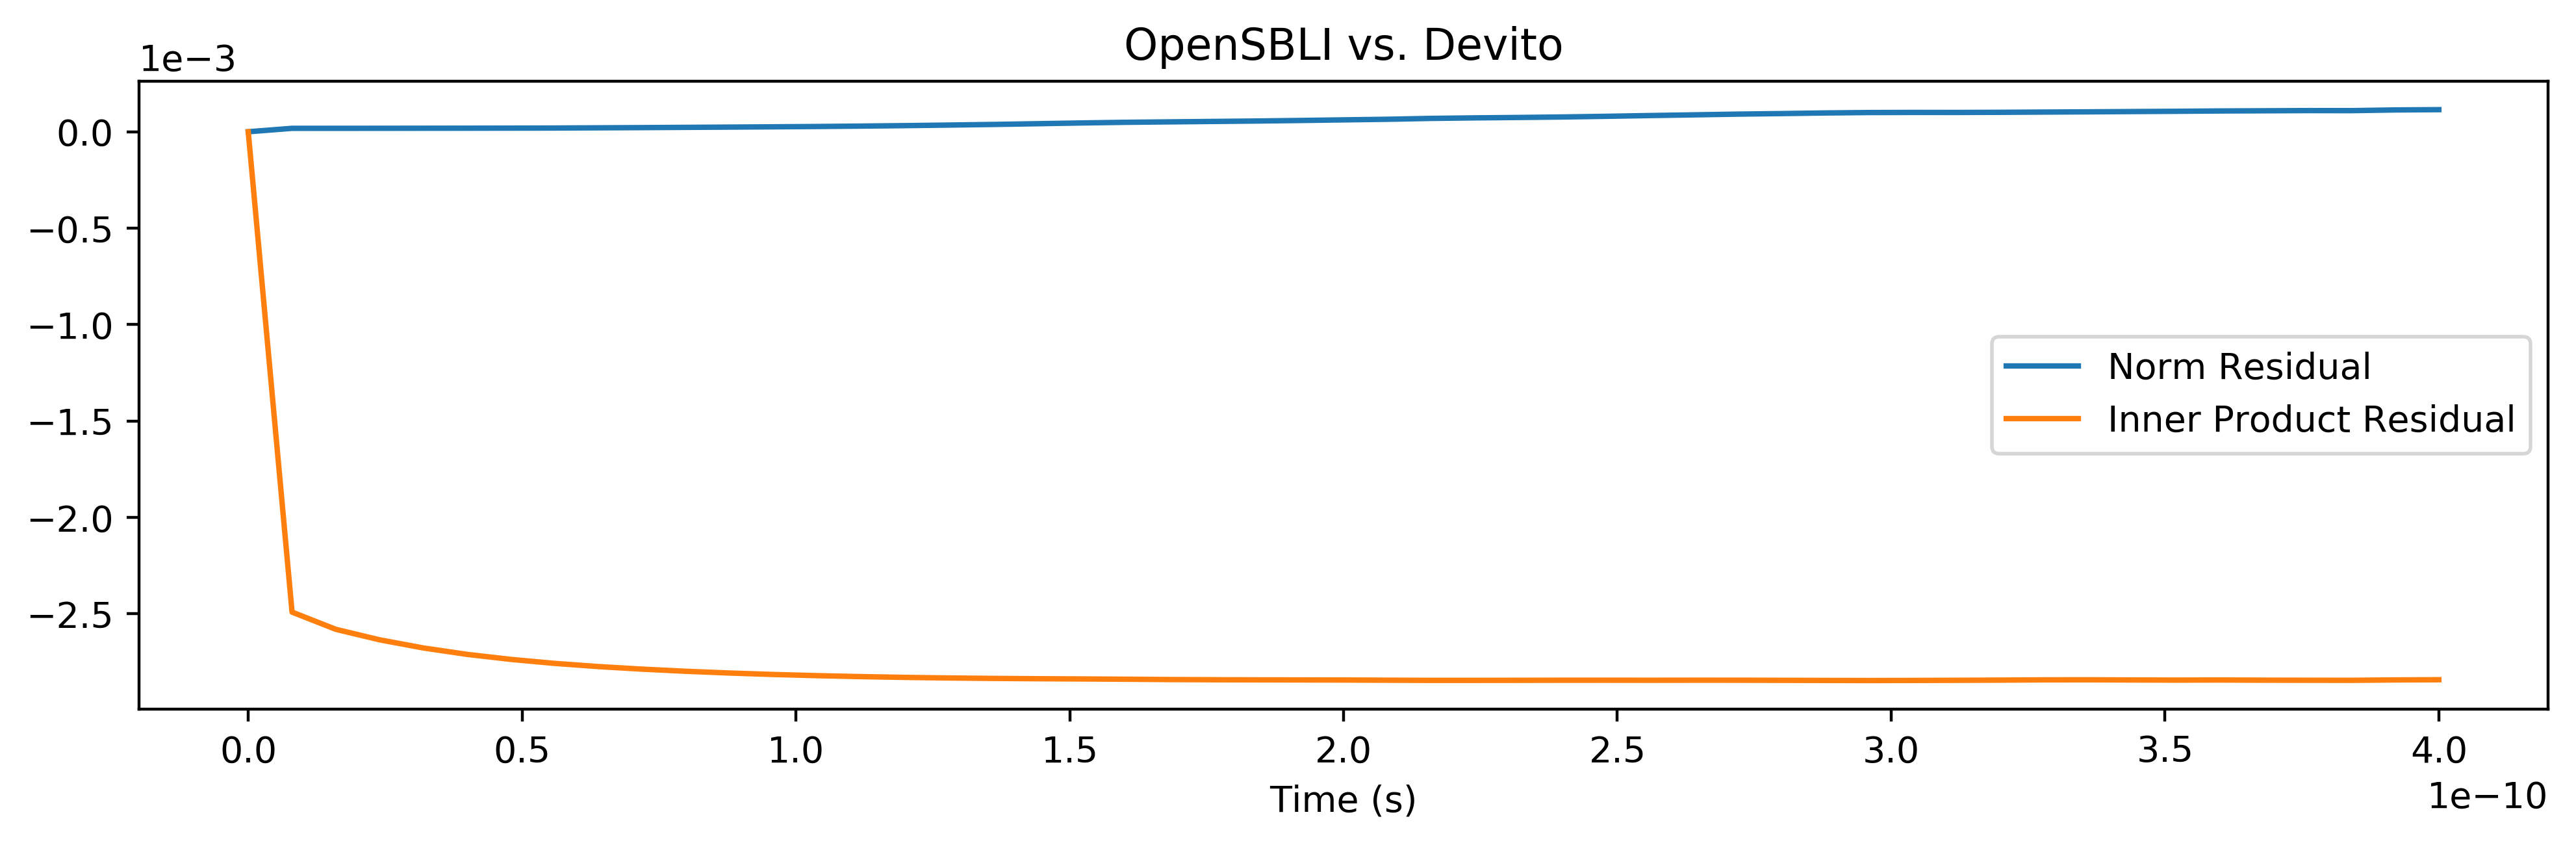

OOMMF
testing_40000/OOMMF_Anisotropy


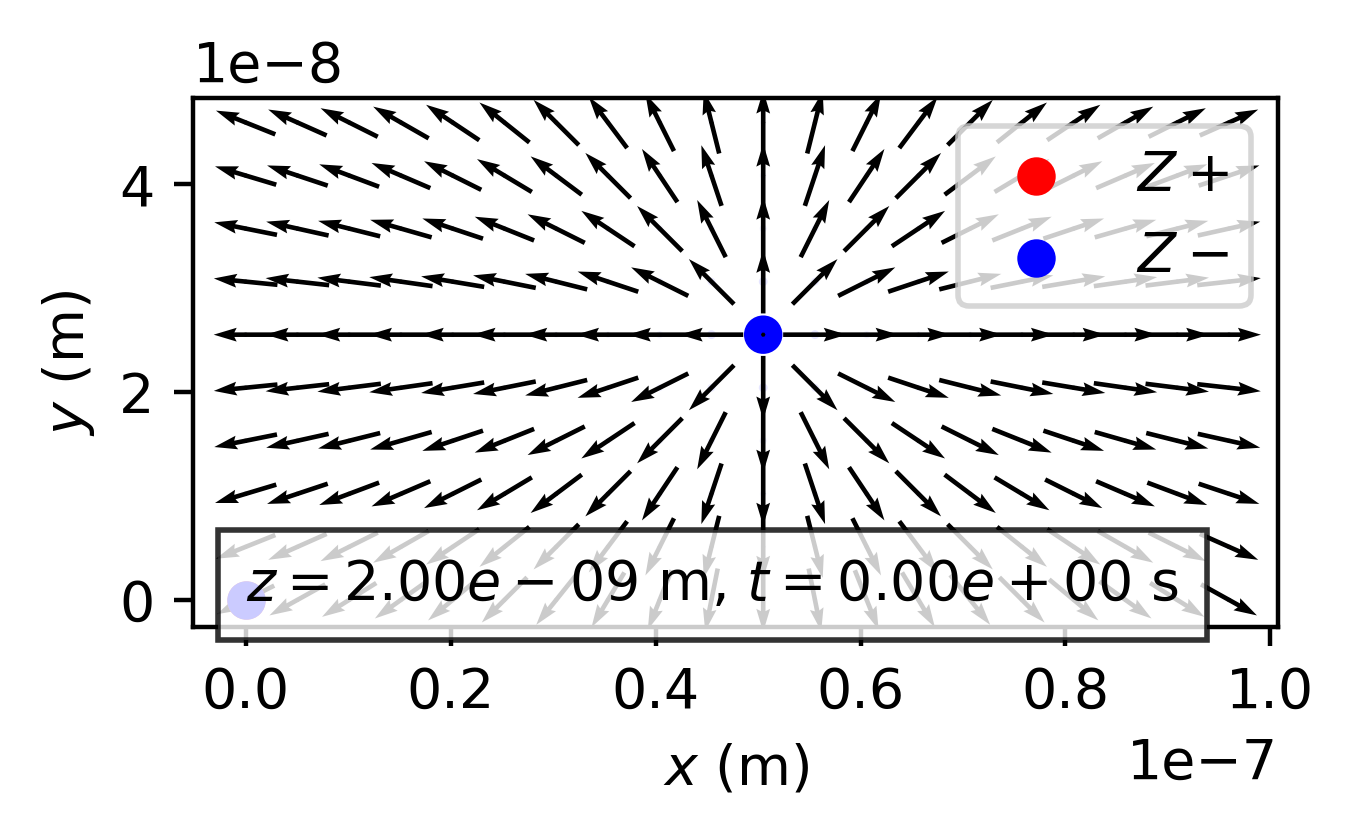

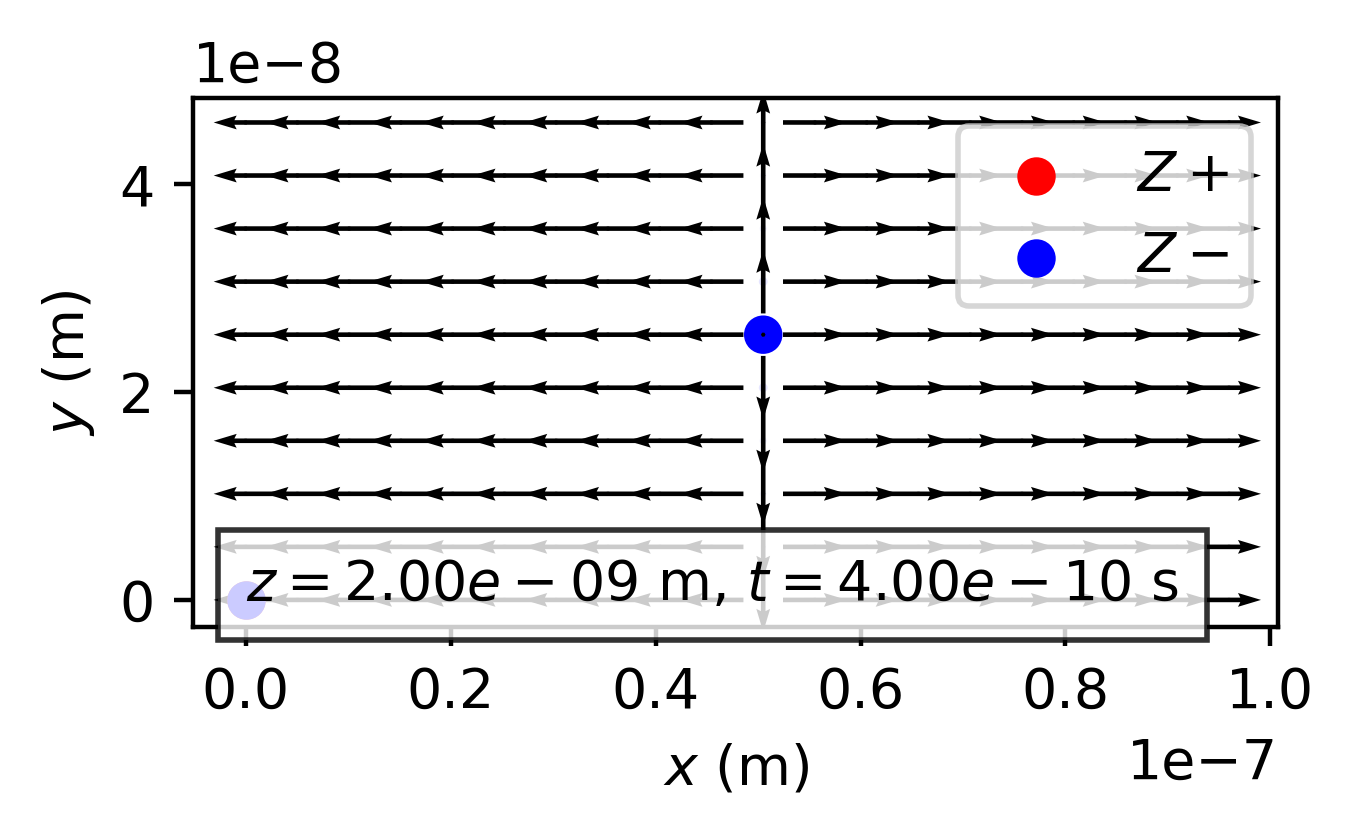

something


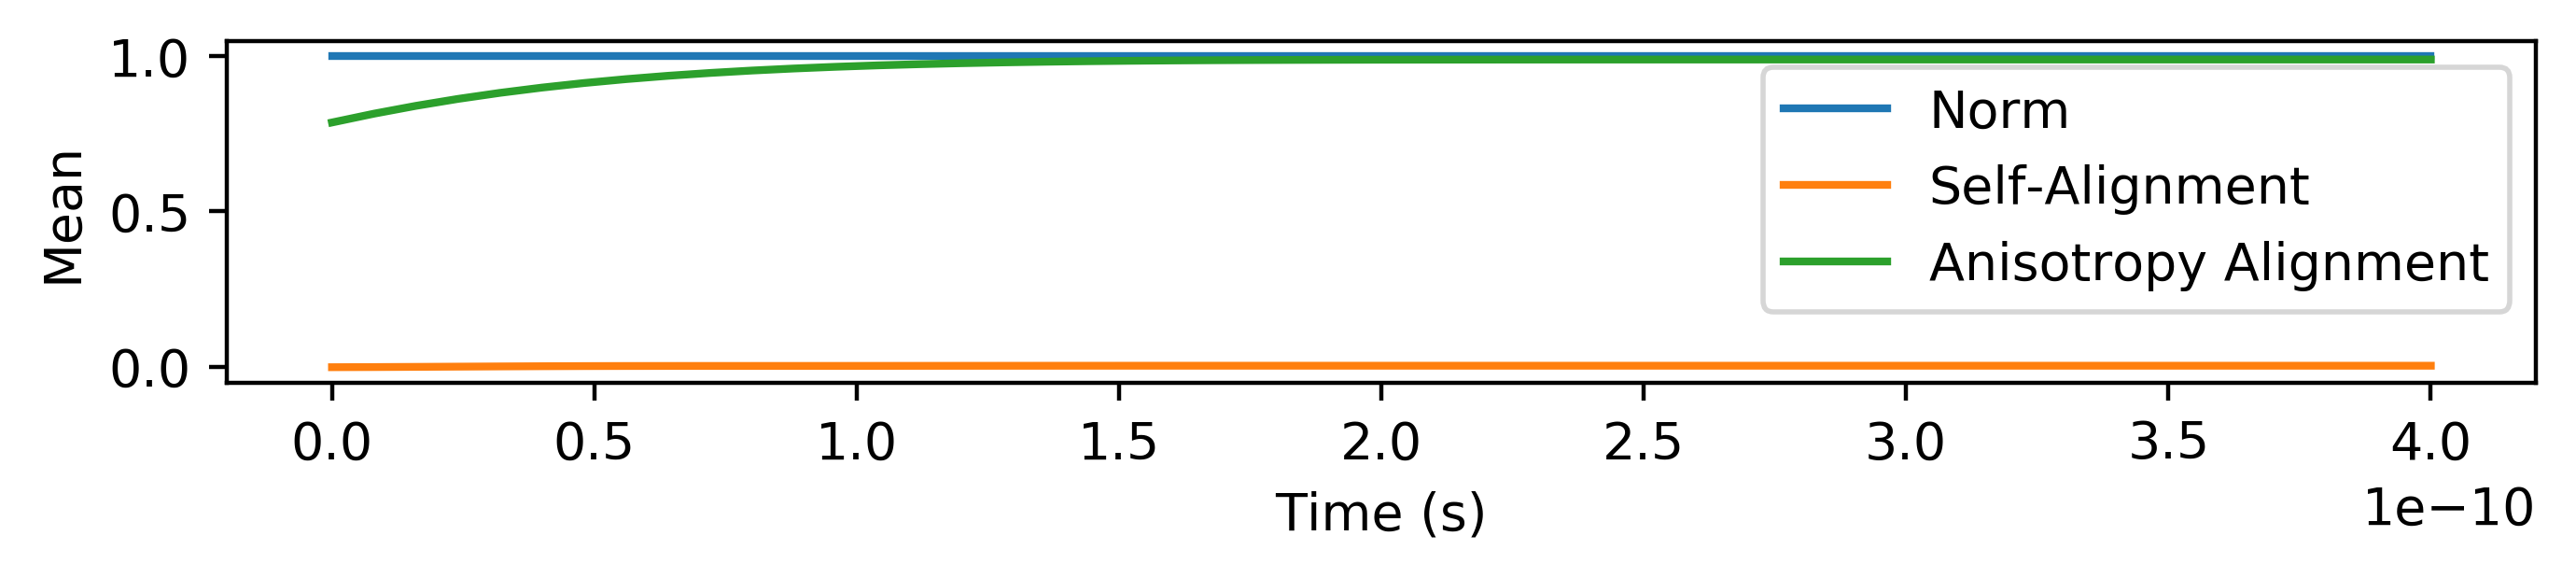

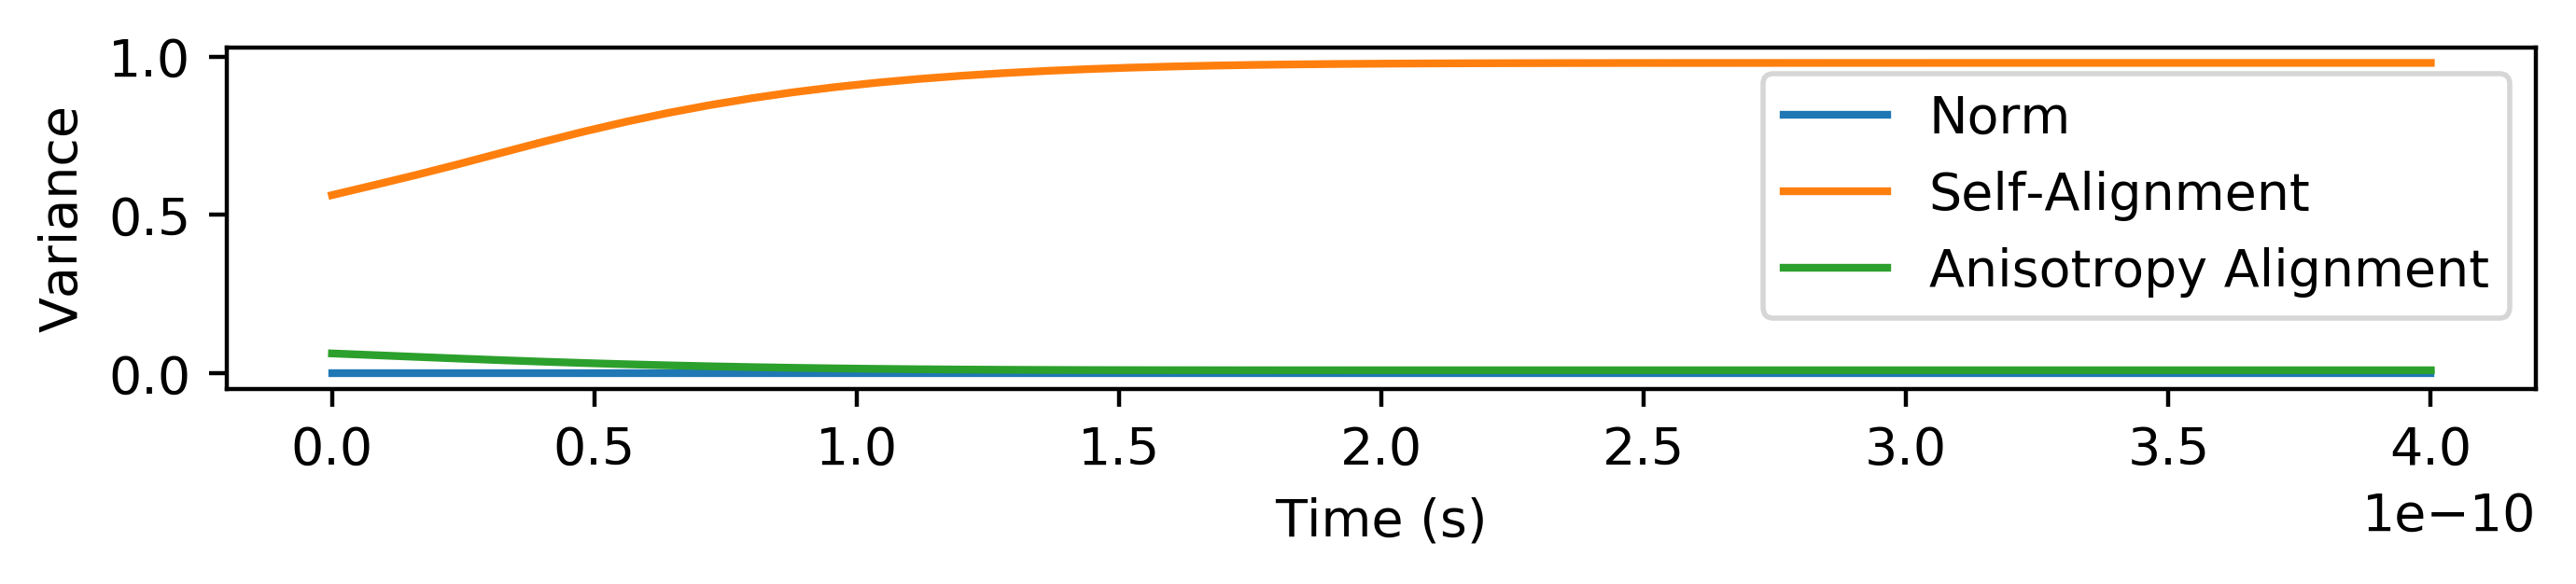

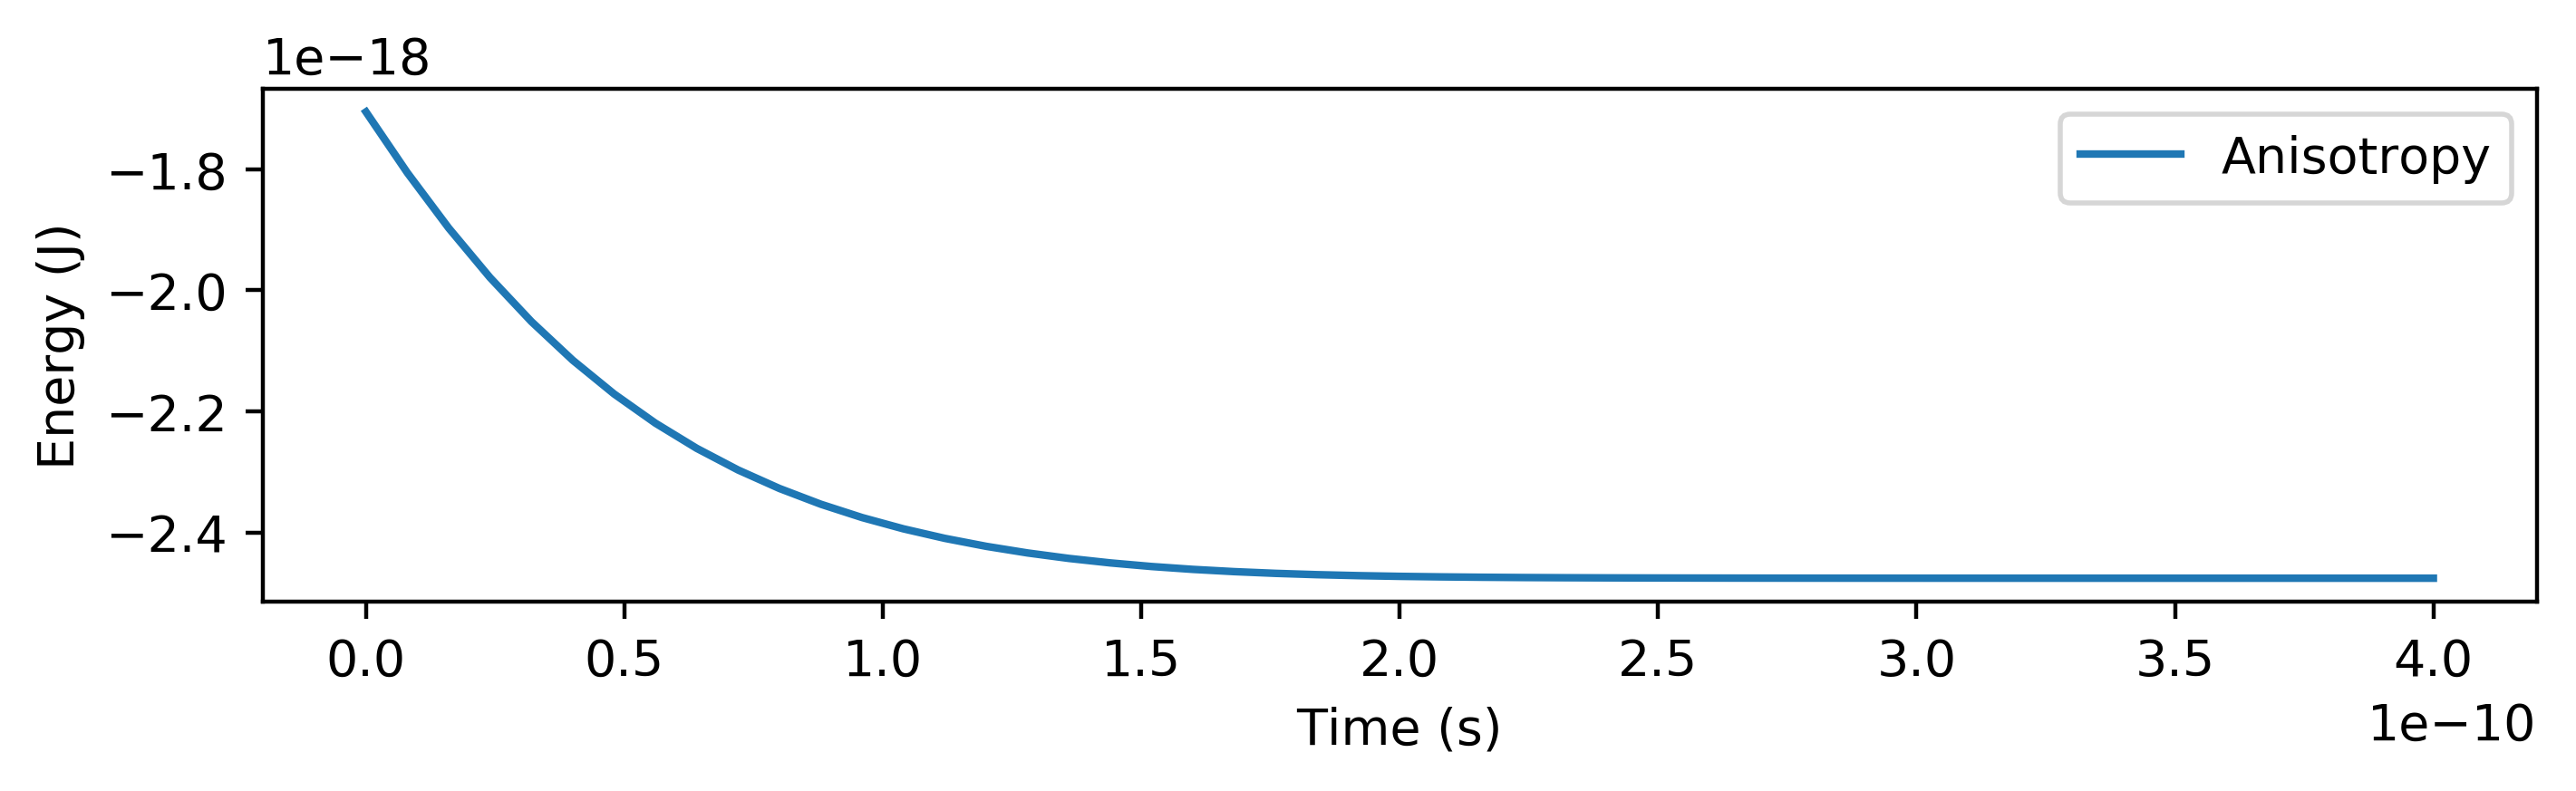

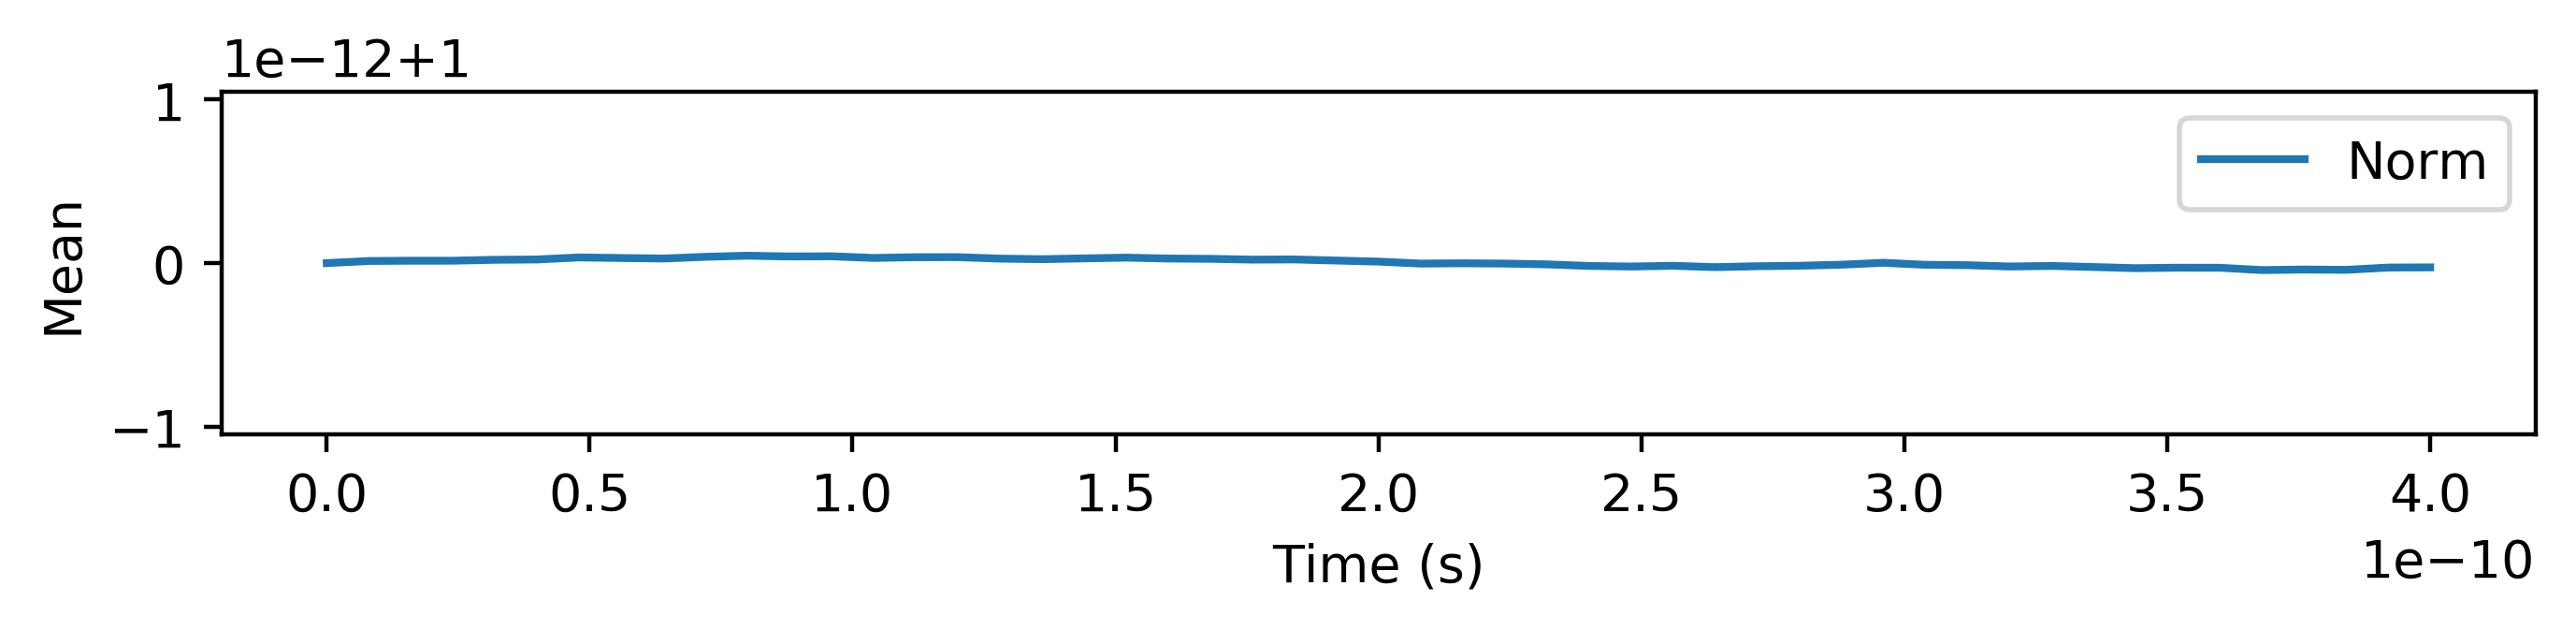

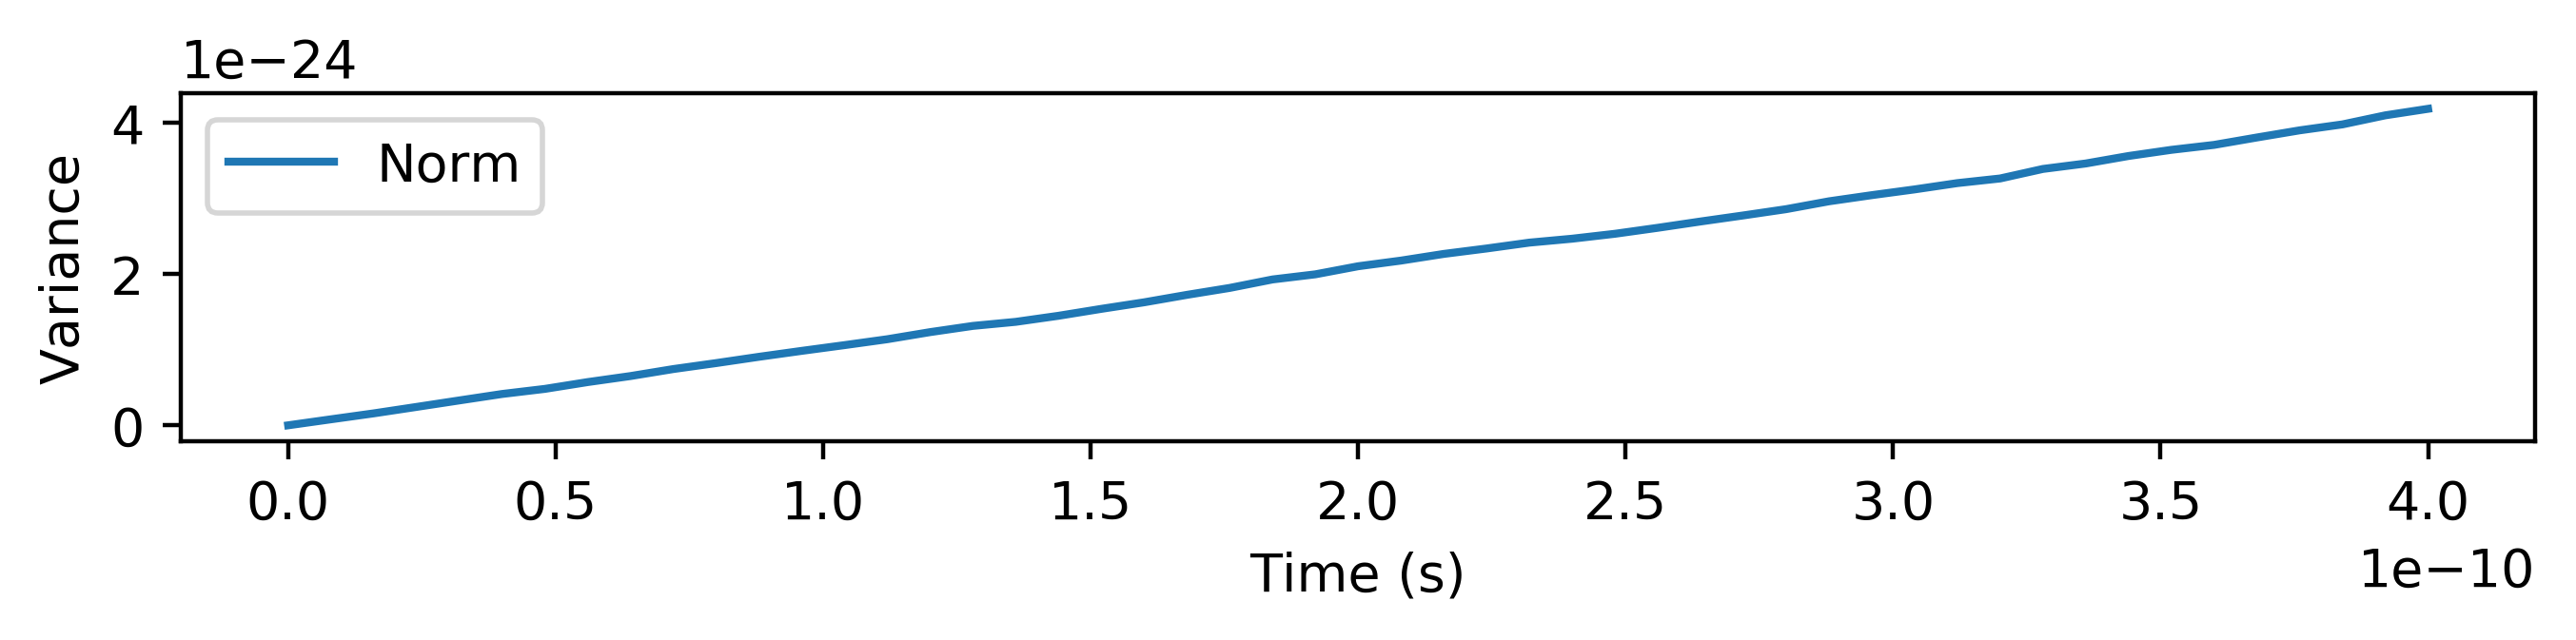

Devito
testing_40000/Devito_Anisotropy


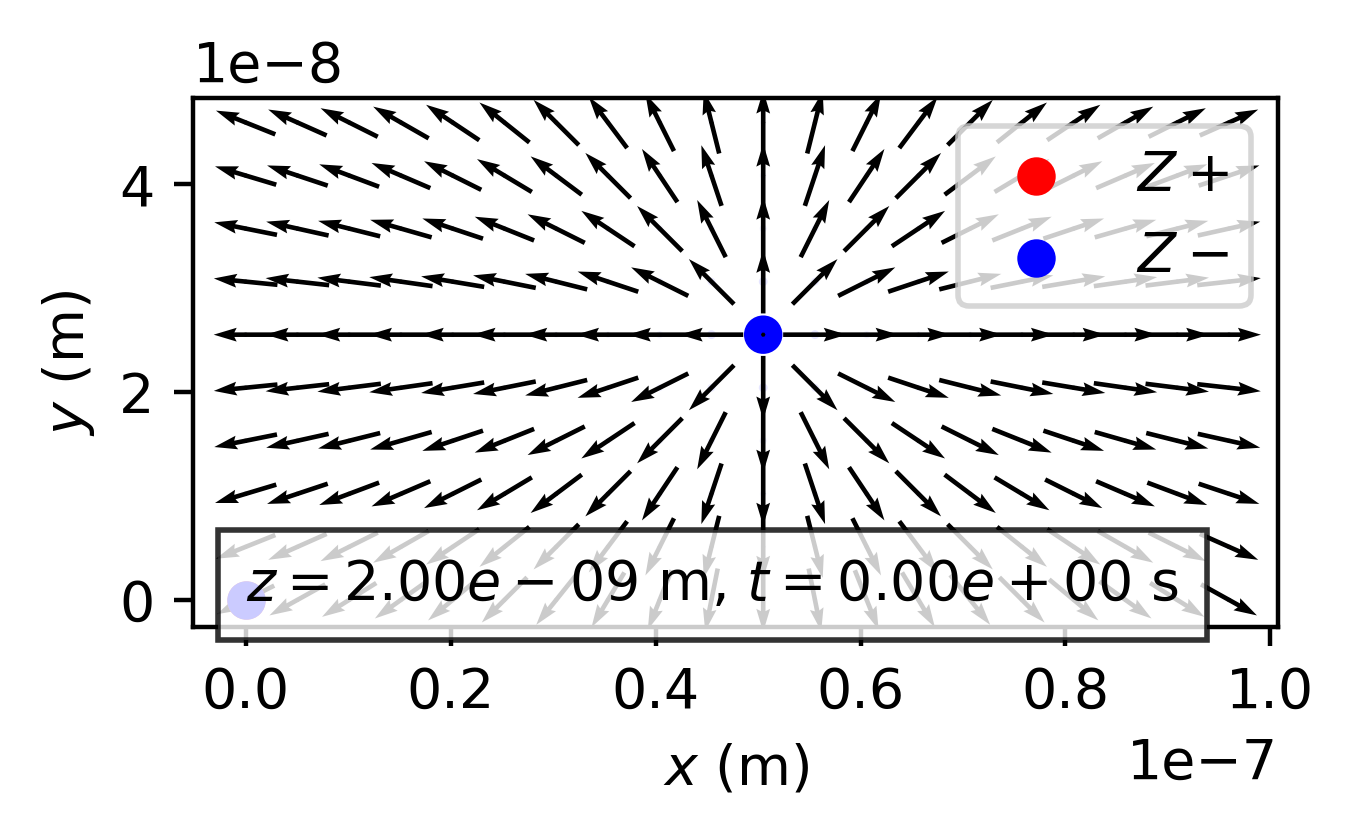

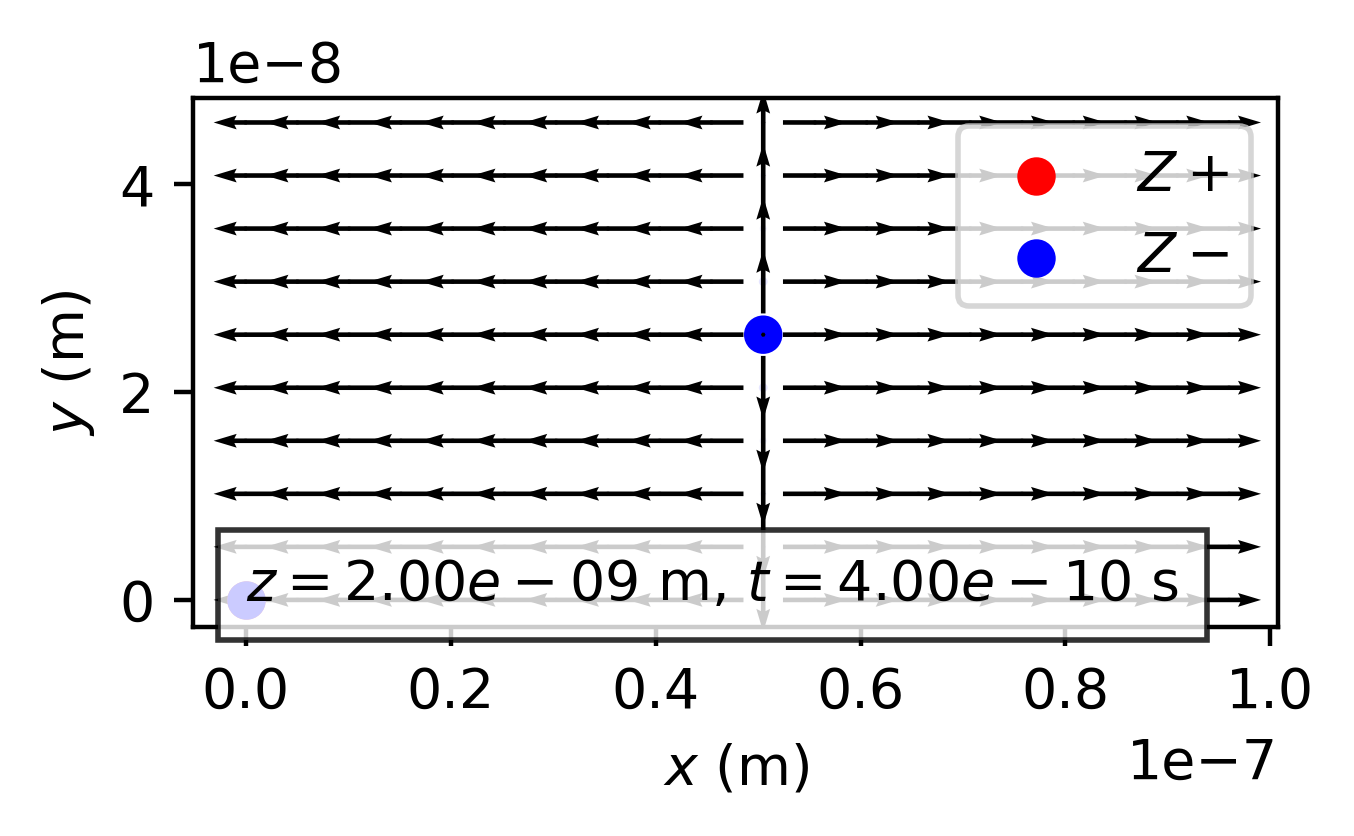

something


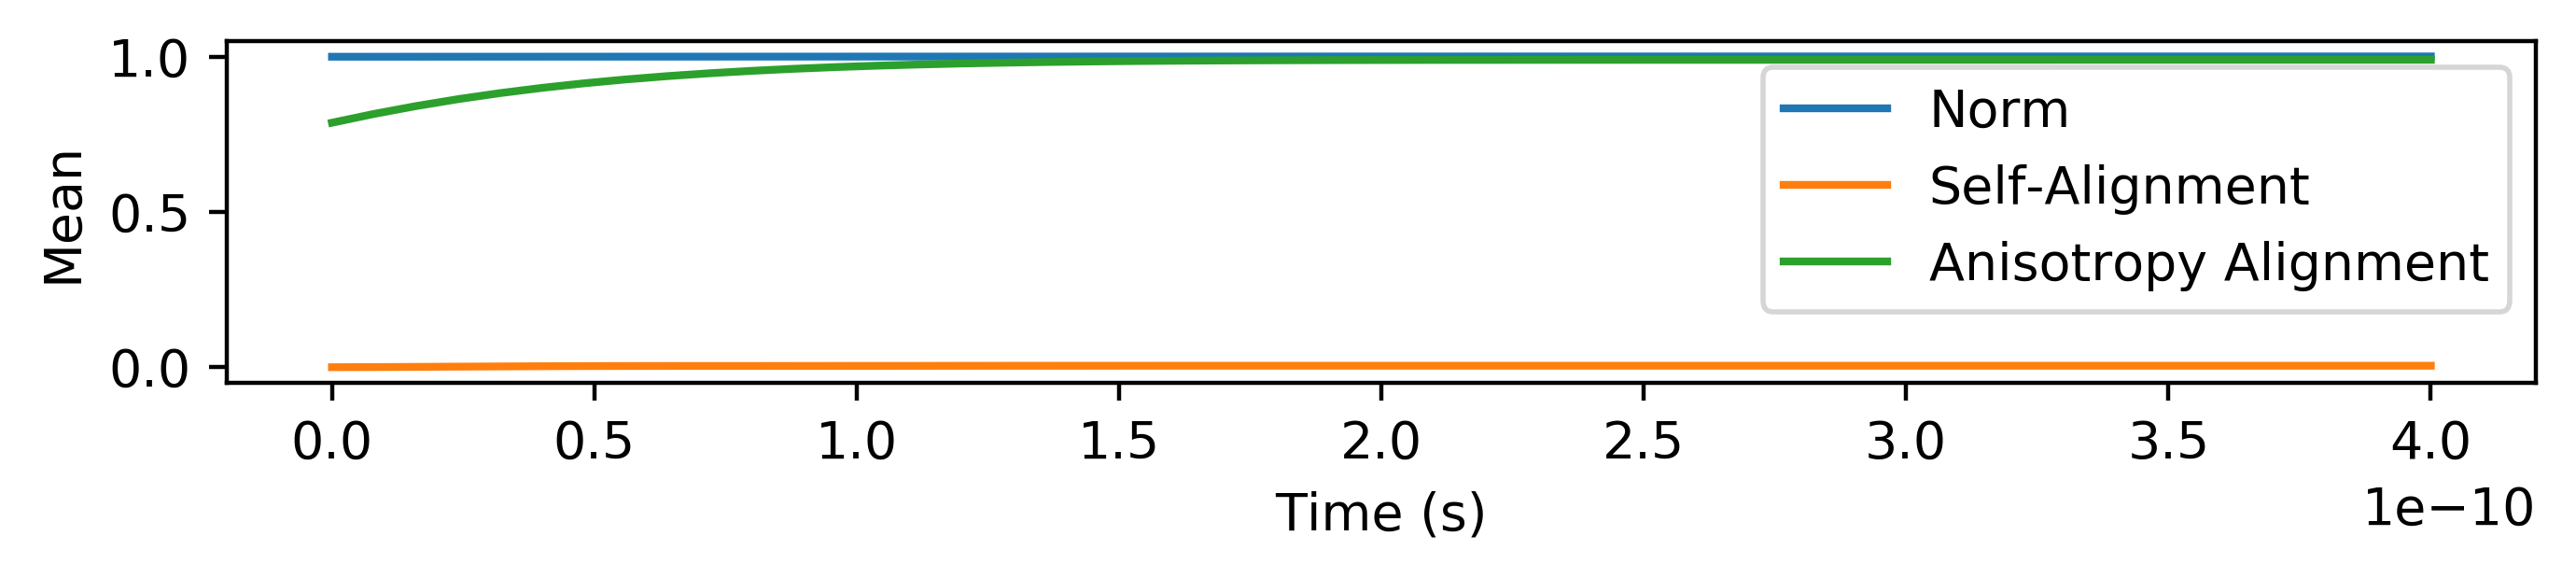

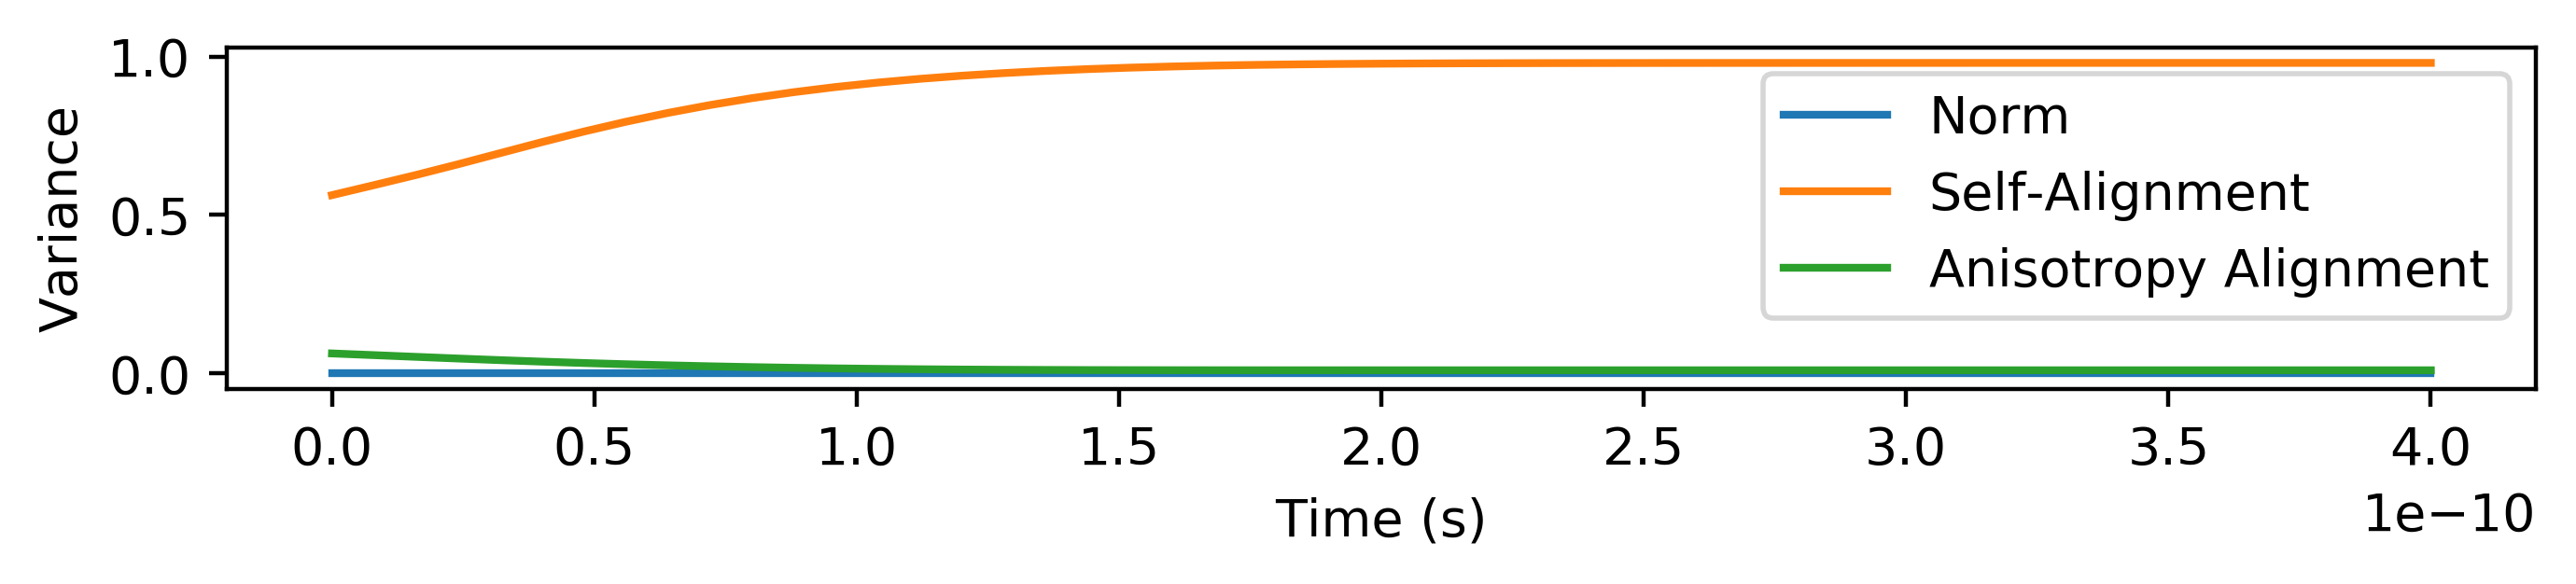

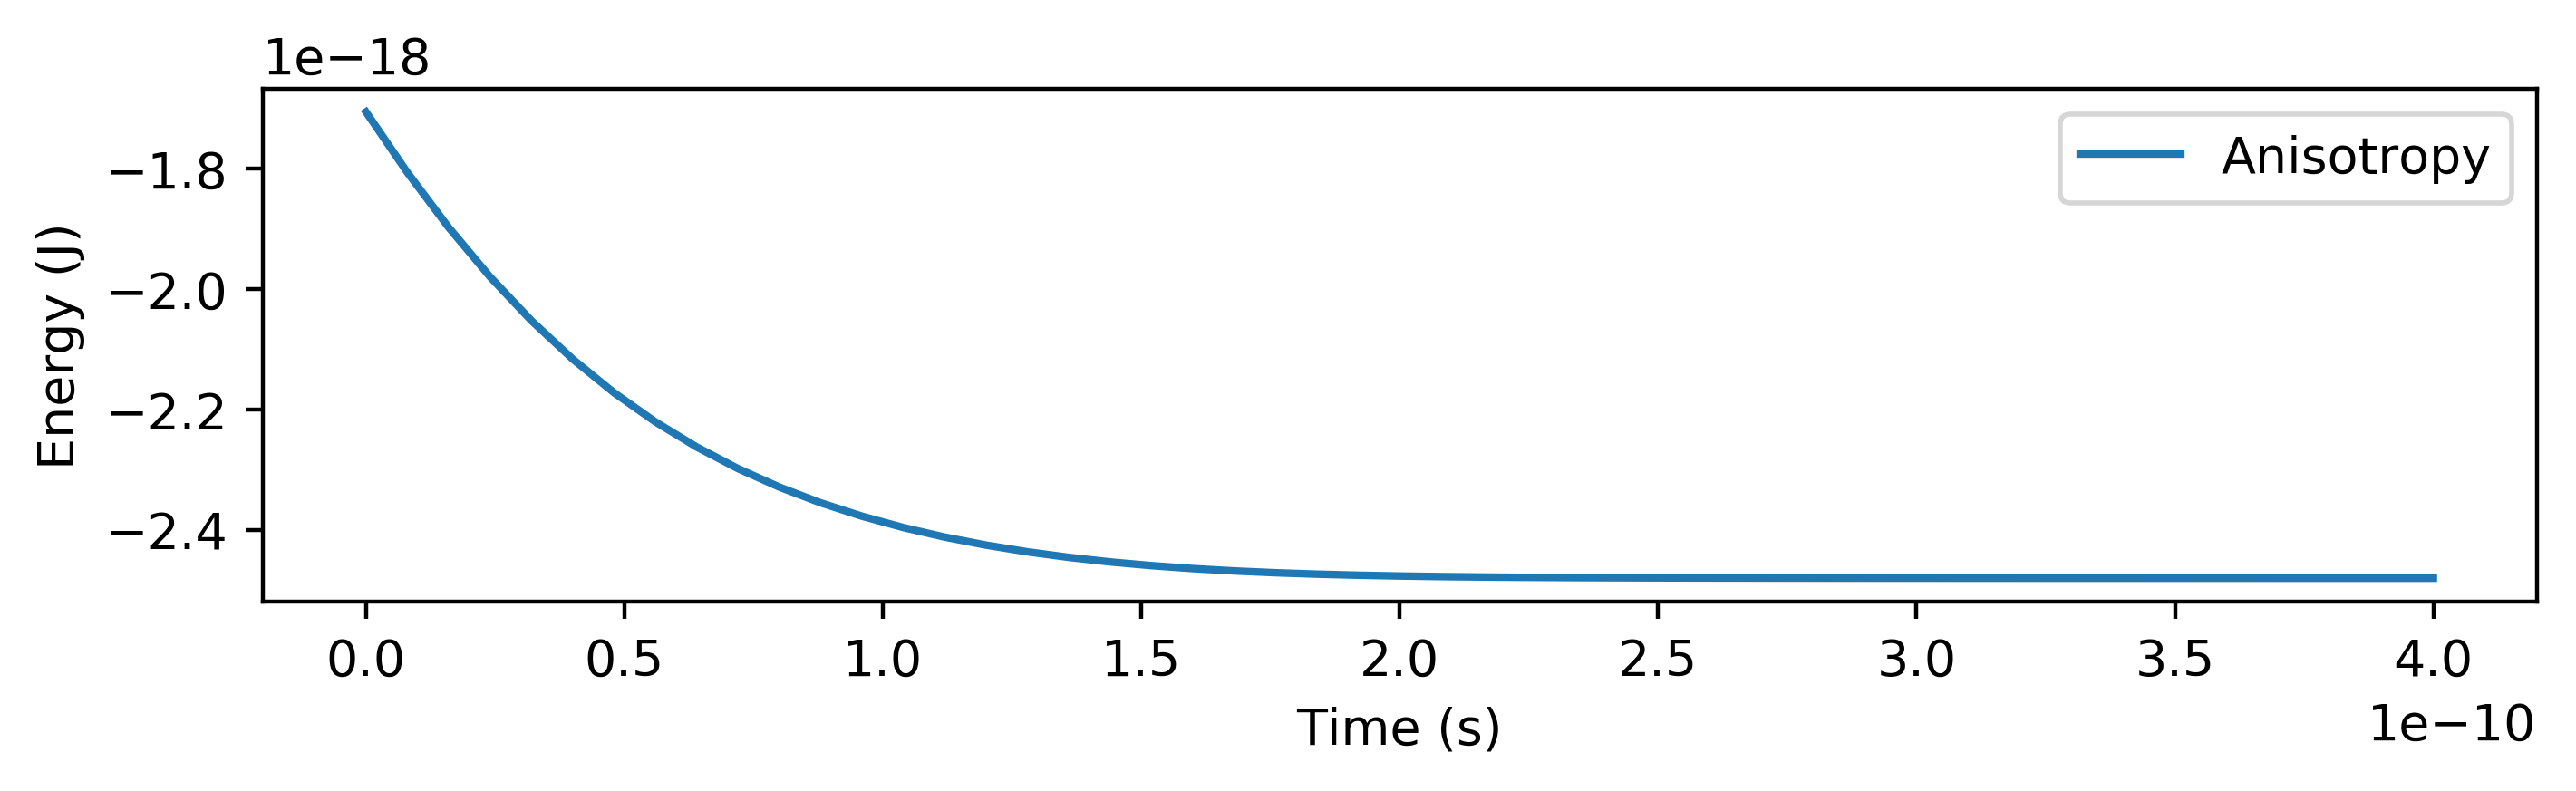

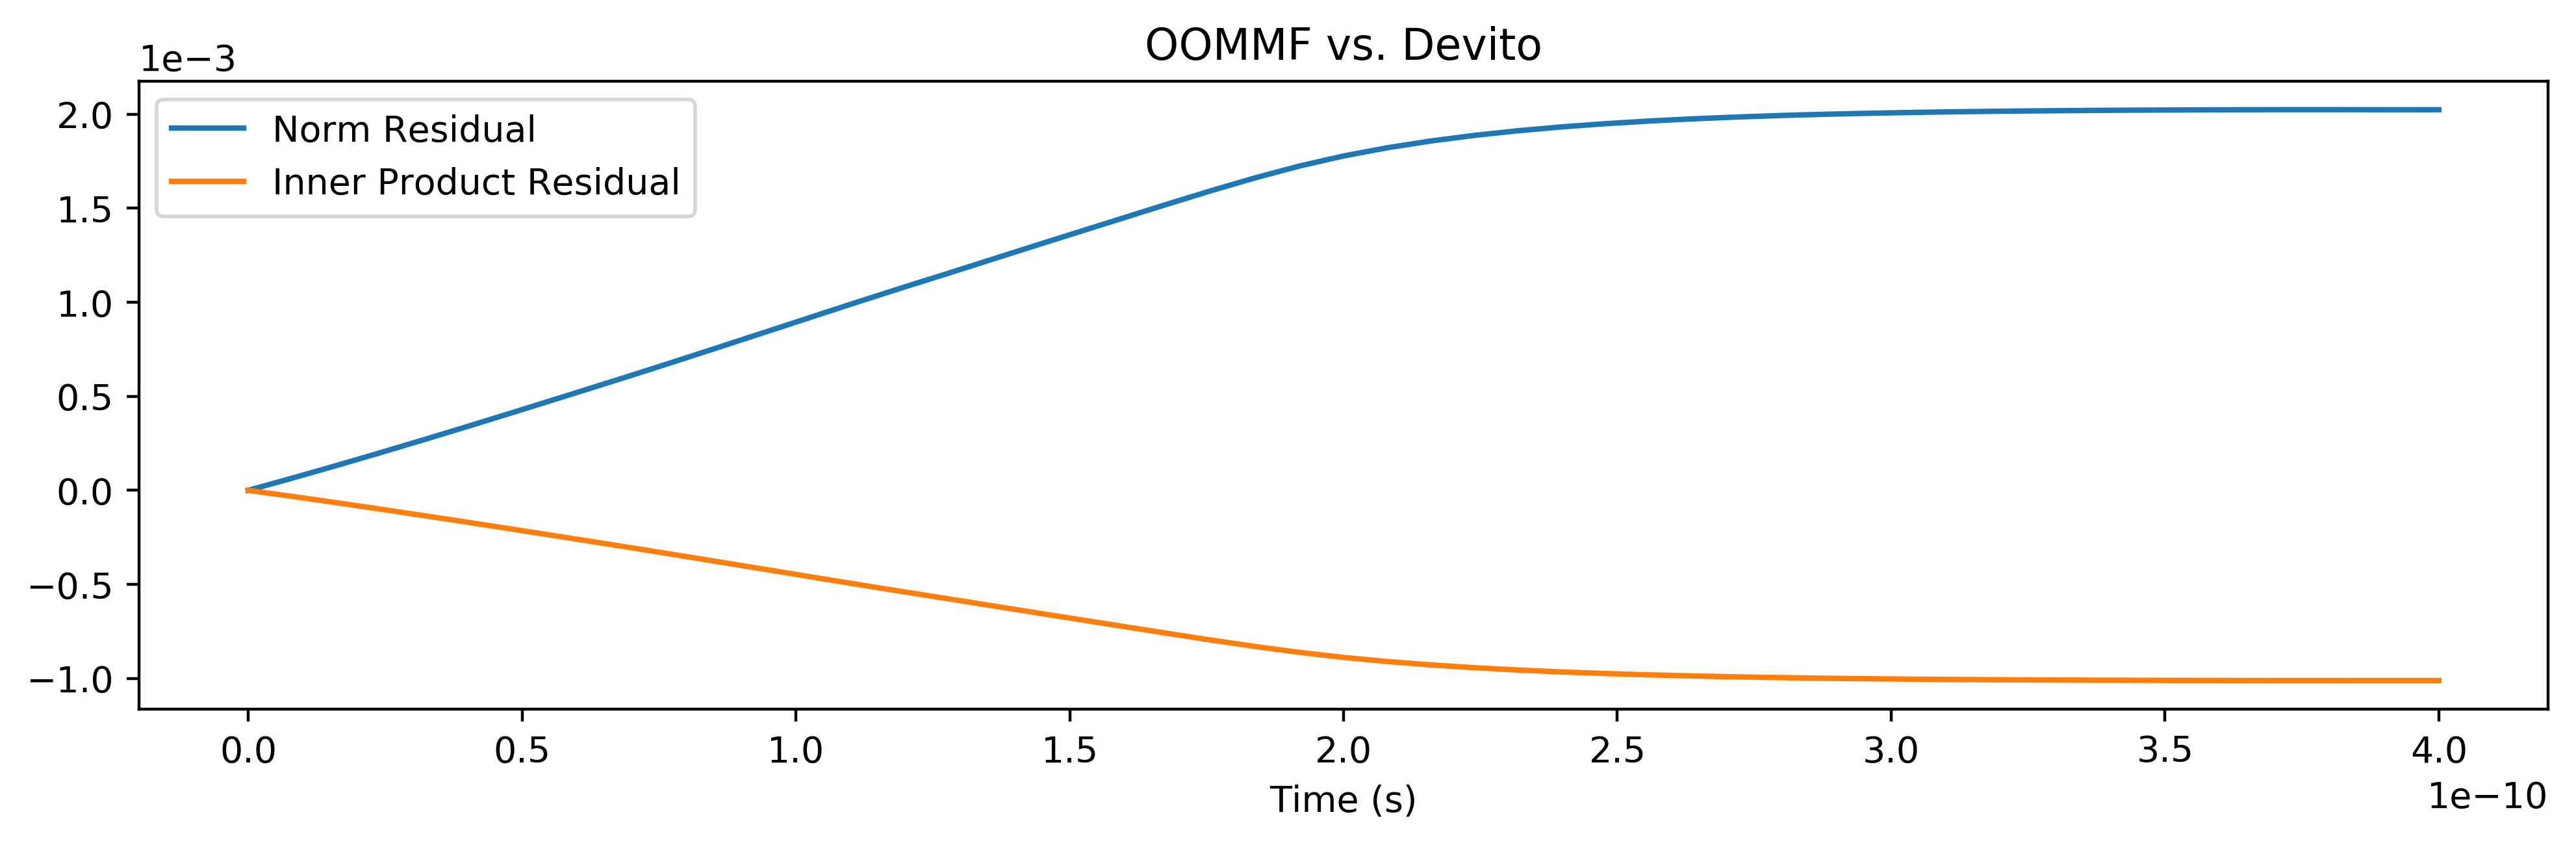

OOMMF
testing_40000/OOMMF_Zeeman


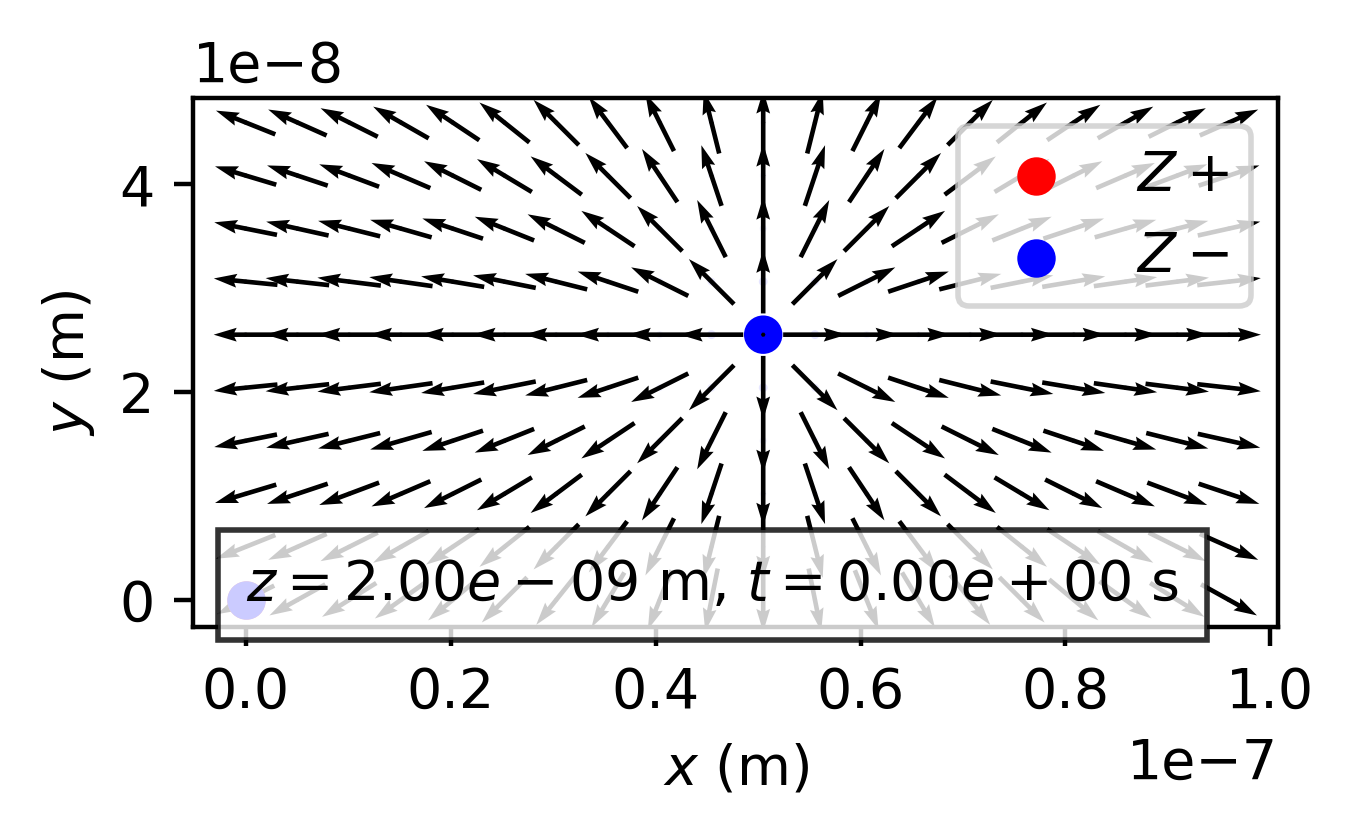

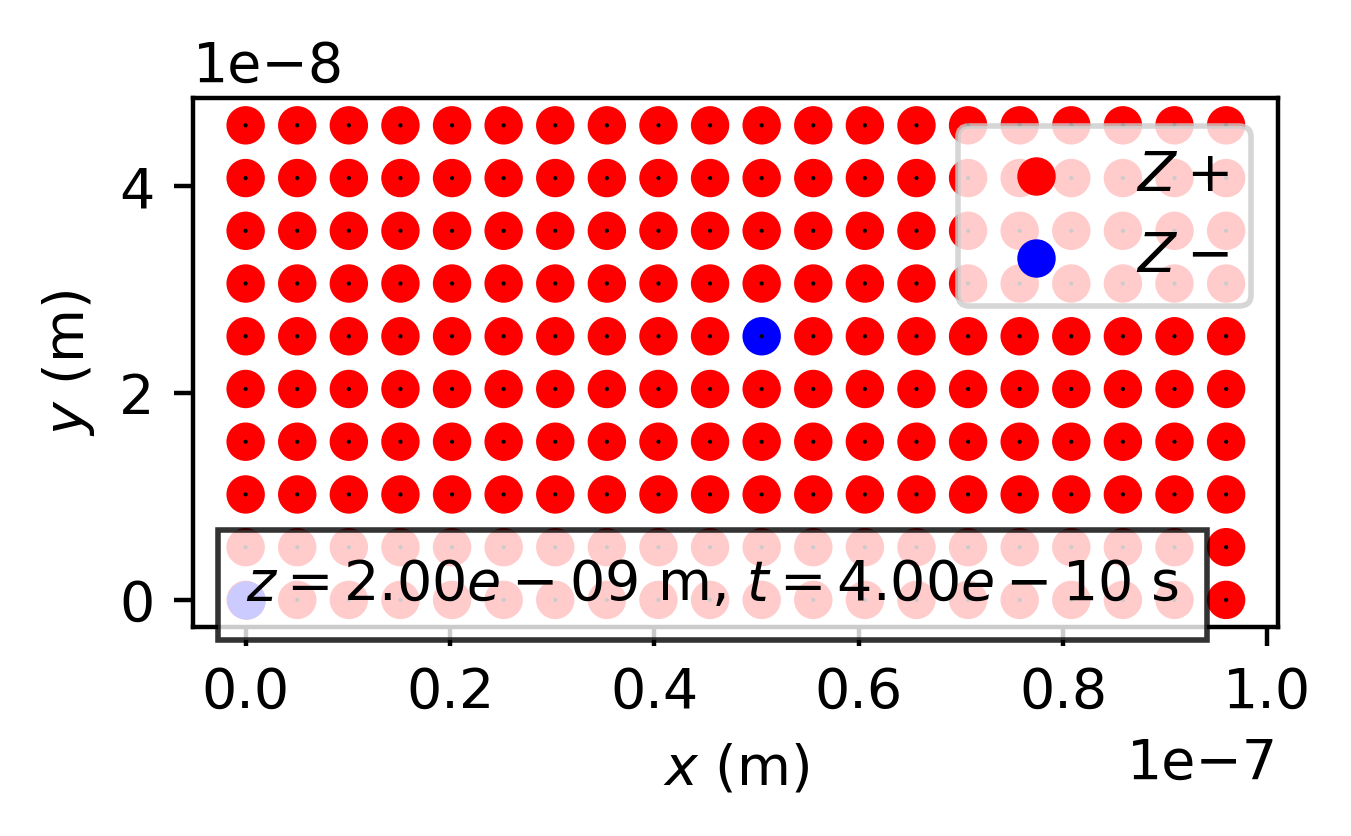

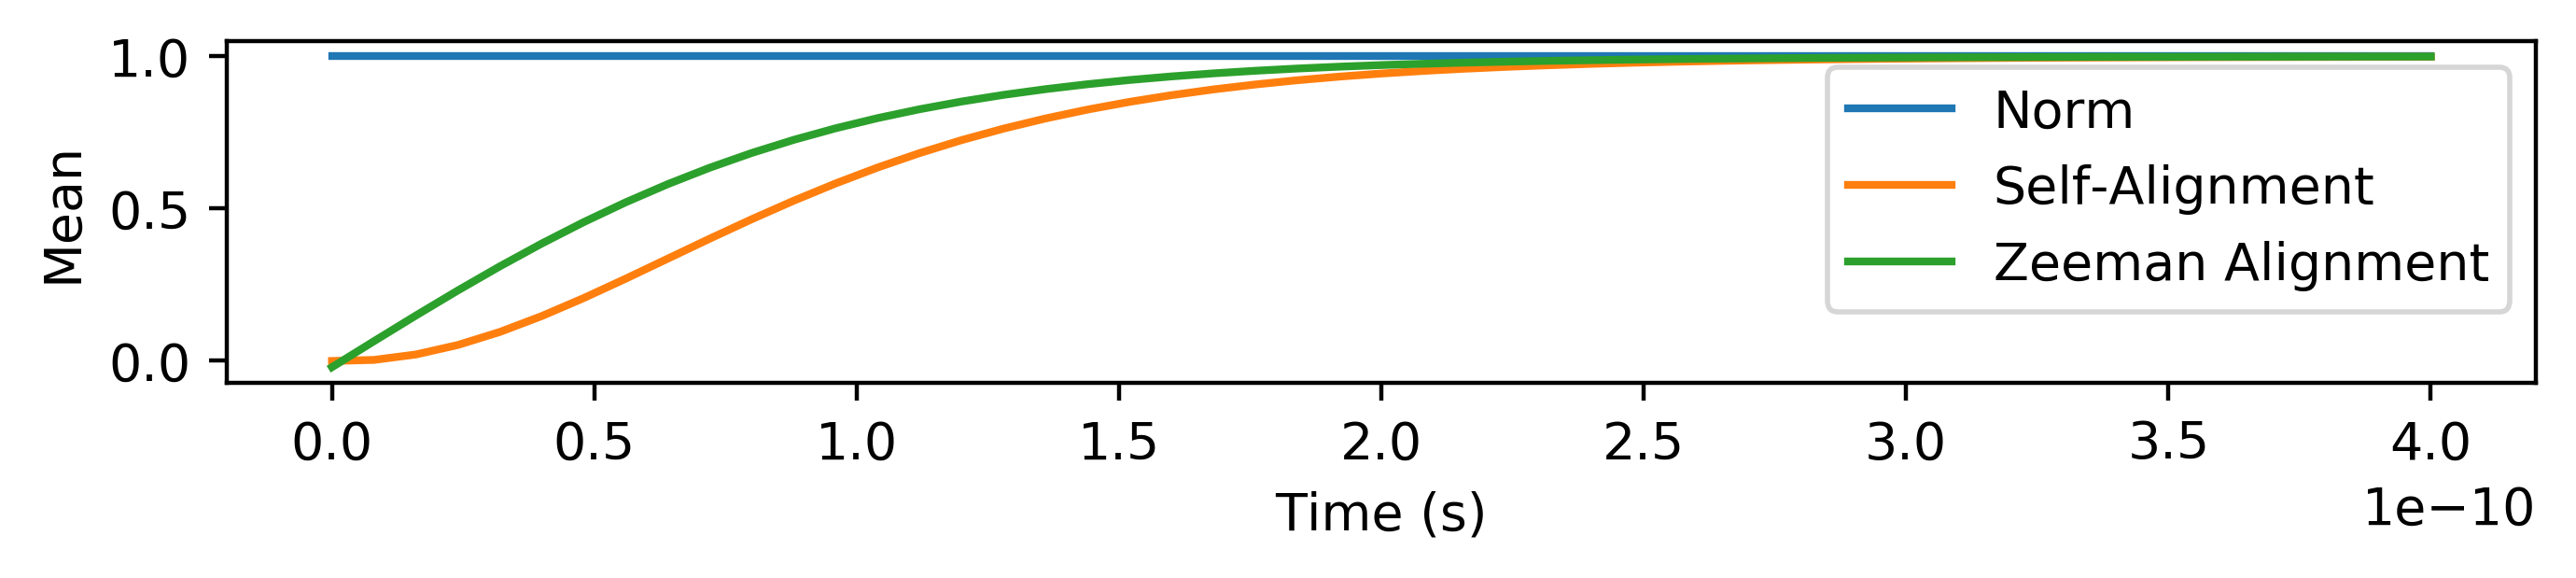

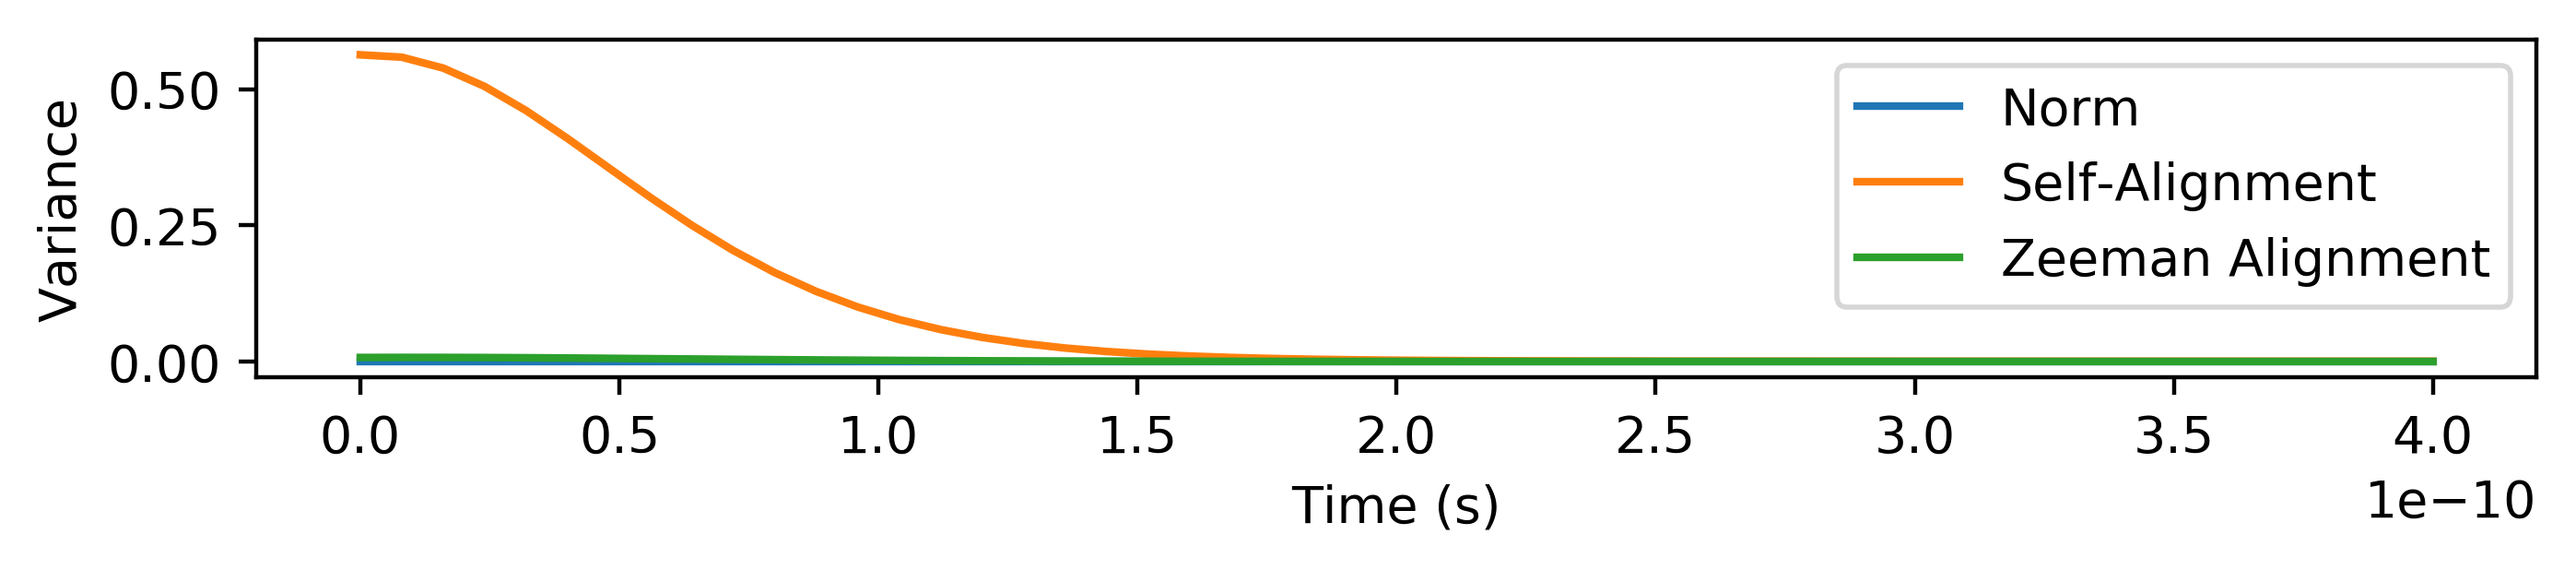

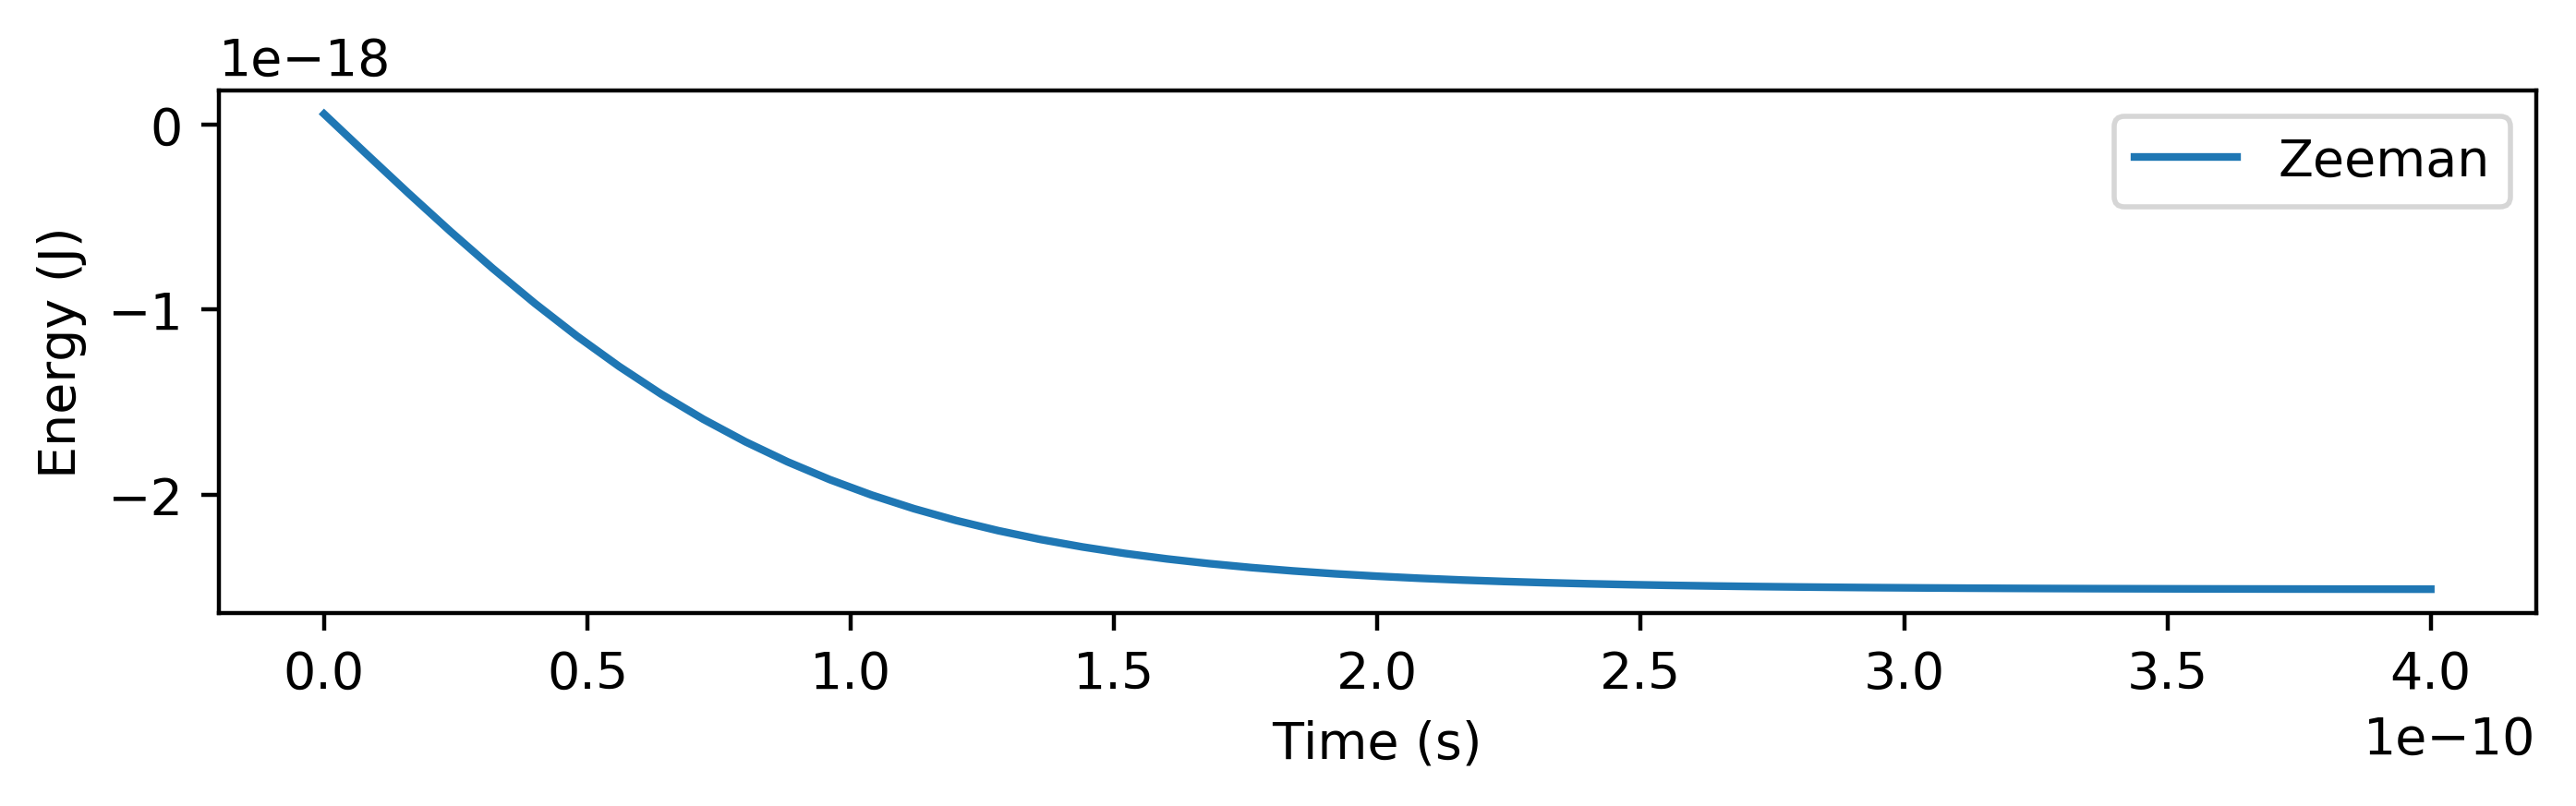

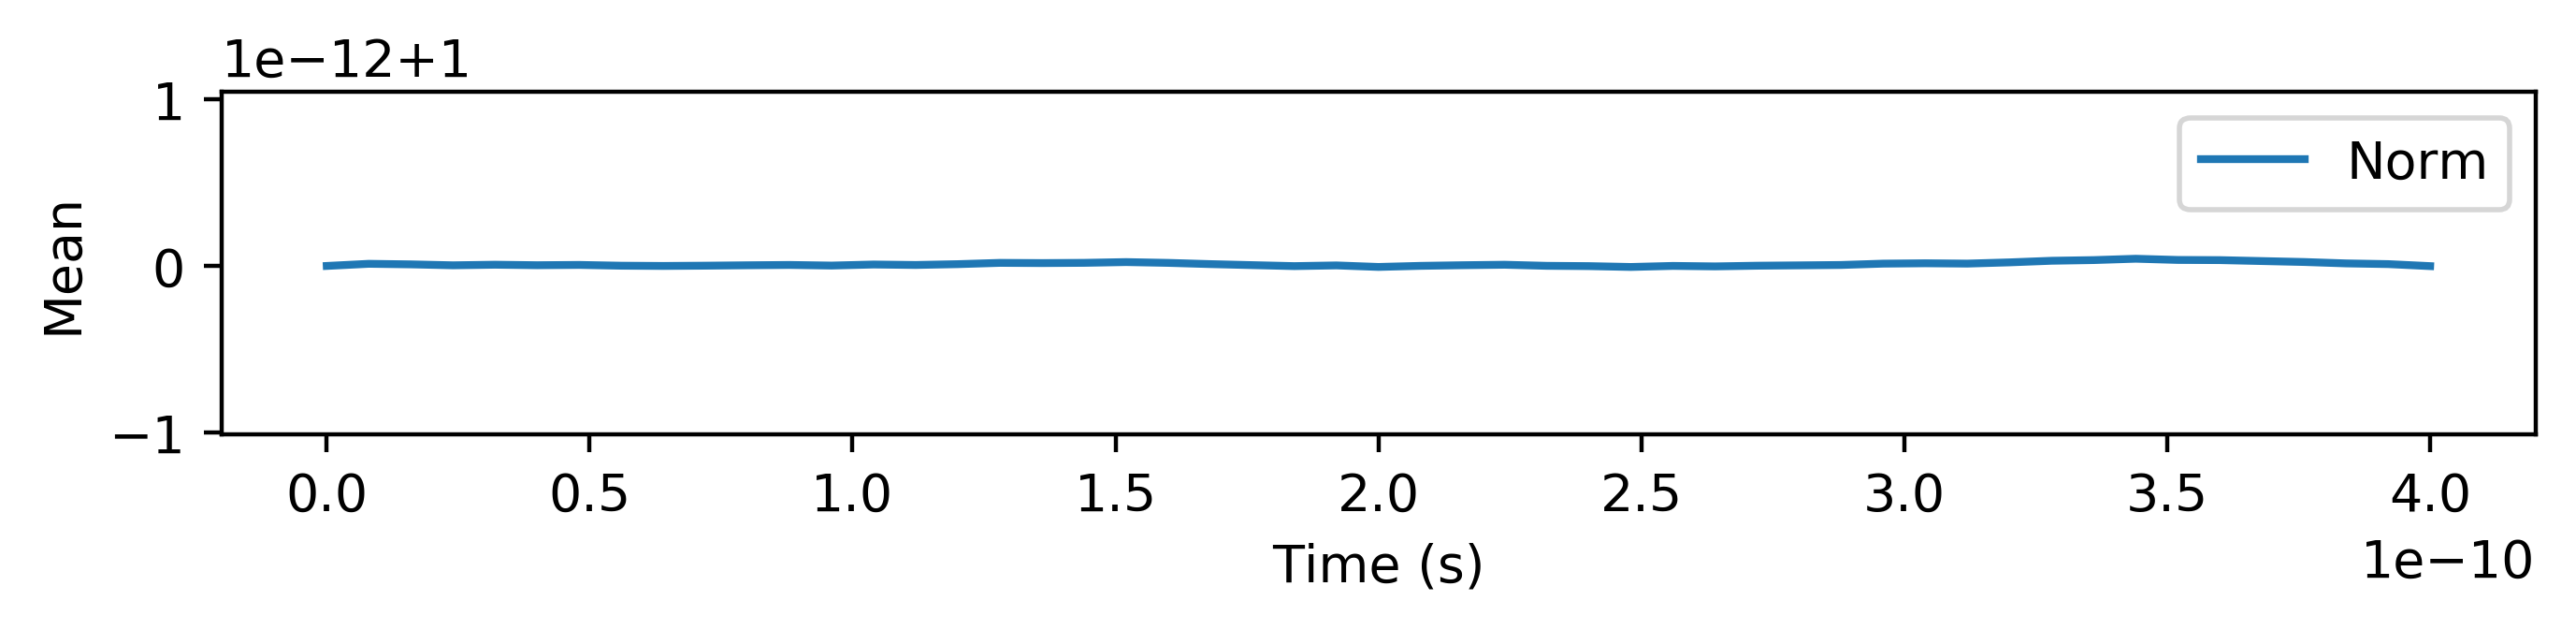

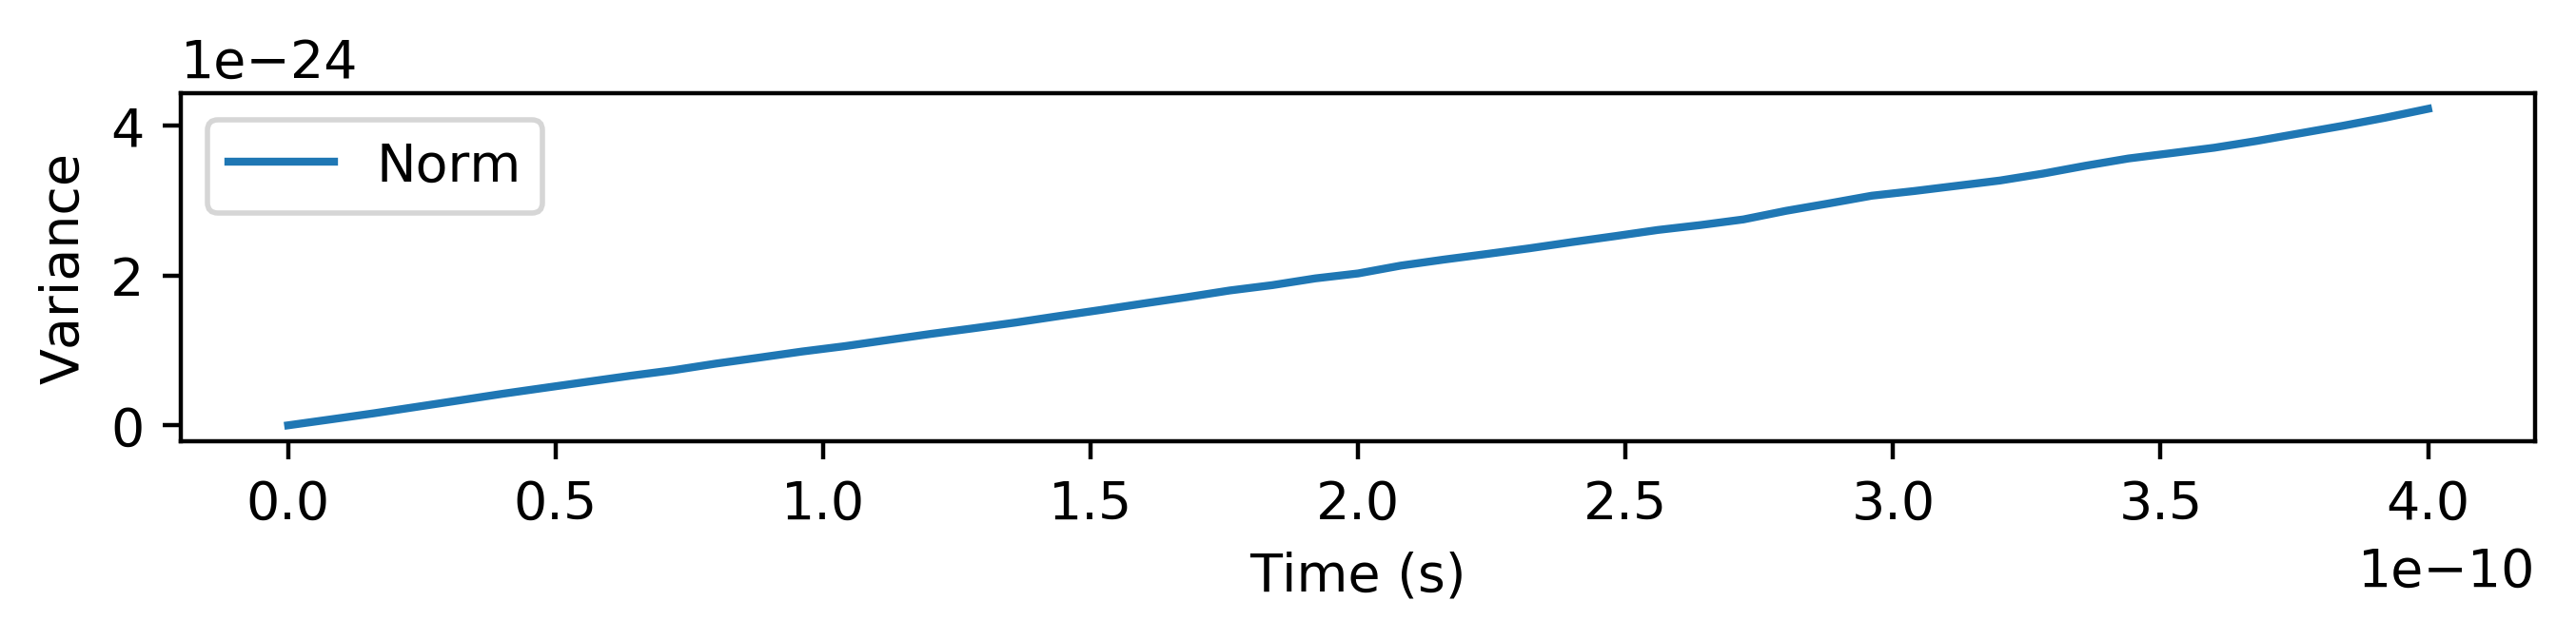

Devito
testing_40000/Devito_Zeeman


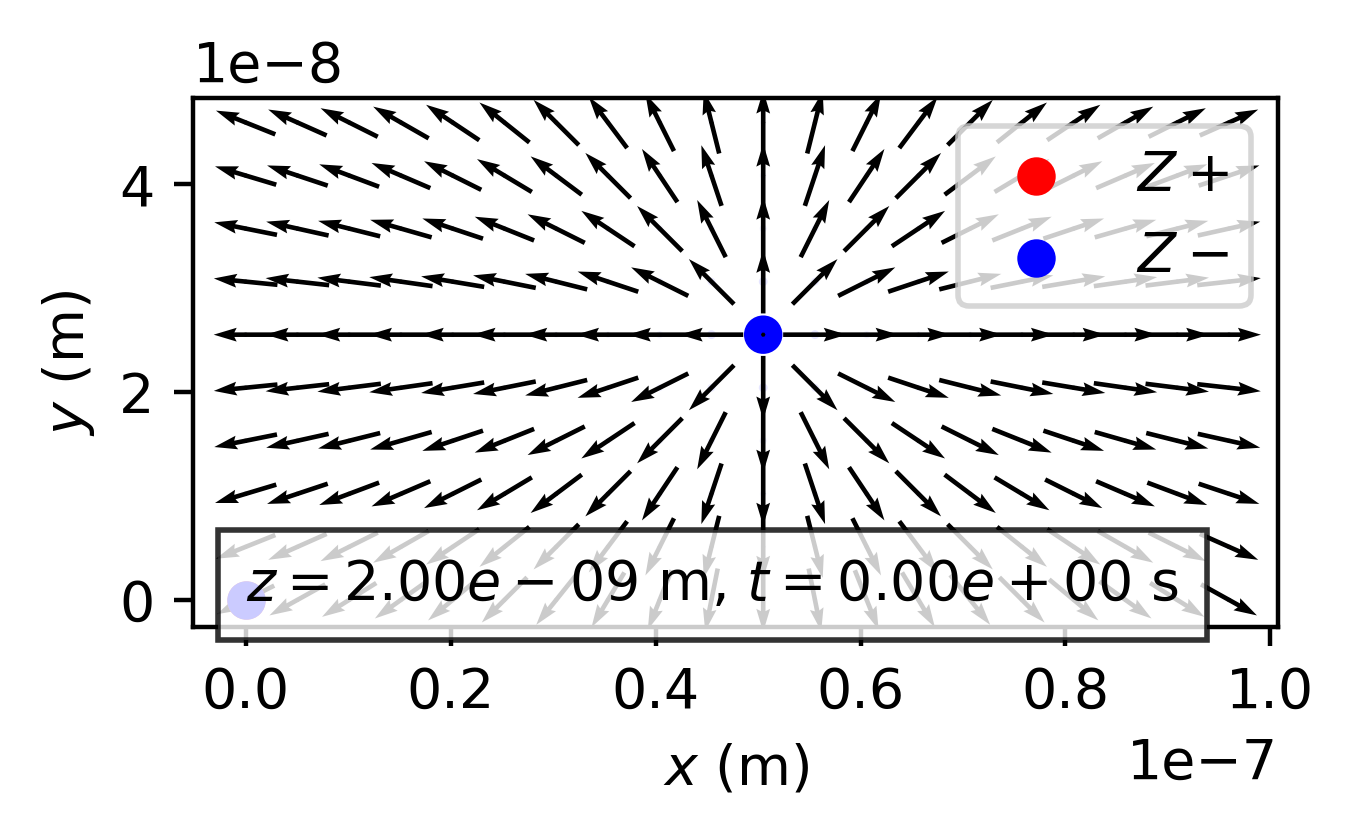

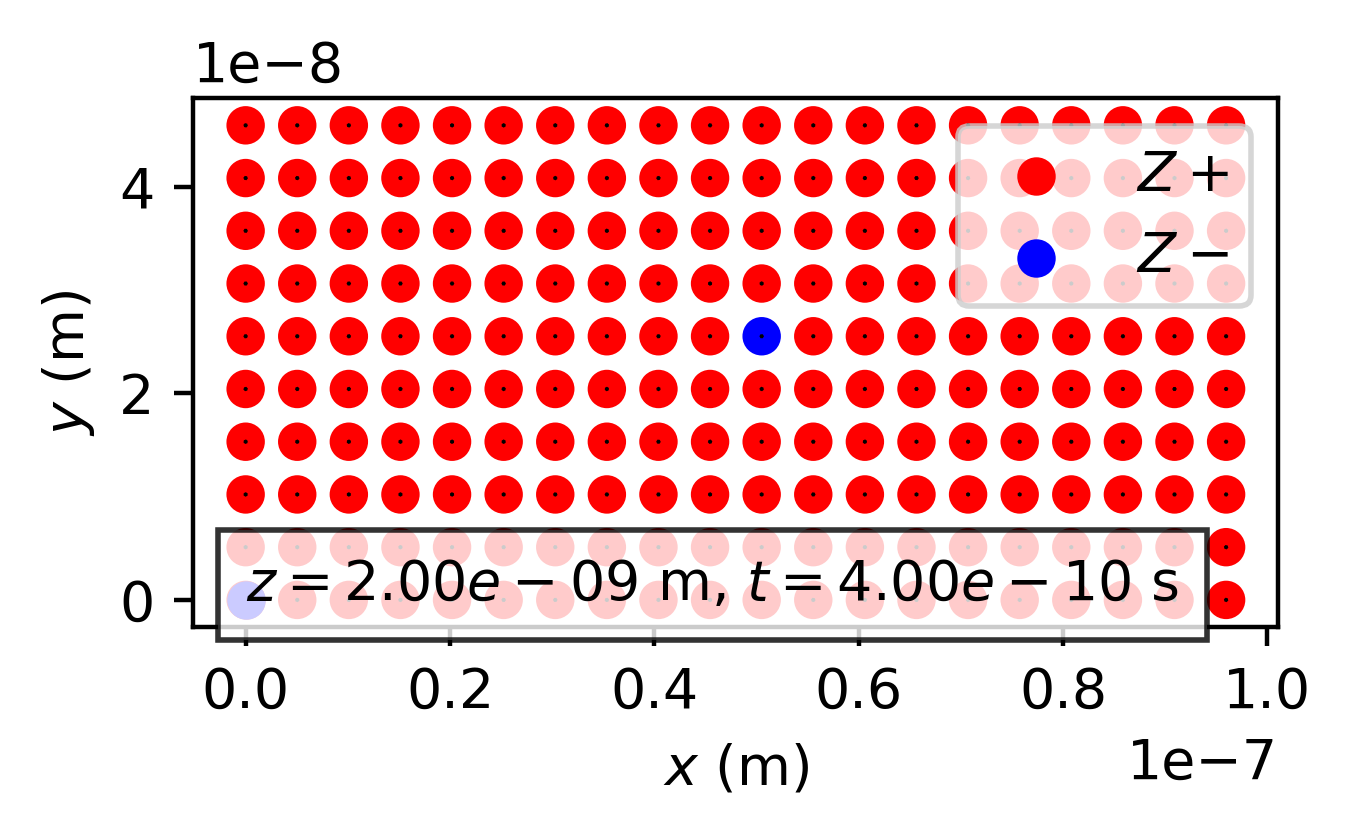

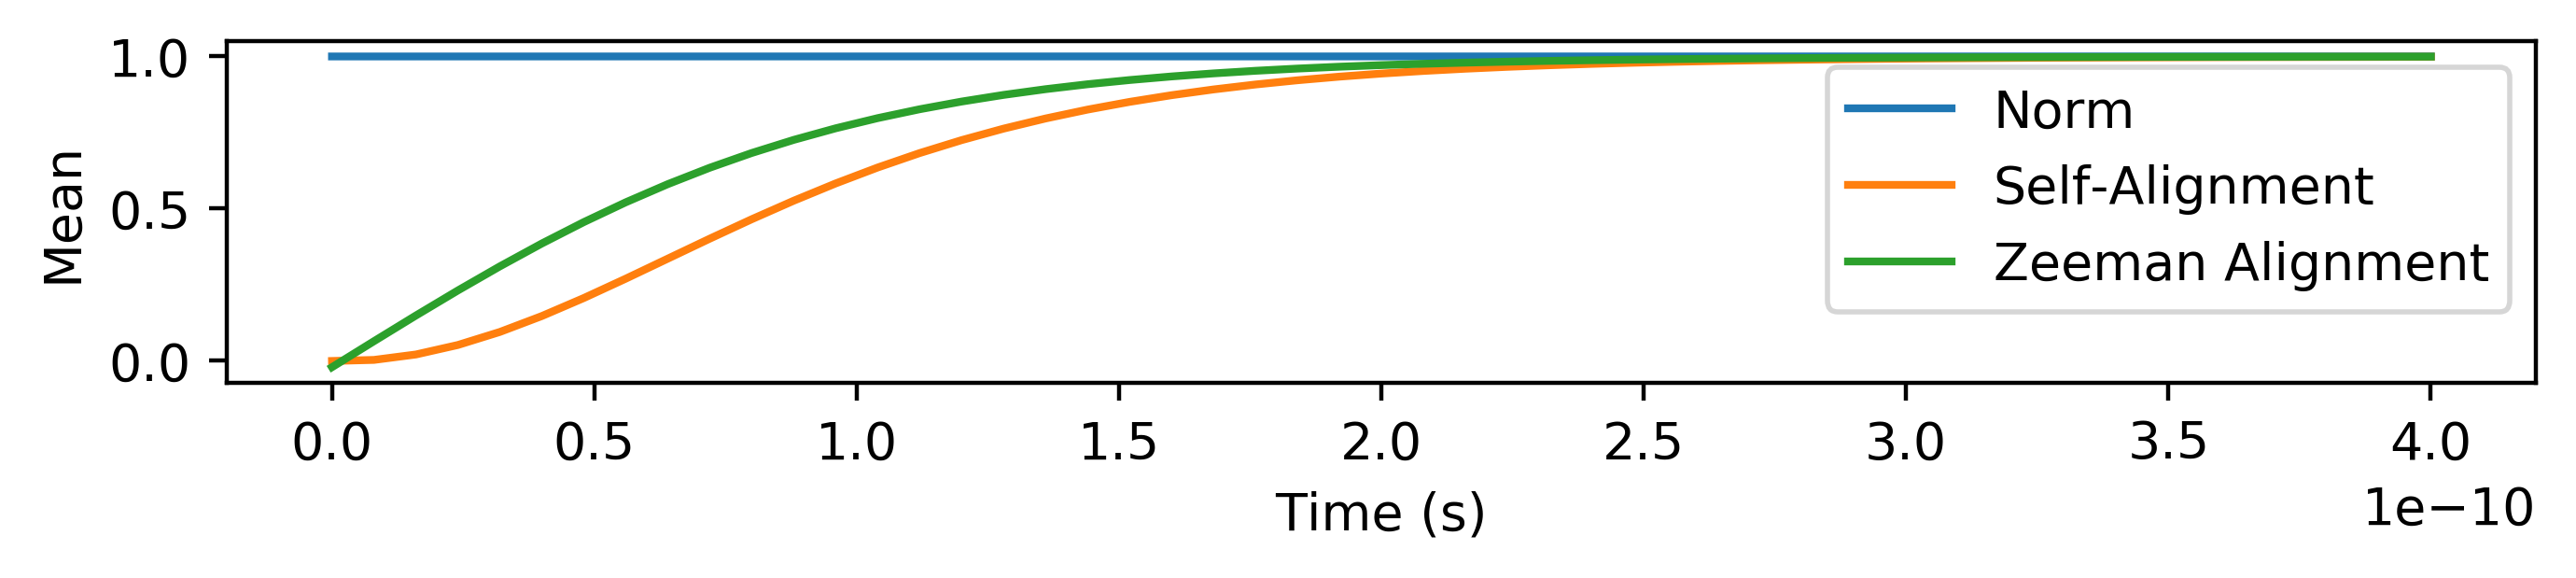

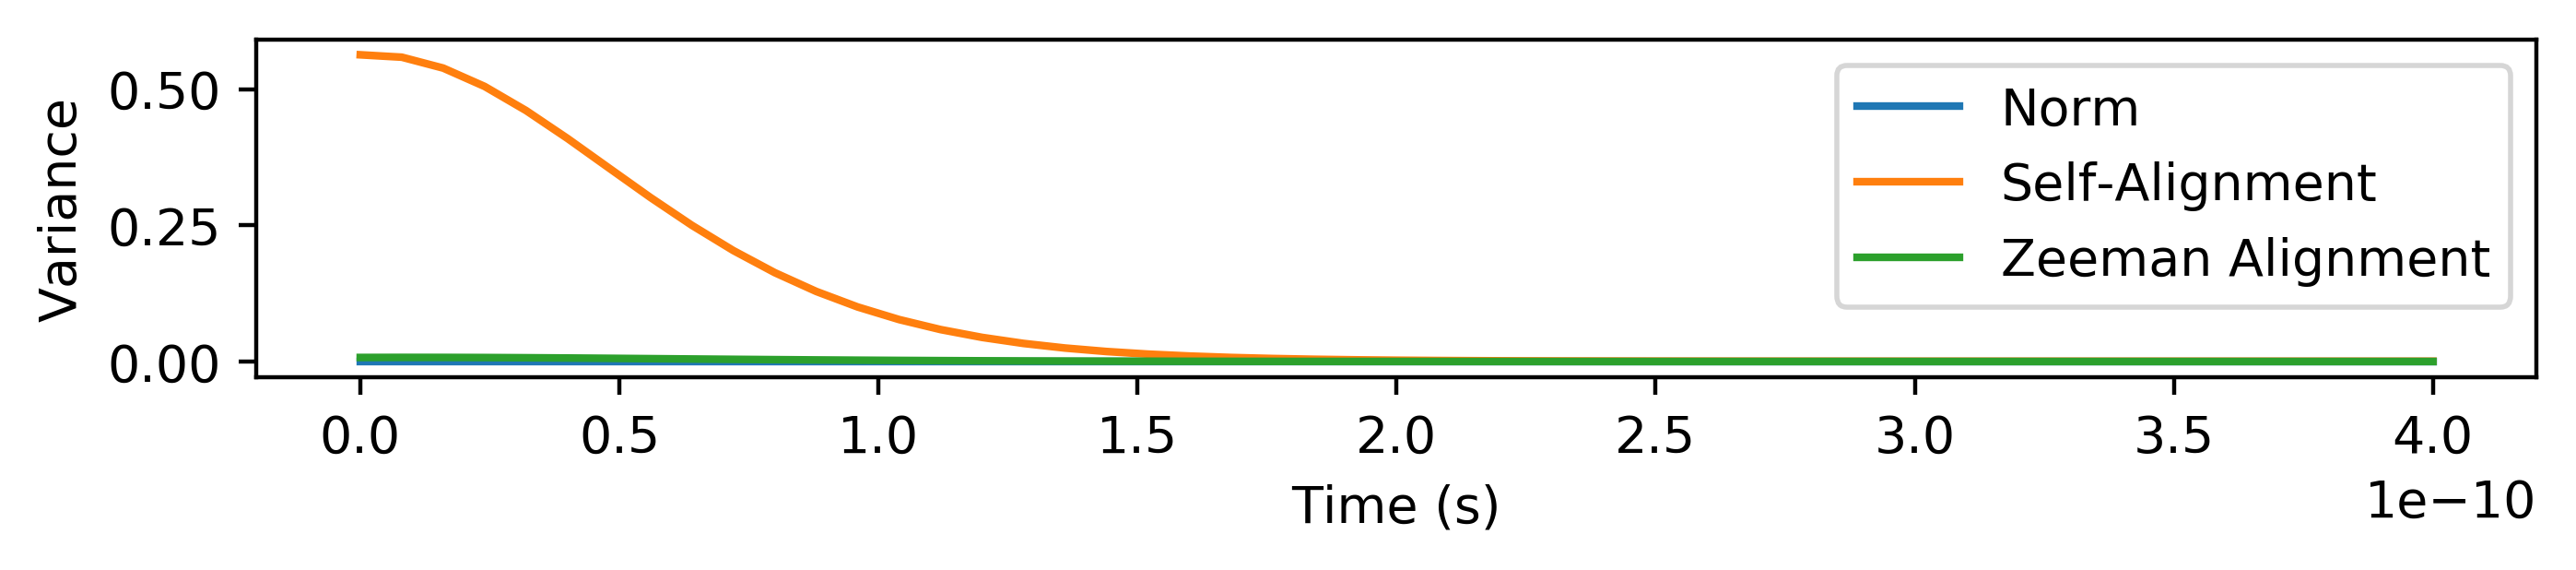

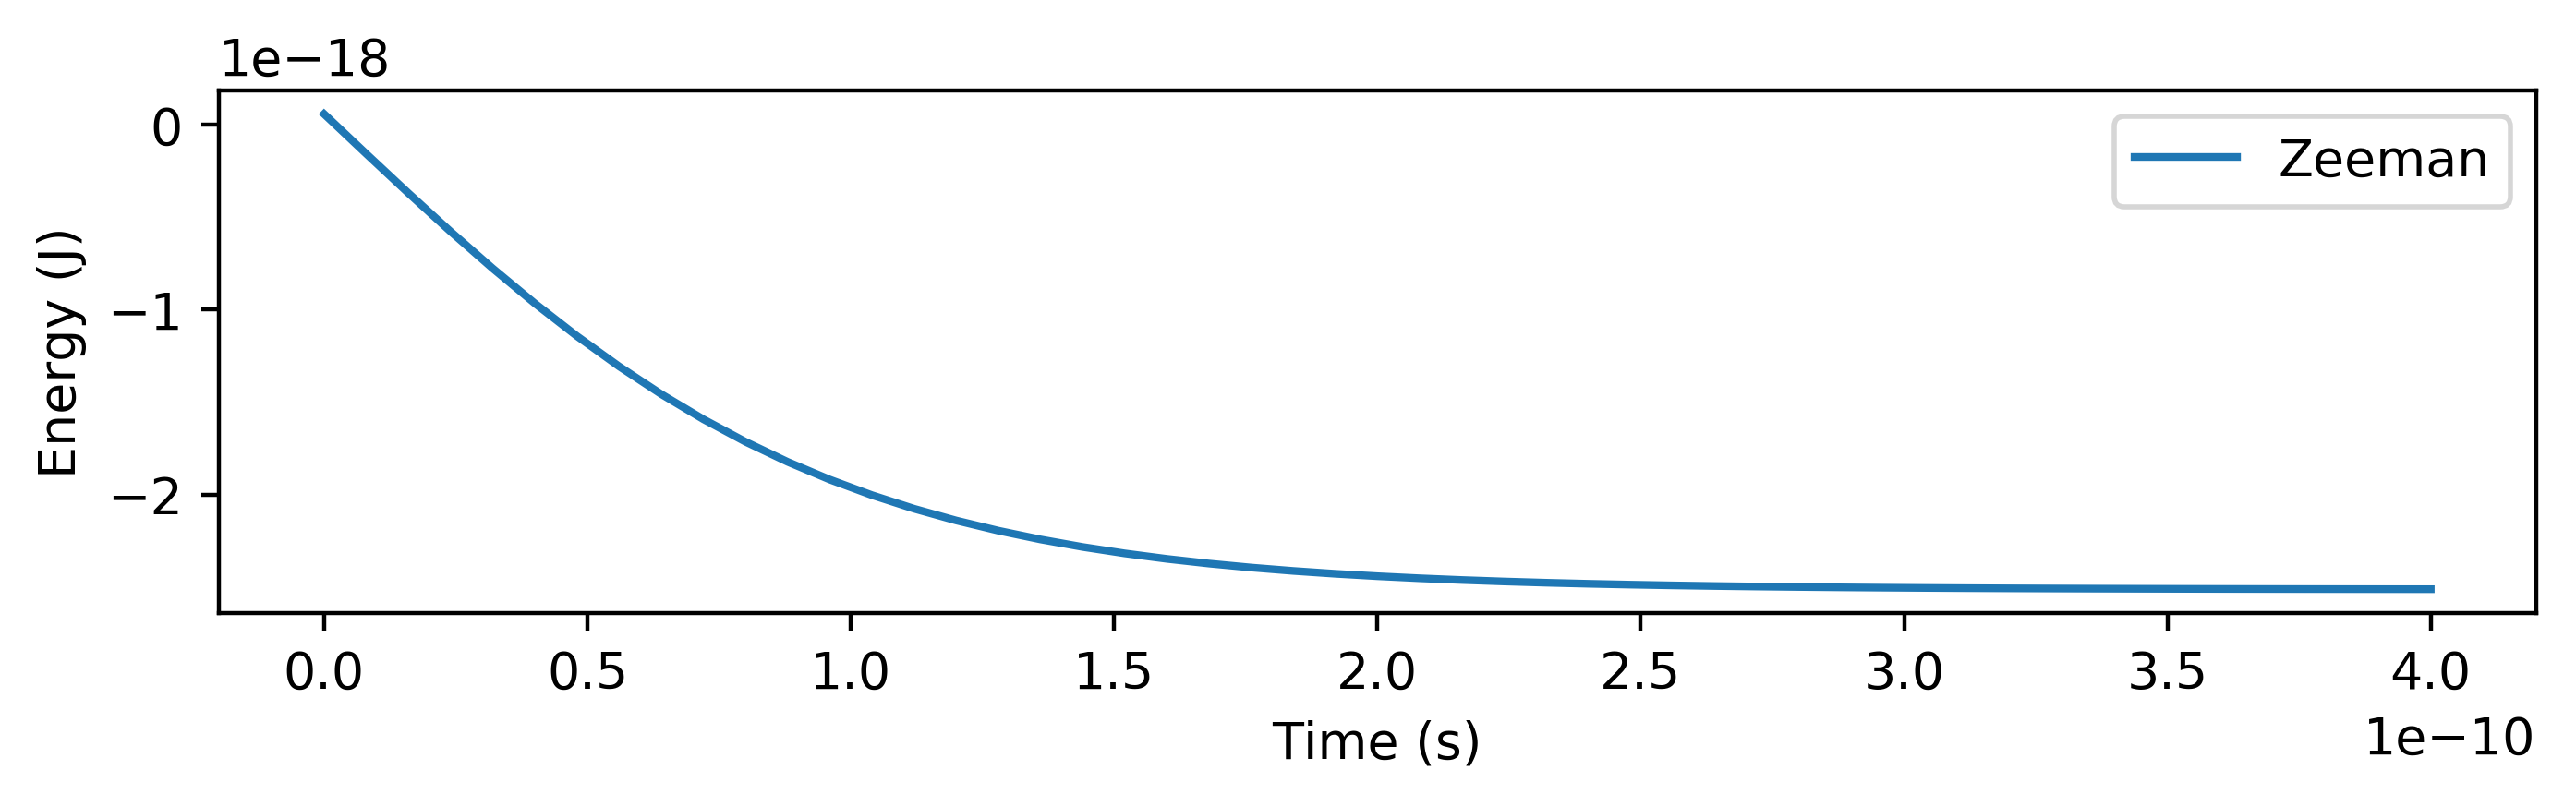

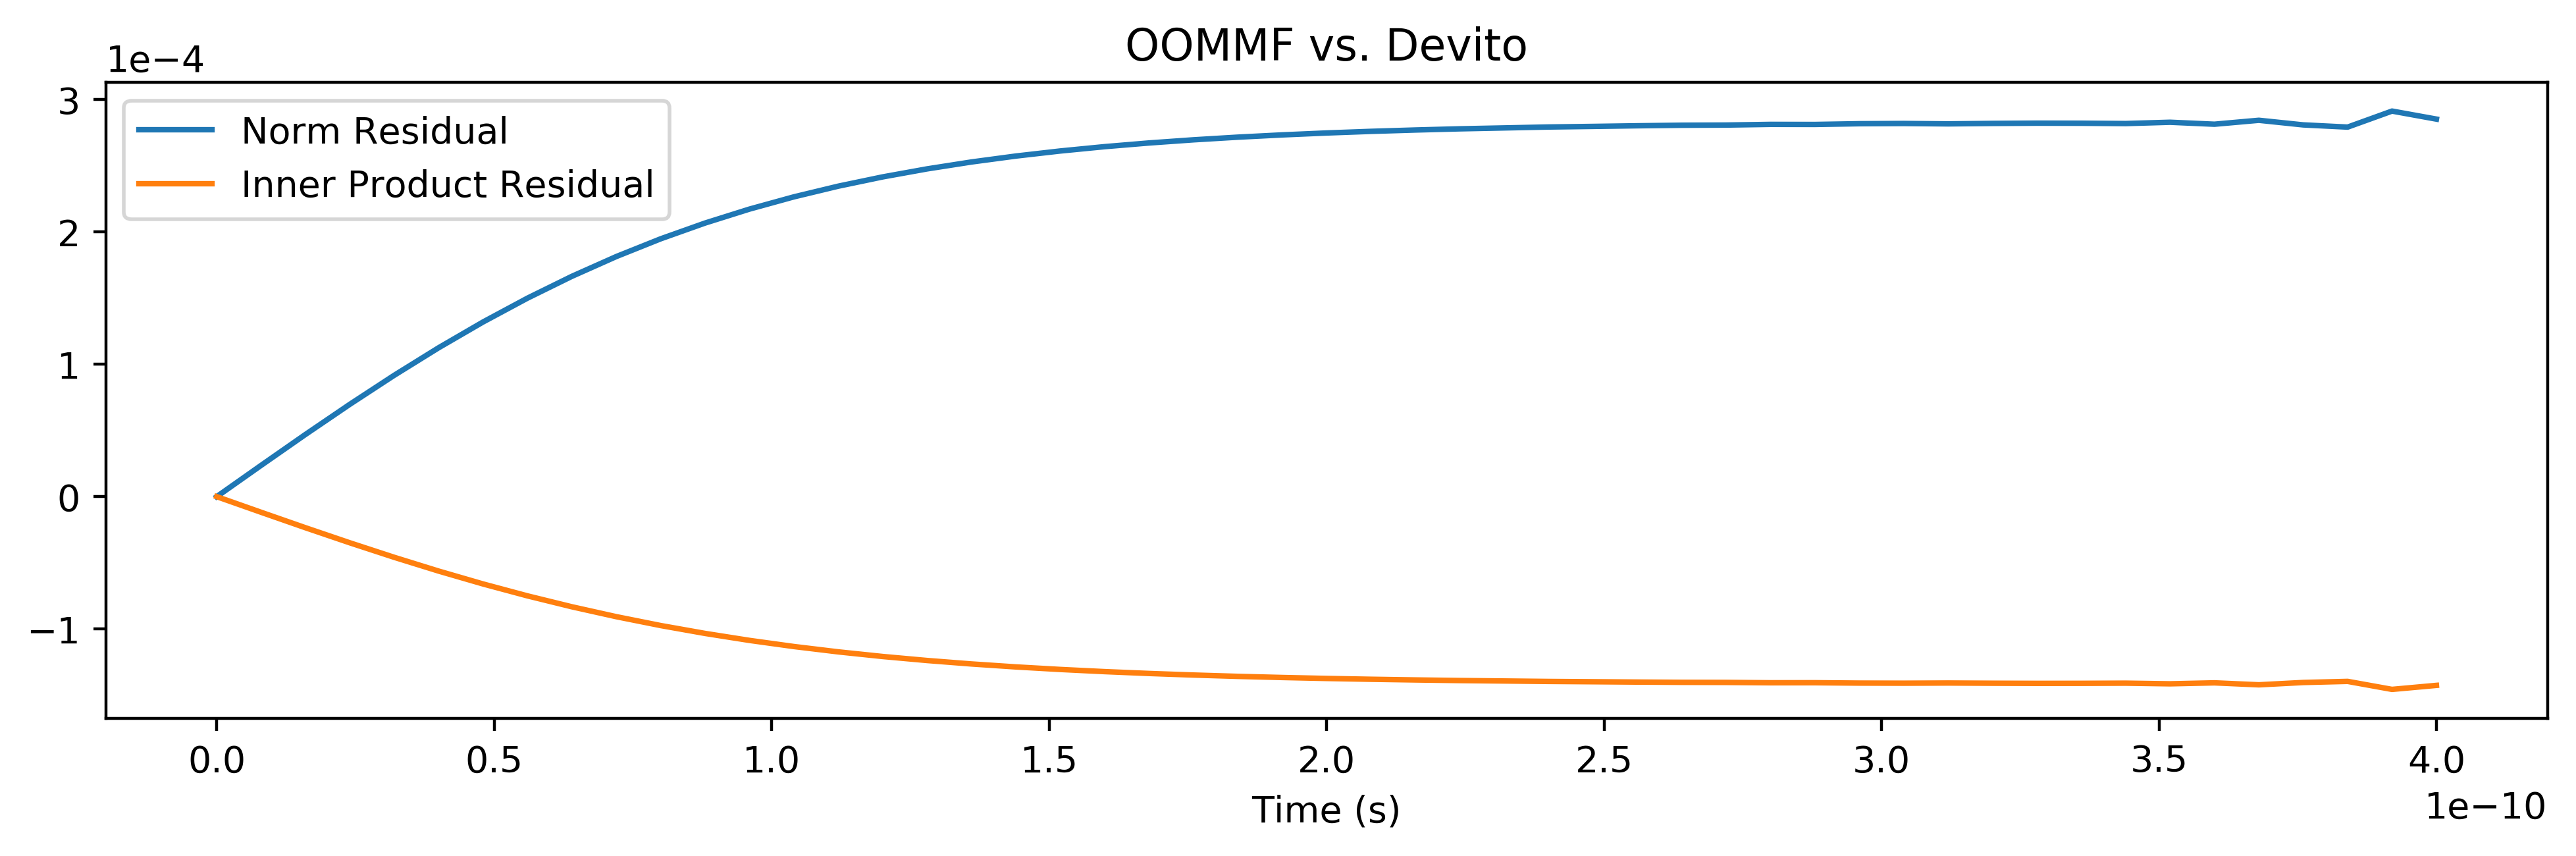

OOMMF
testing_40000/OOMMF_Exchange_+_Anisotropy_+_Zeeman


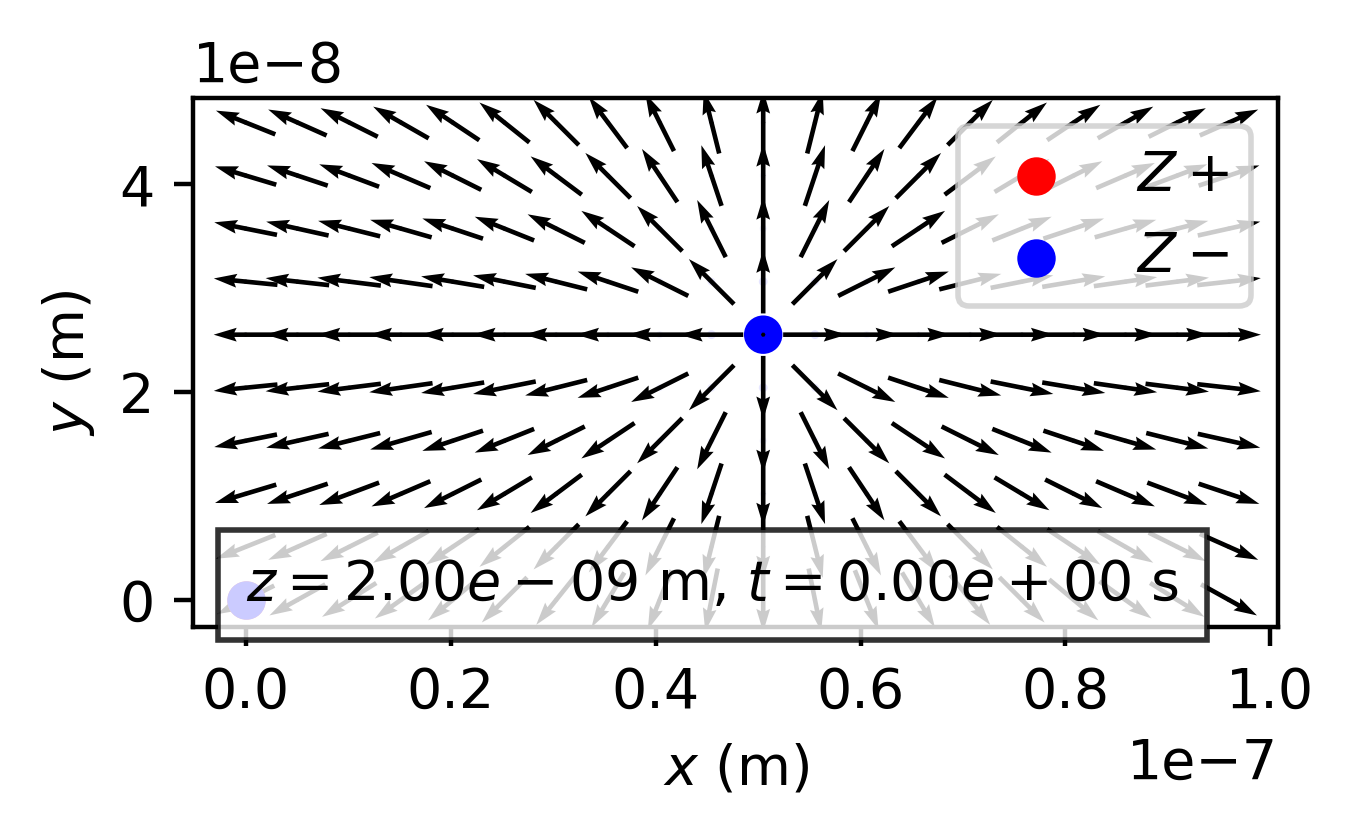

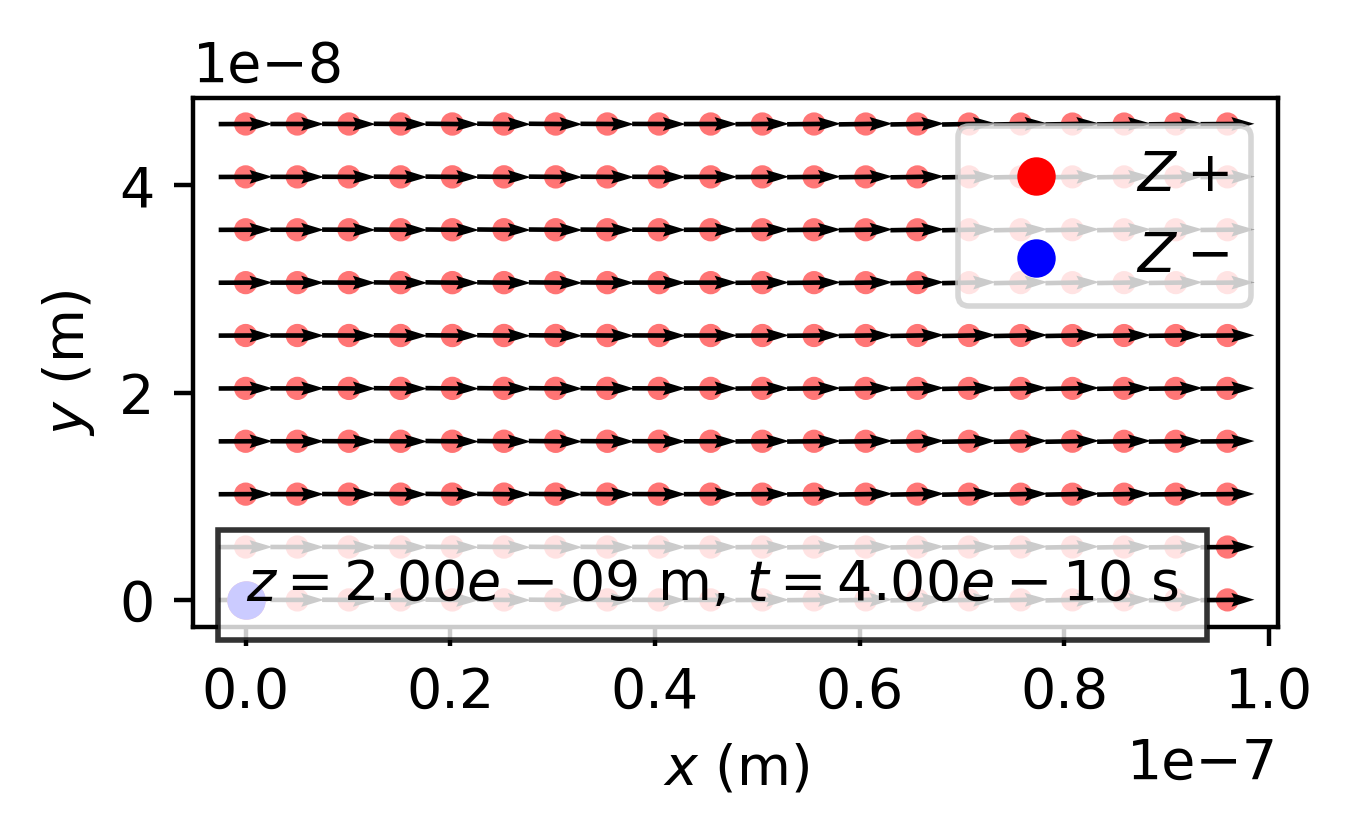

something


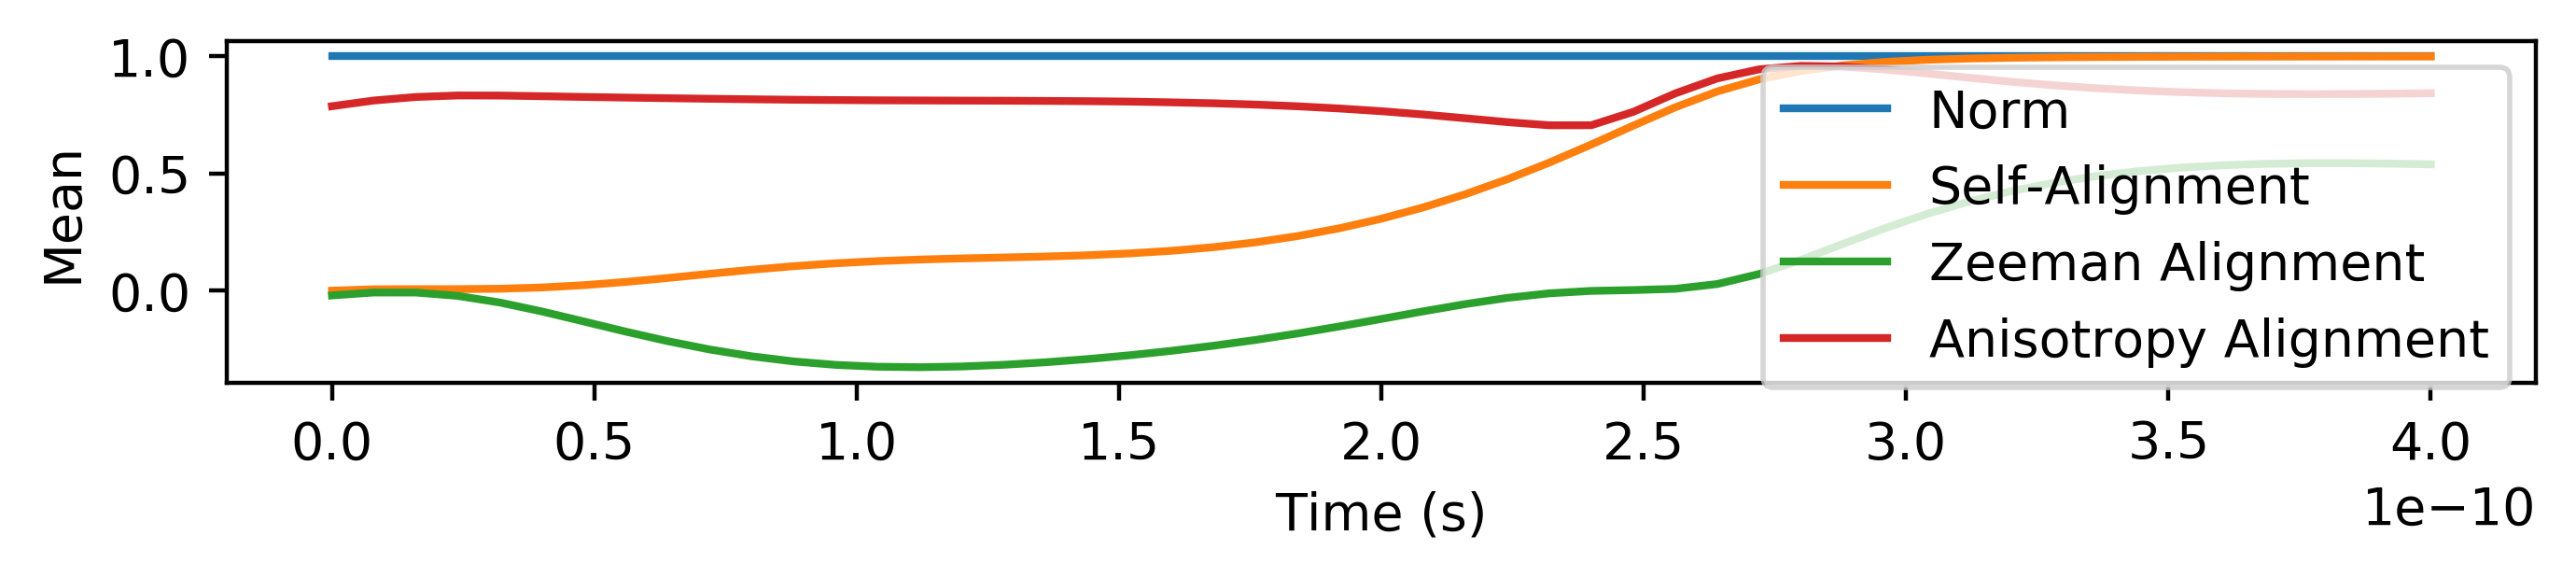

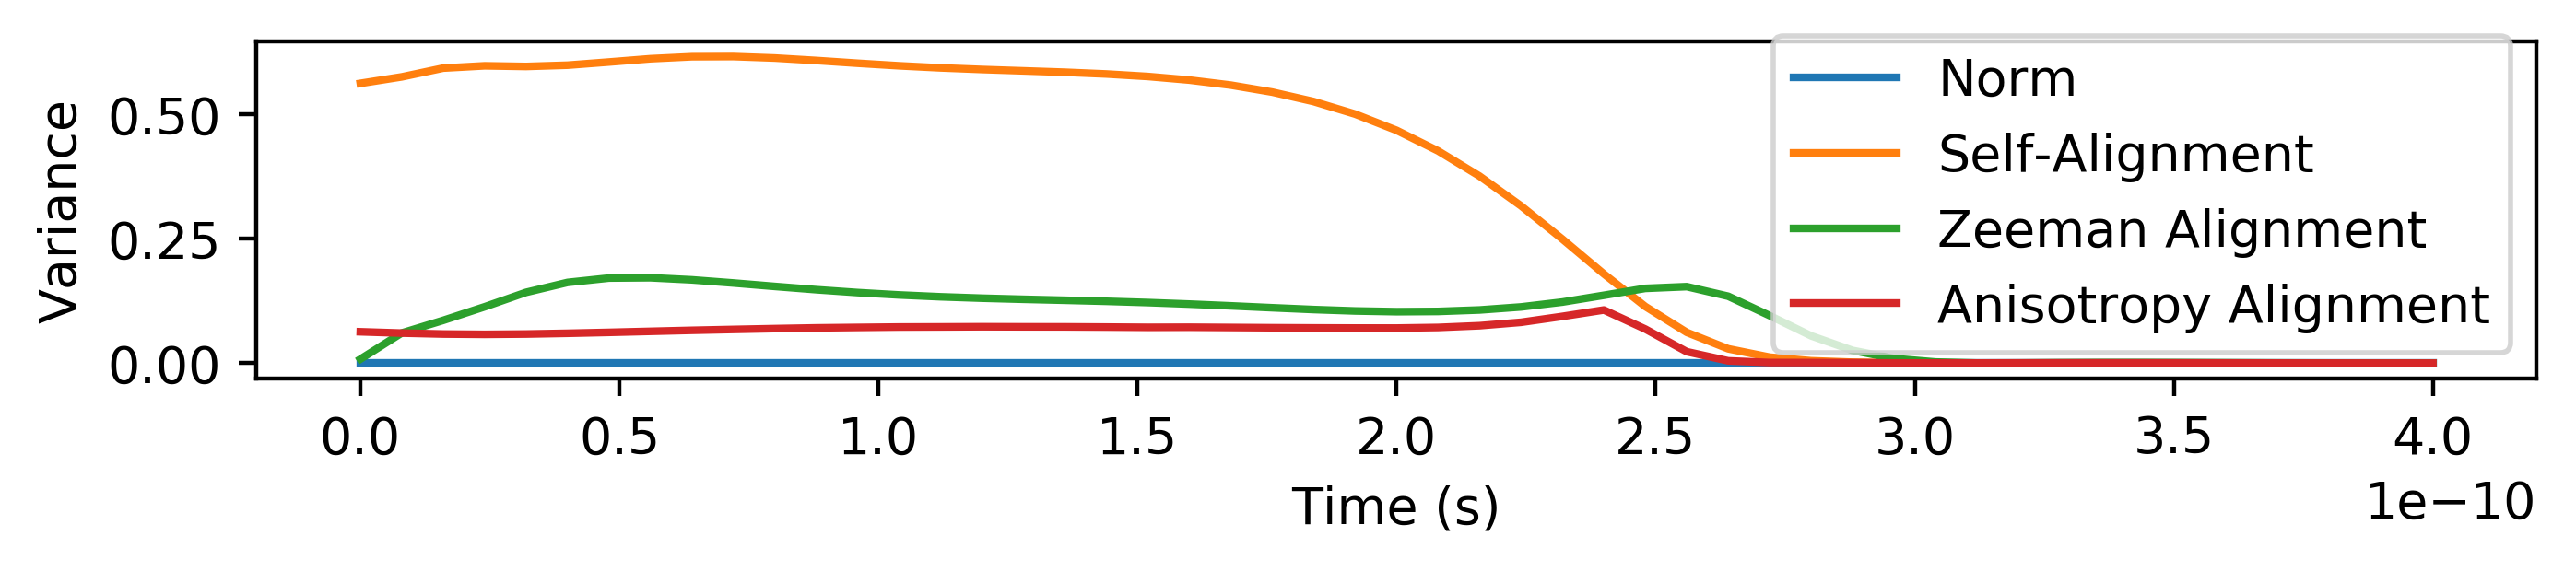

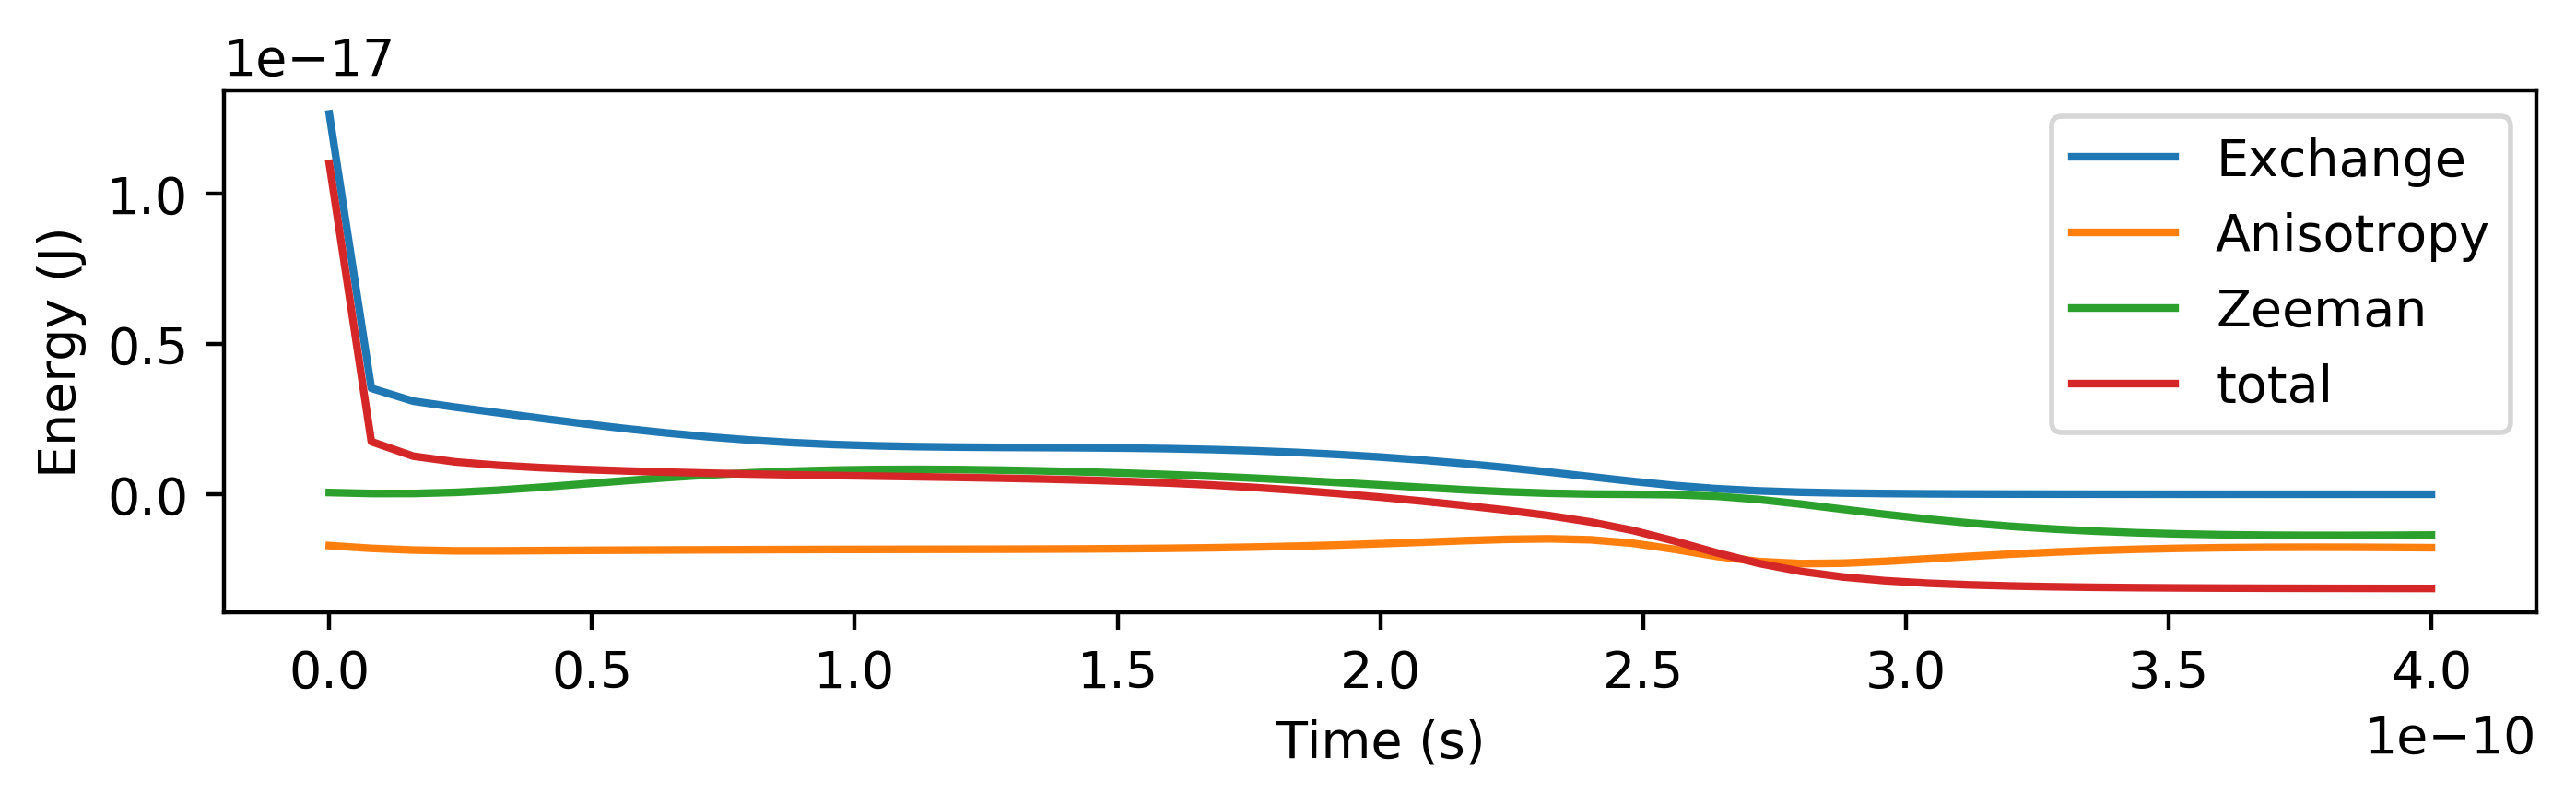

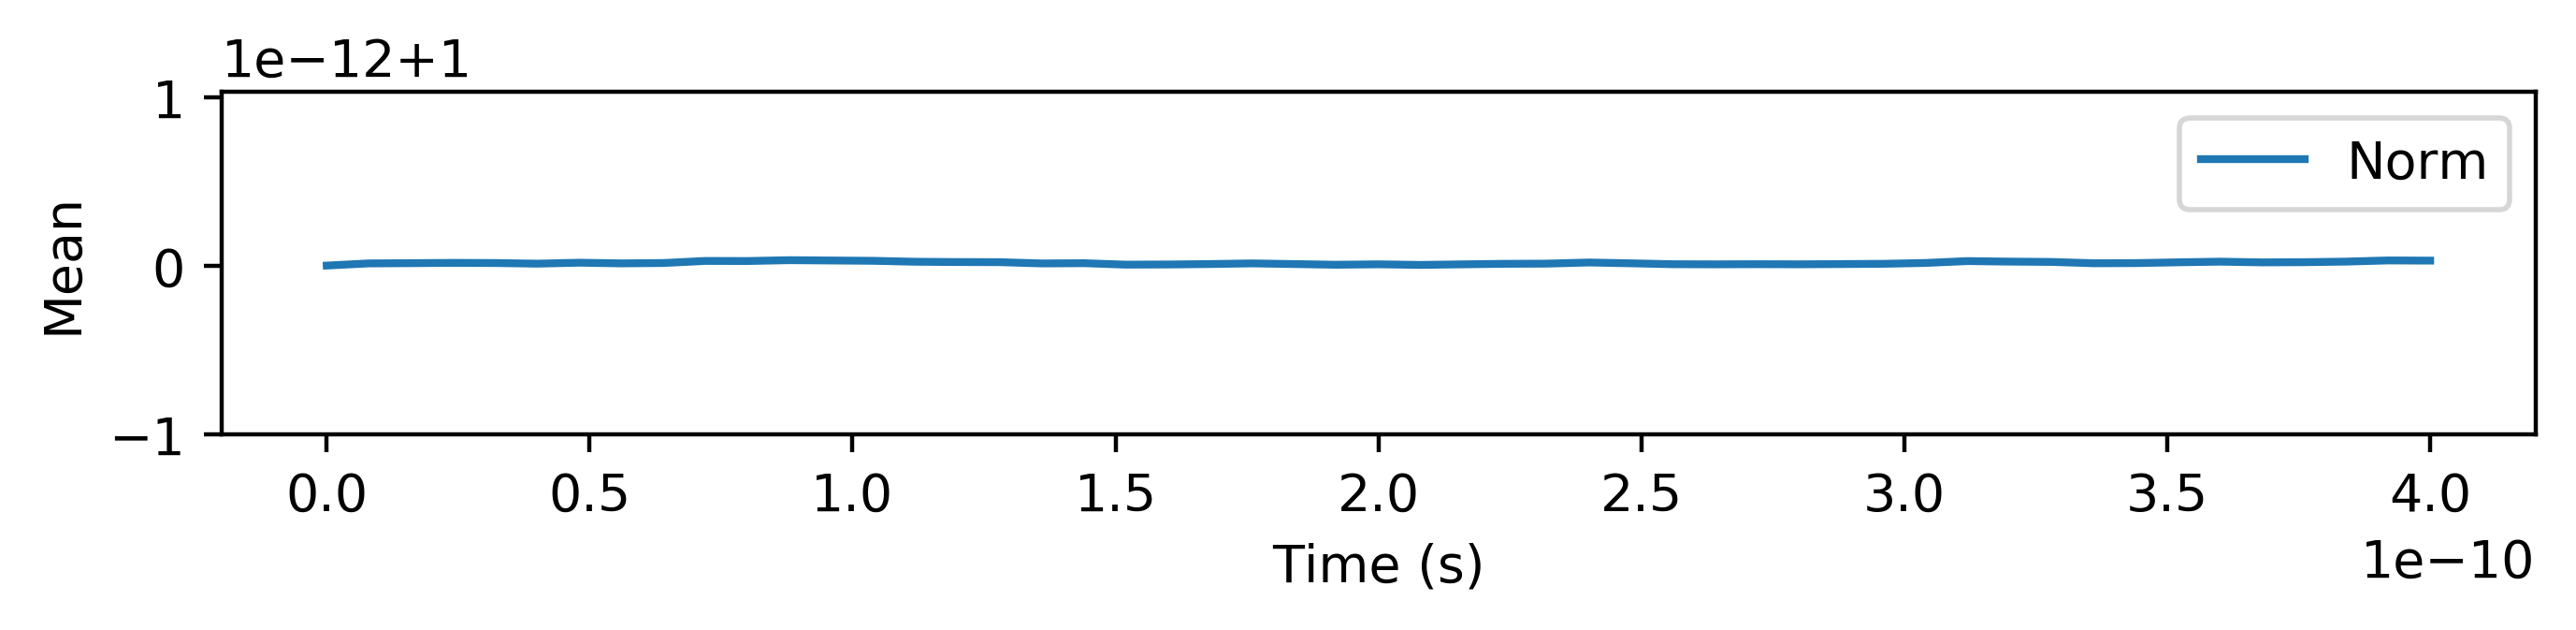

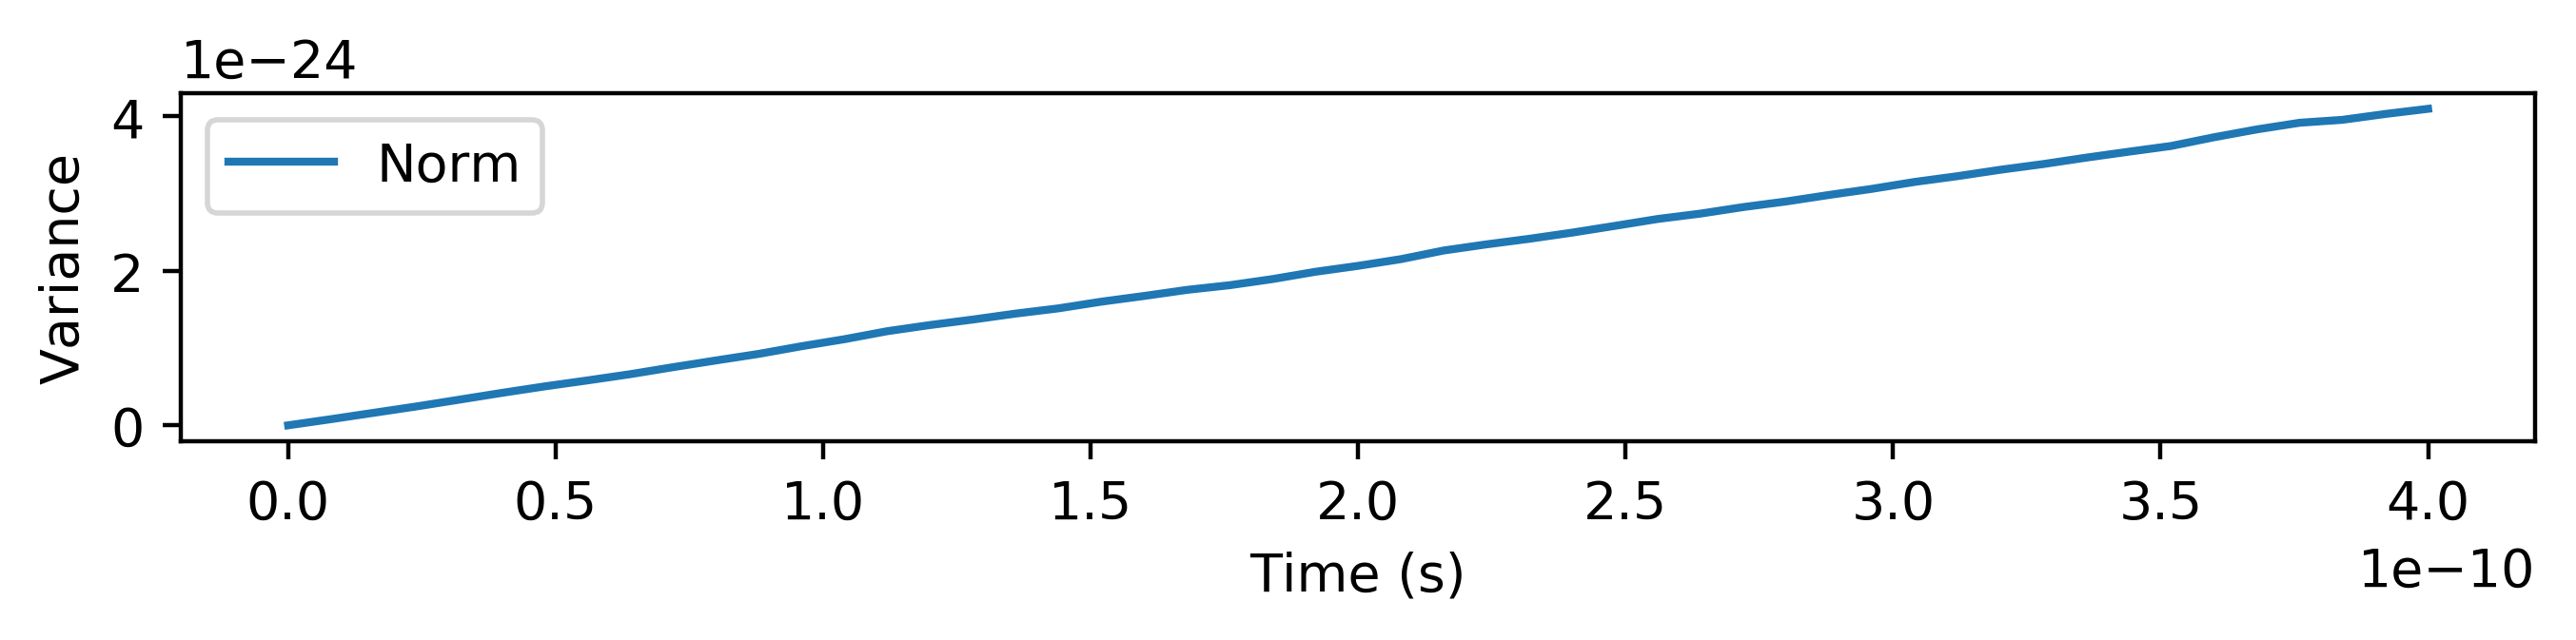

OpenSBLI
testing_40000/OpenSBLI_Exchange_+_Anisotropy_+_Zeeman


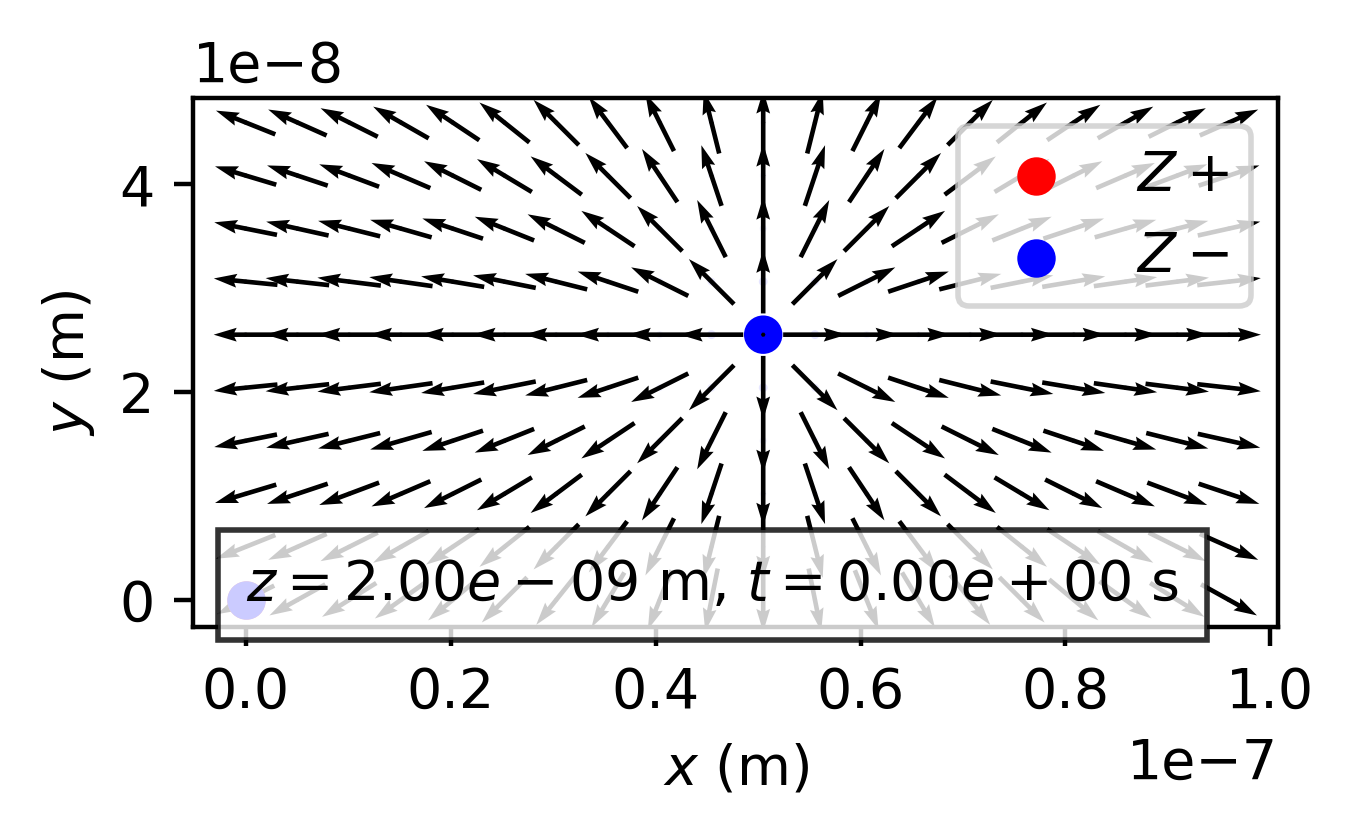

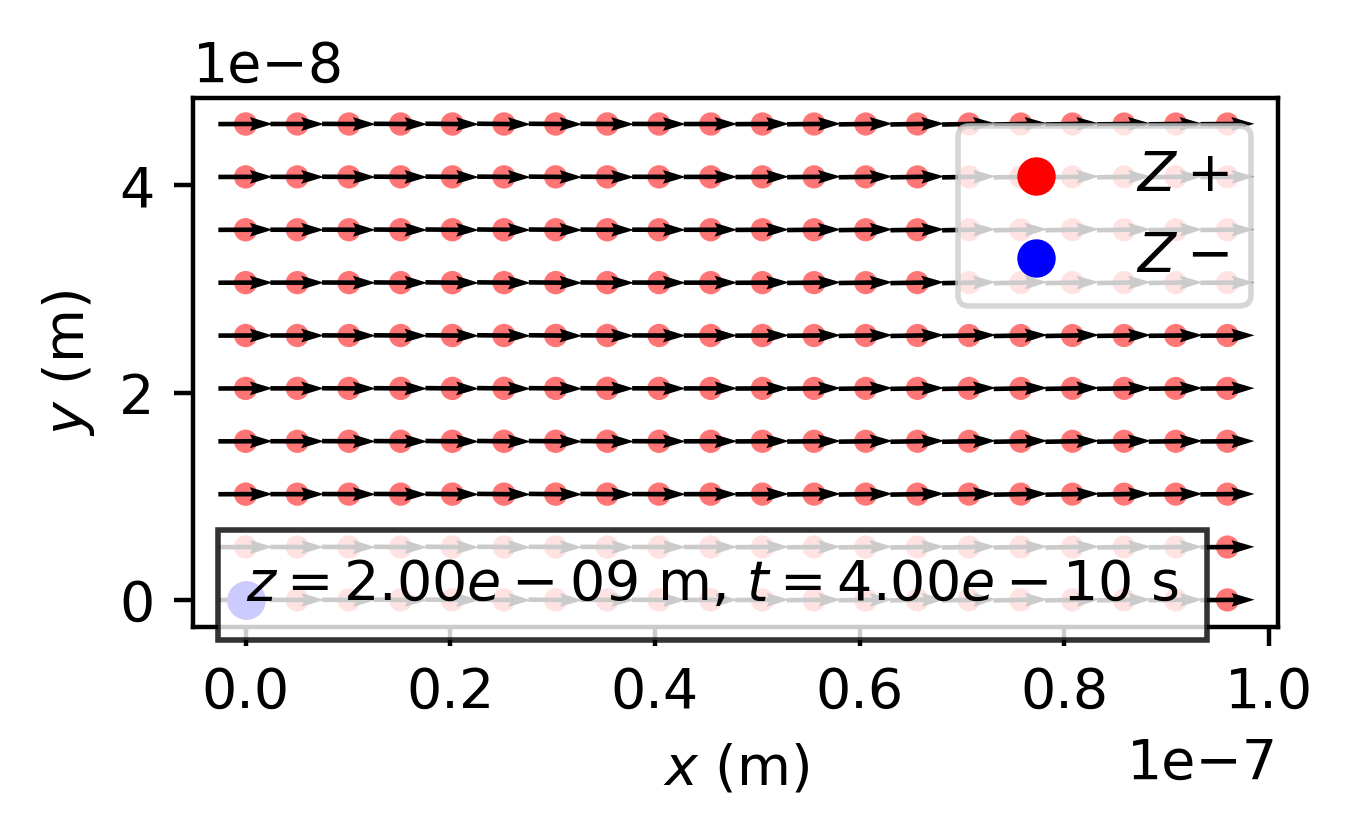

something


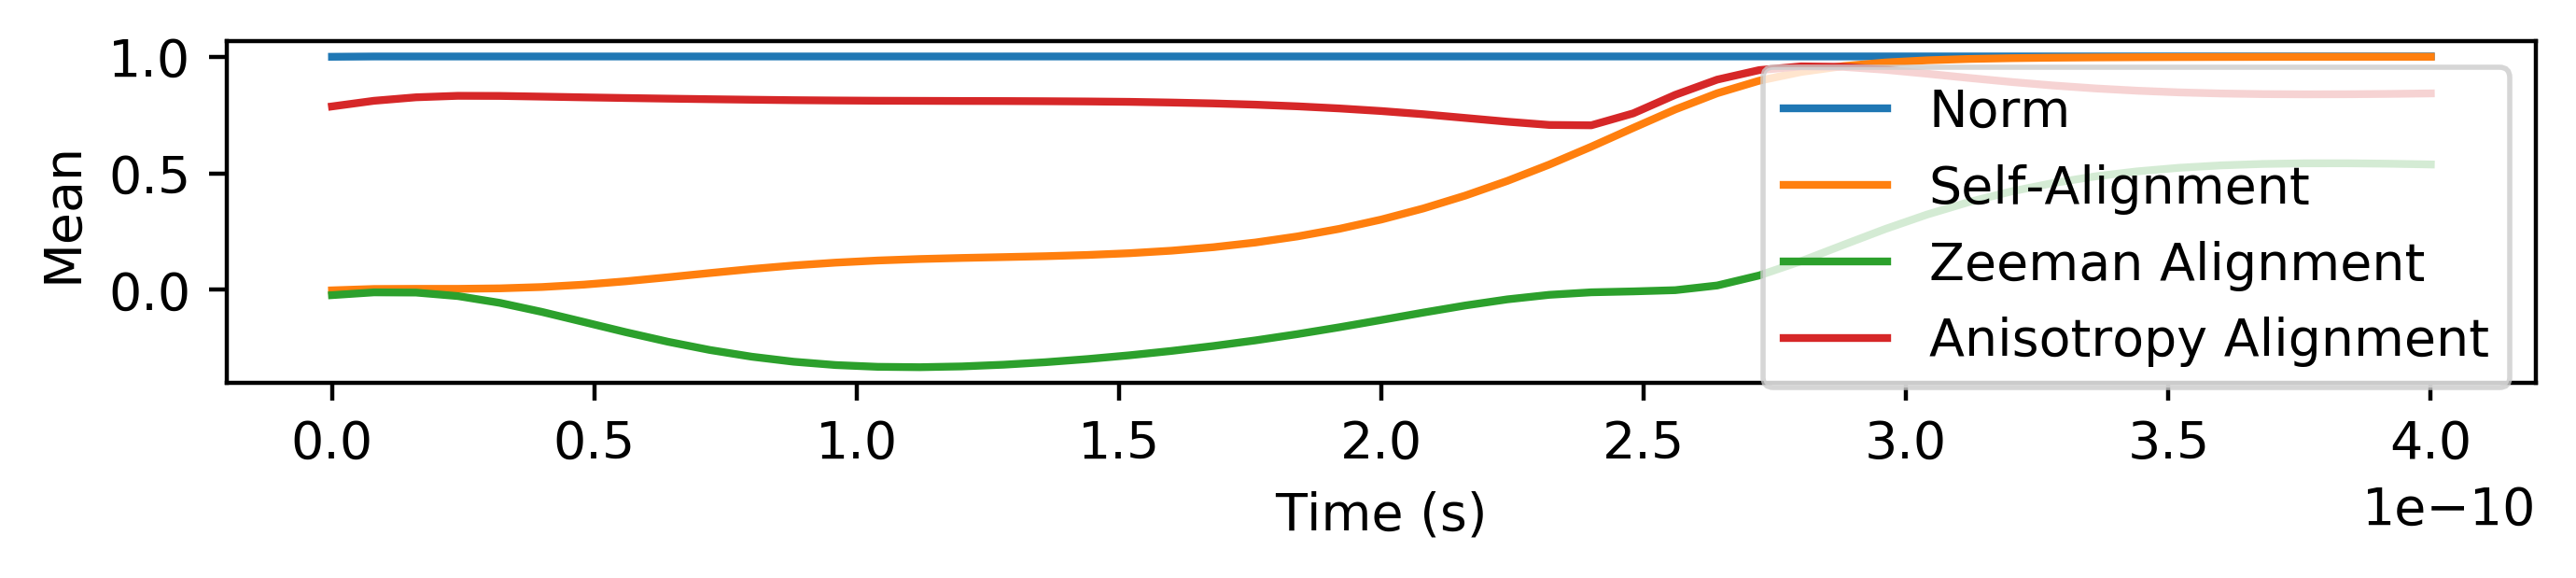

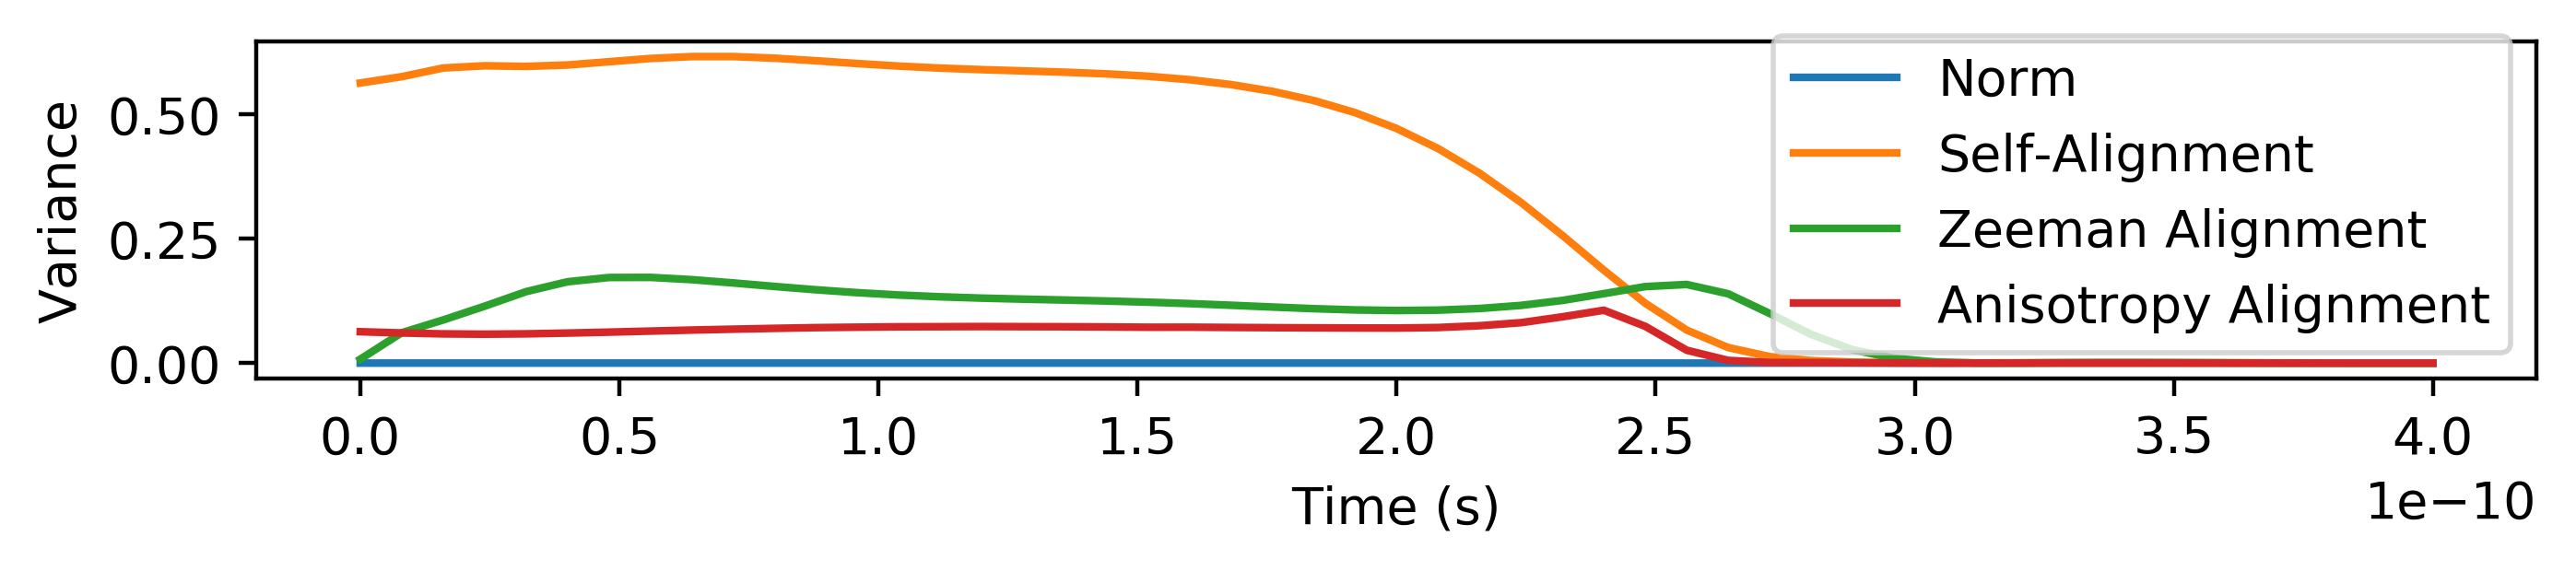

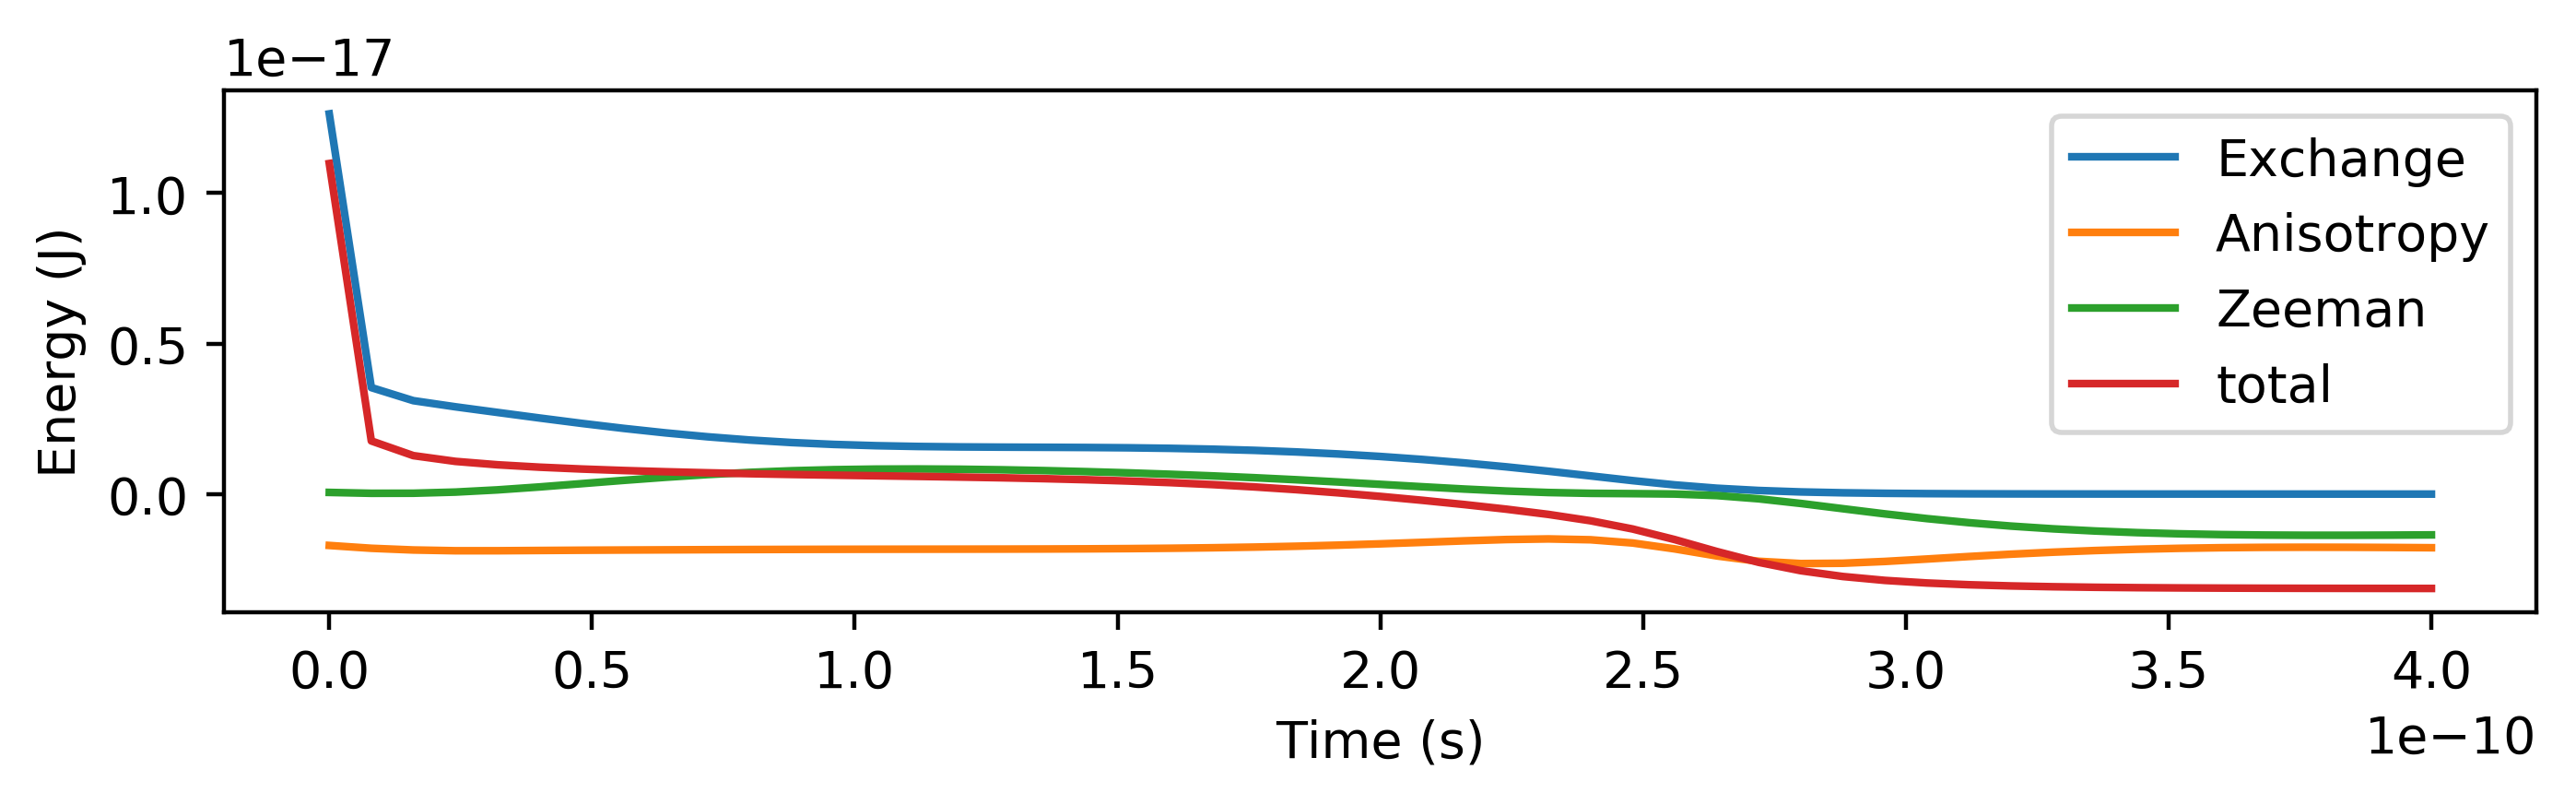

Devito
testing_40000/Devito_Exchange_+_Anisotropy_+_Zeeman


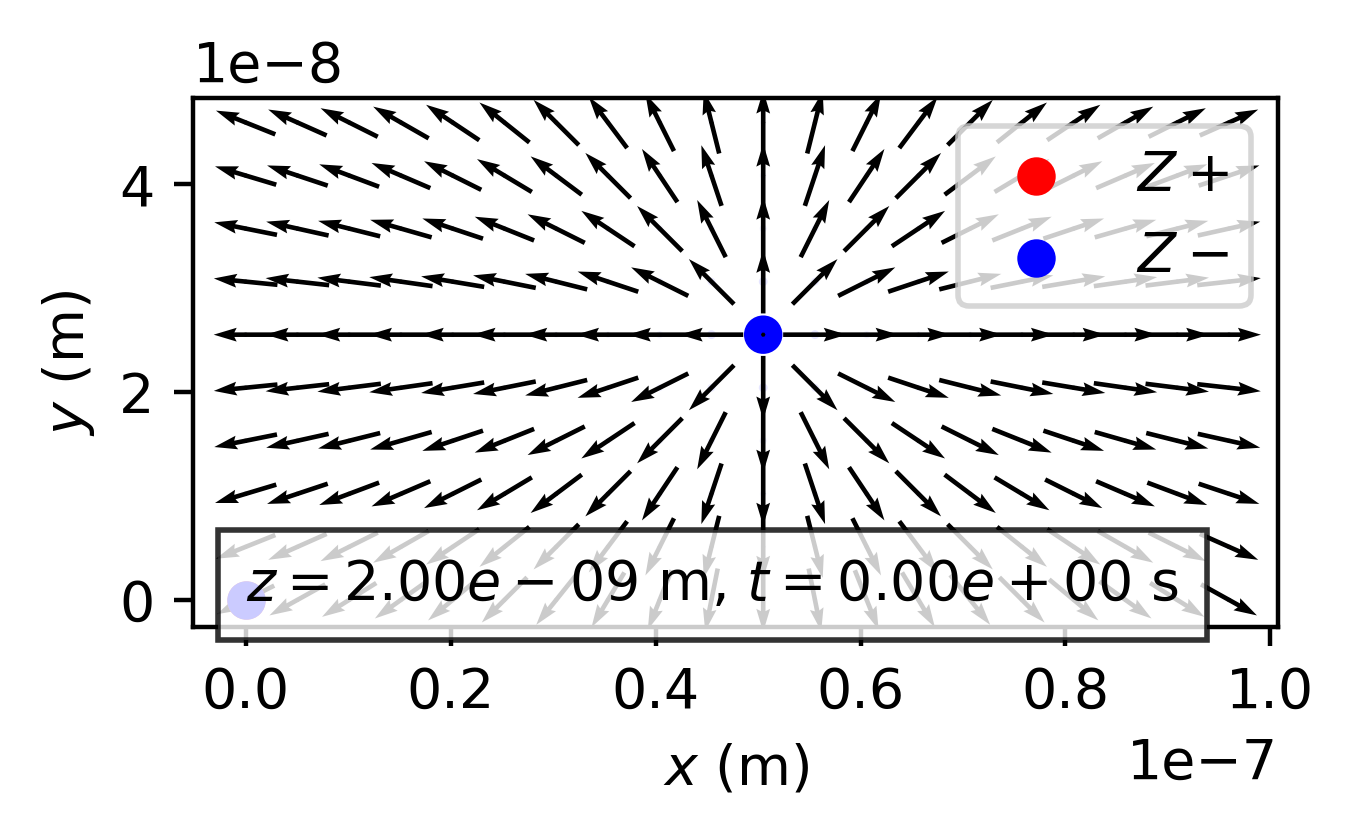

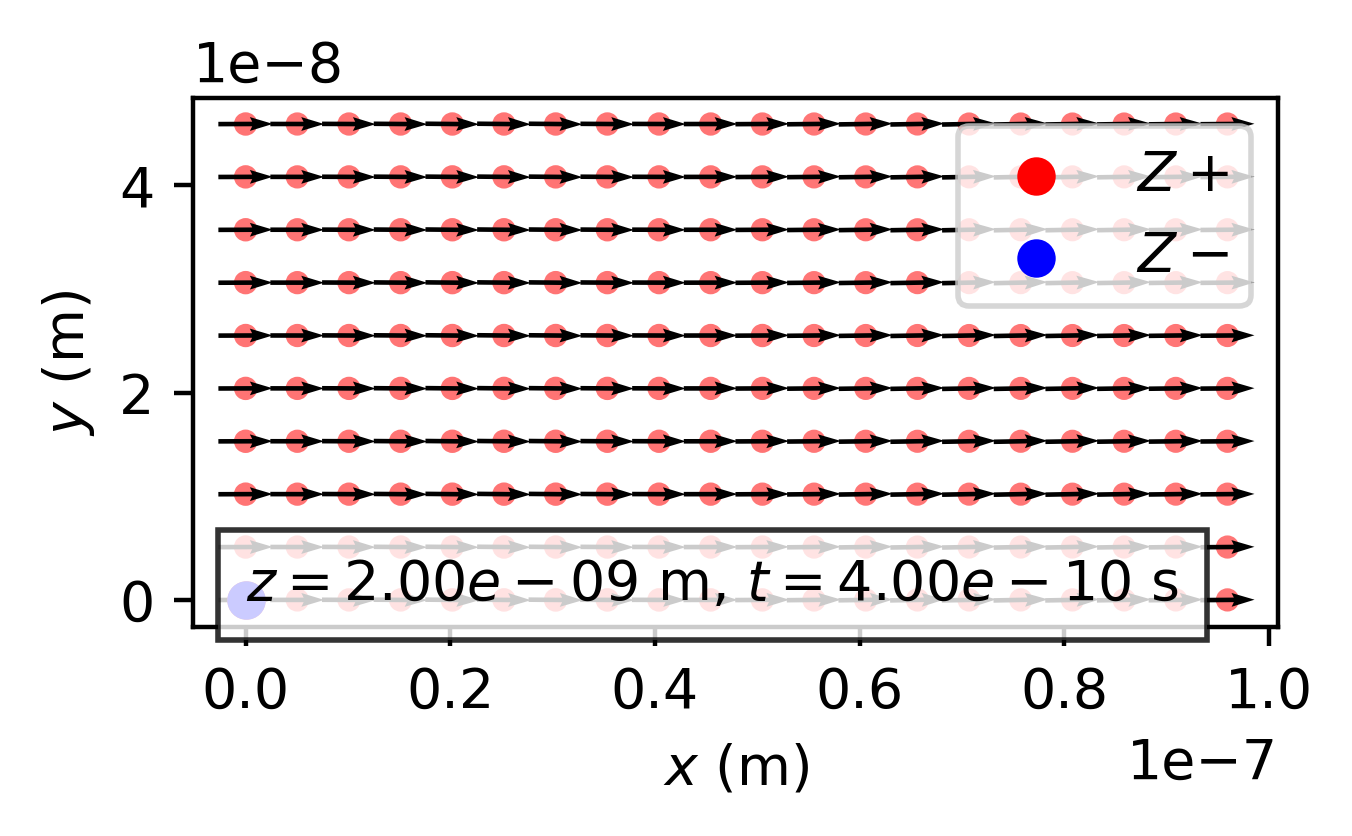

something


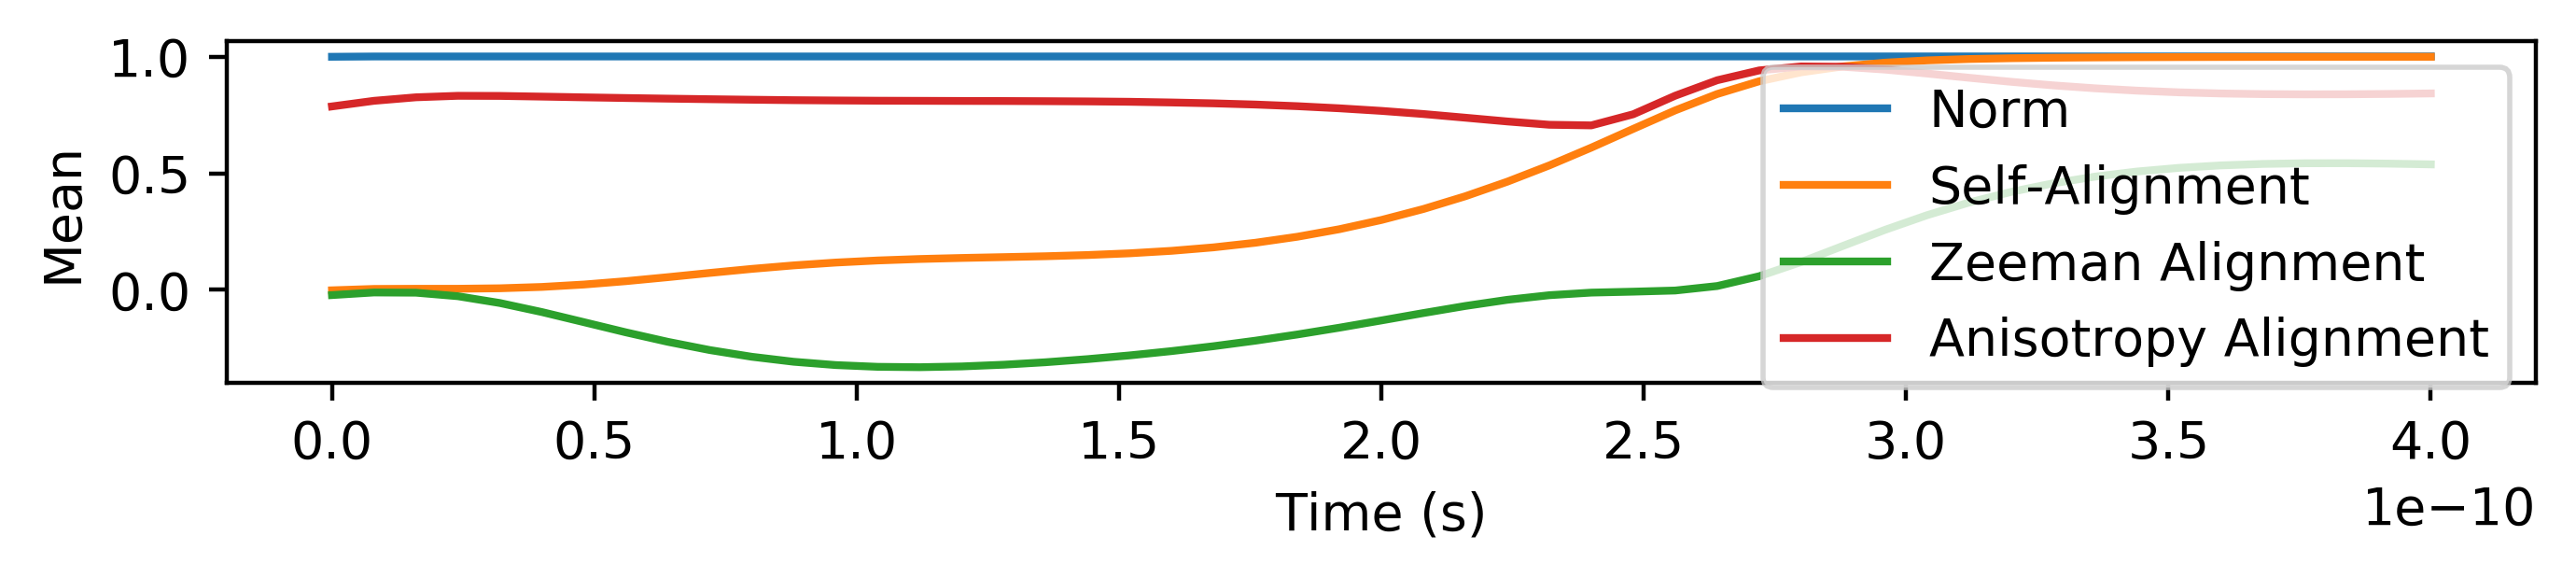

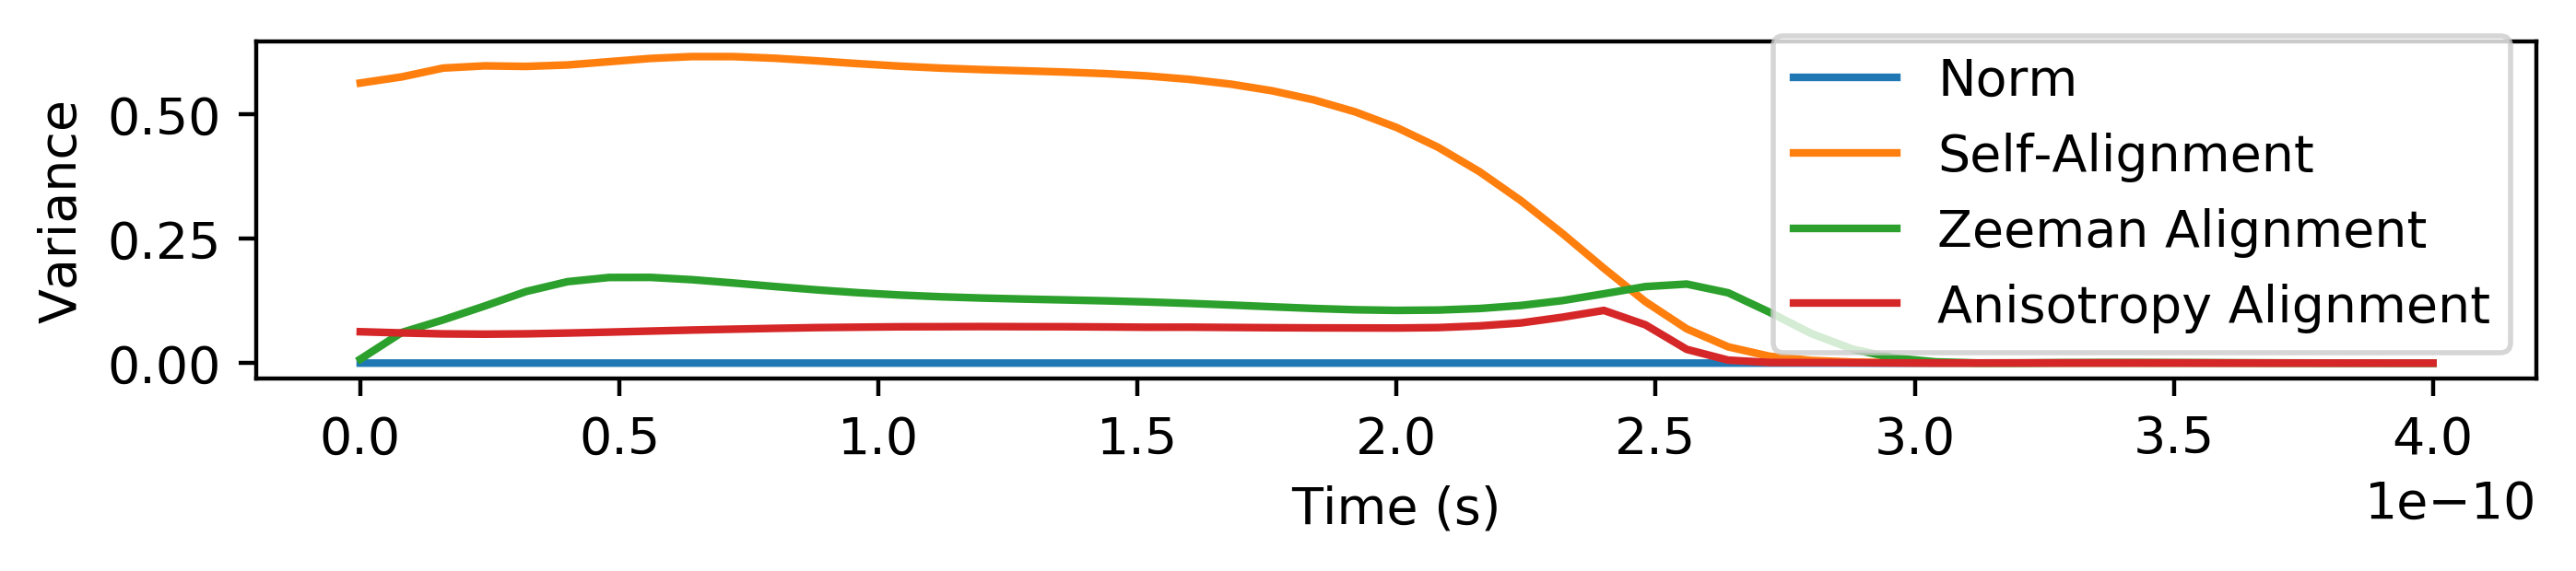

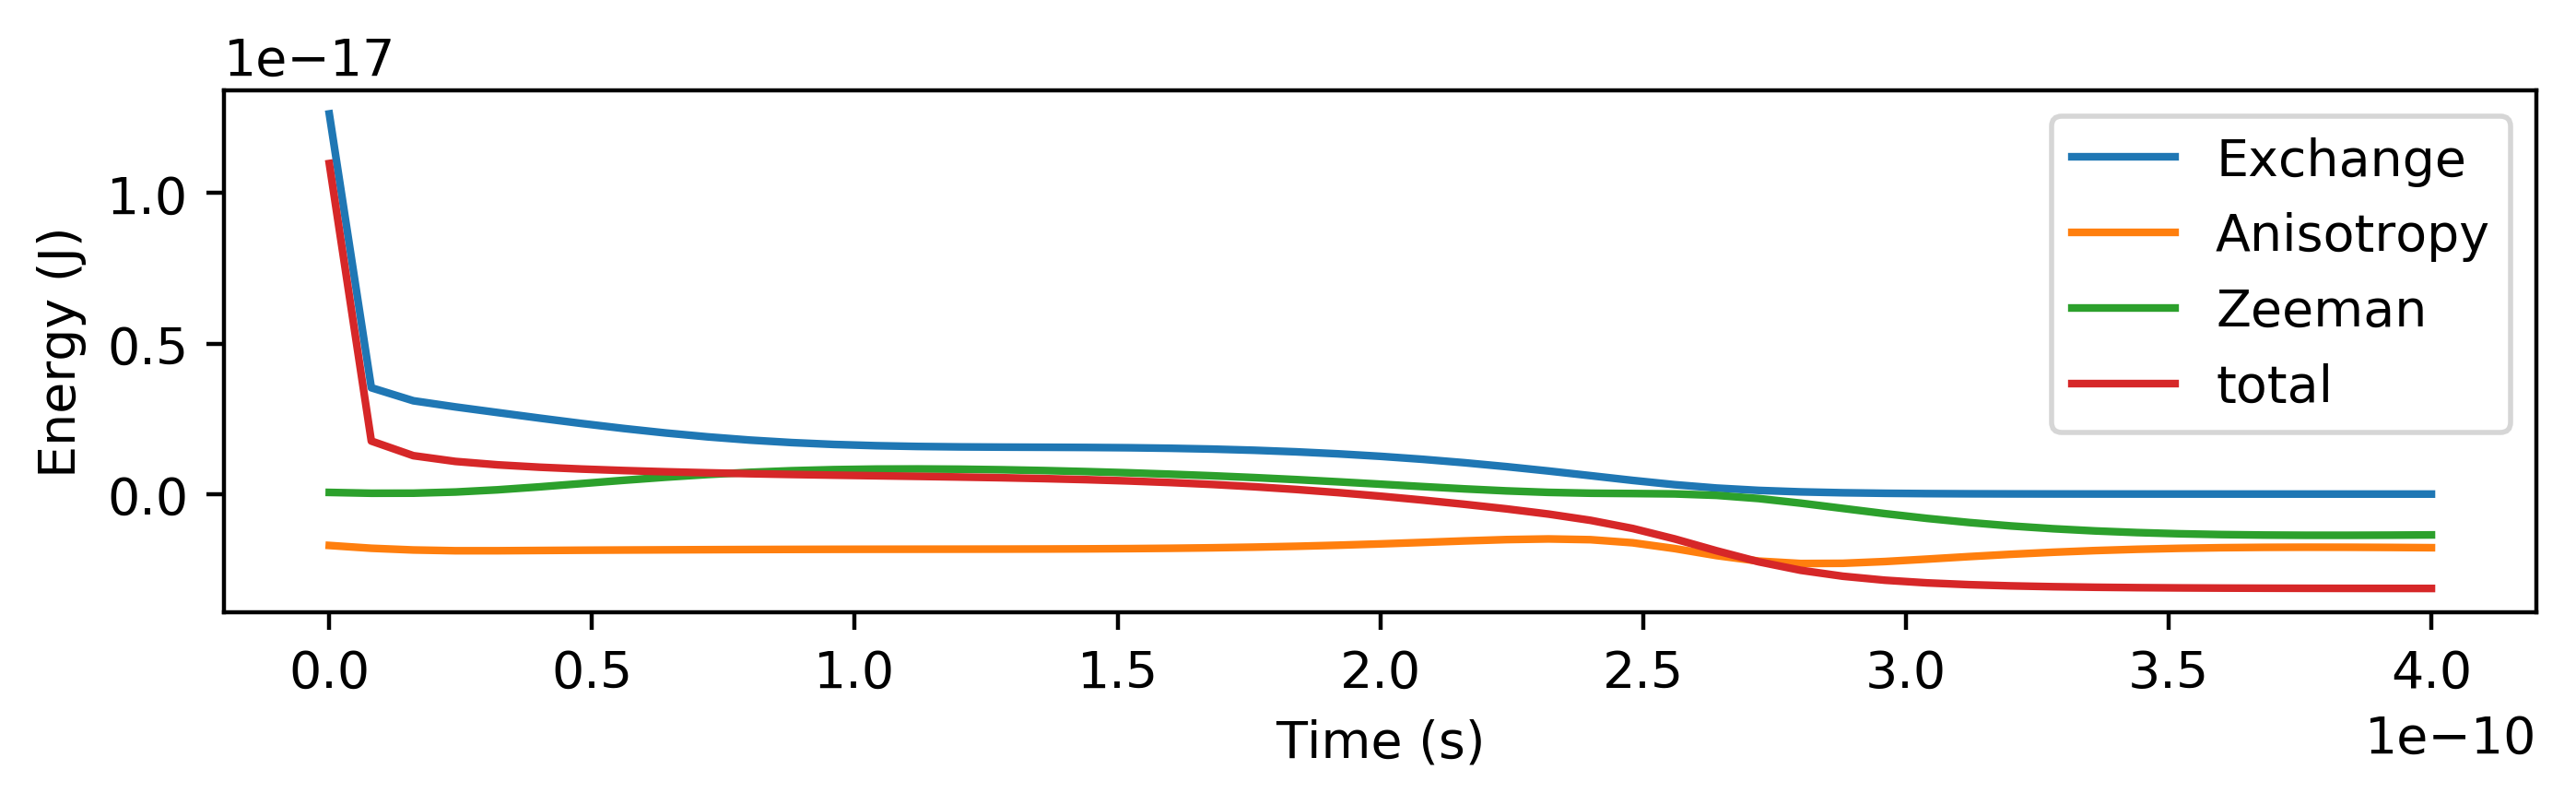

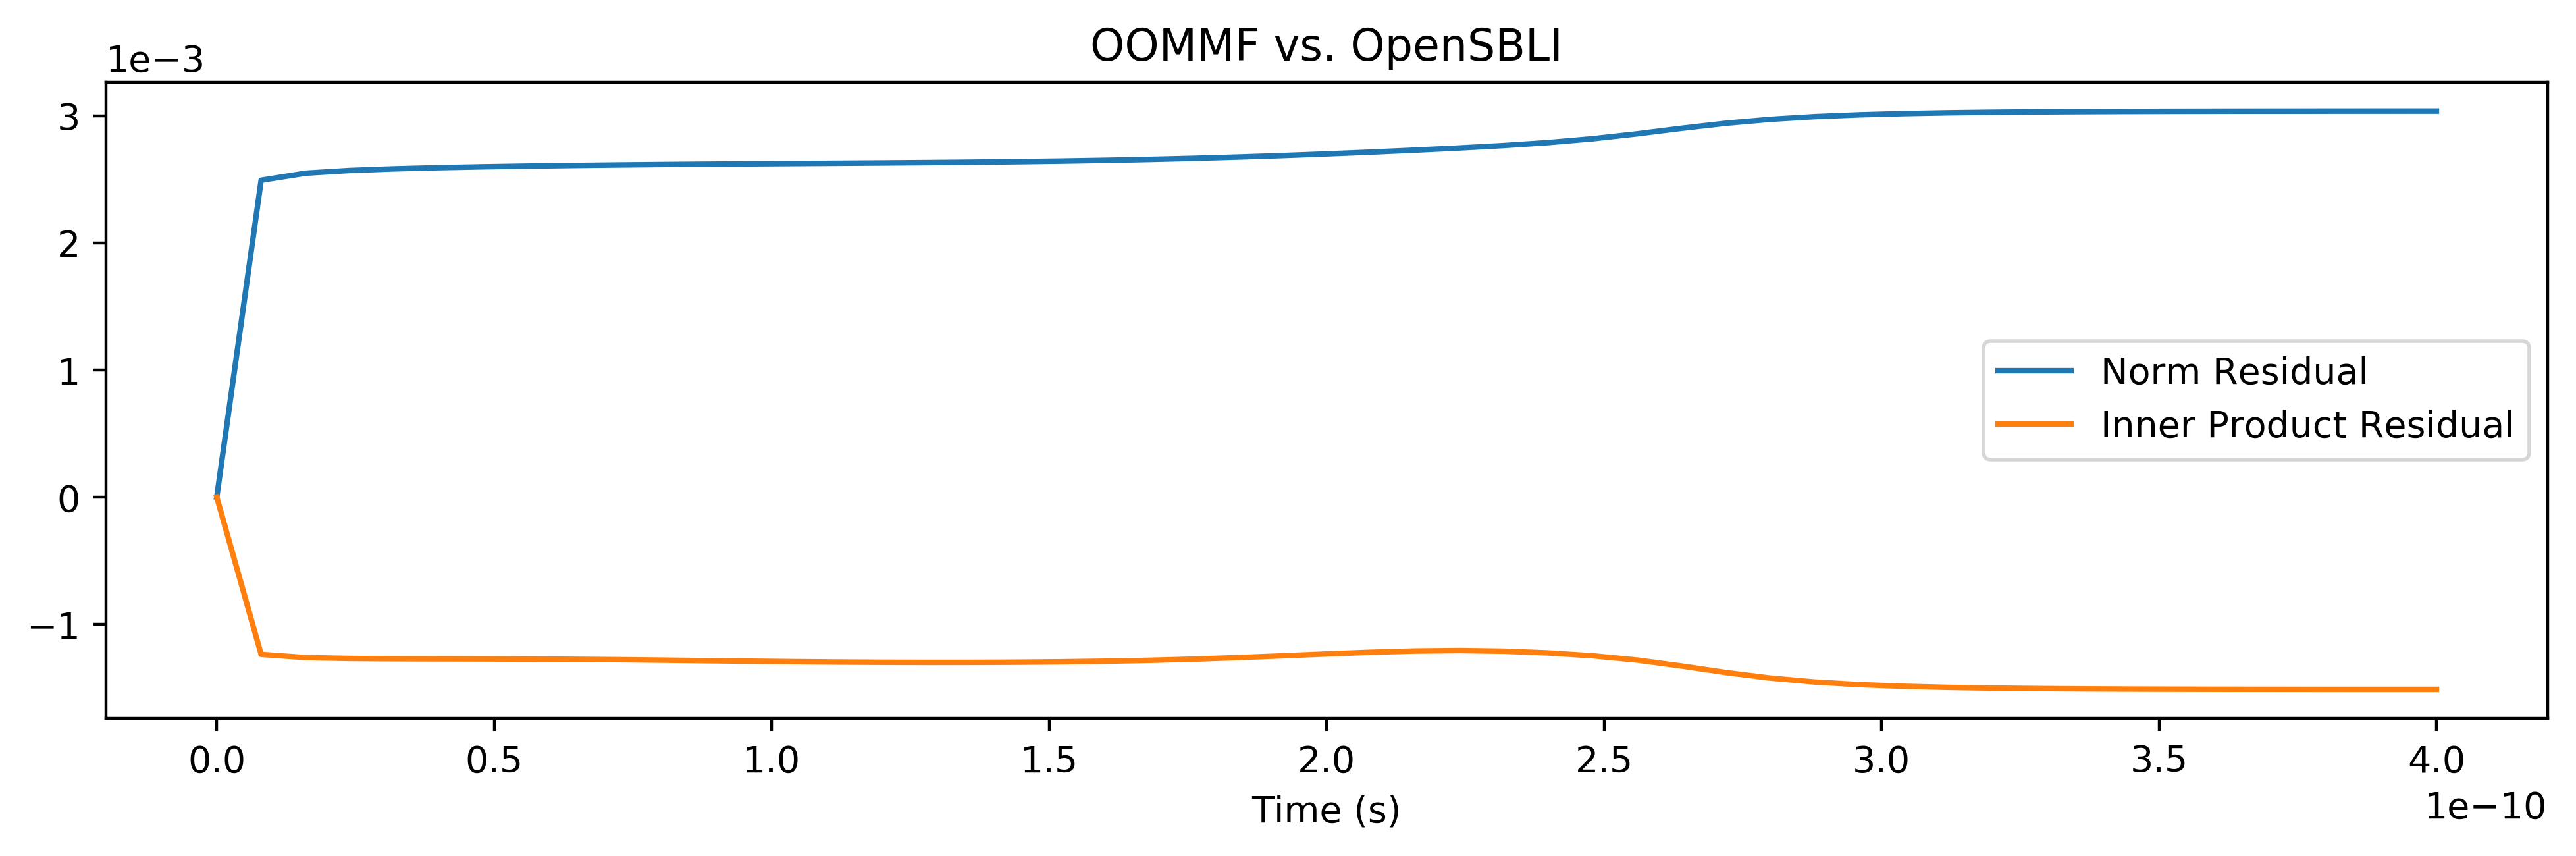

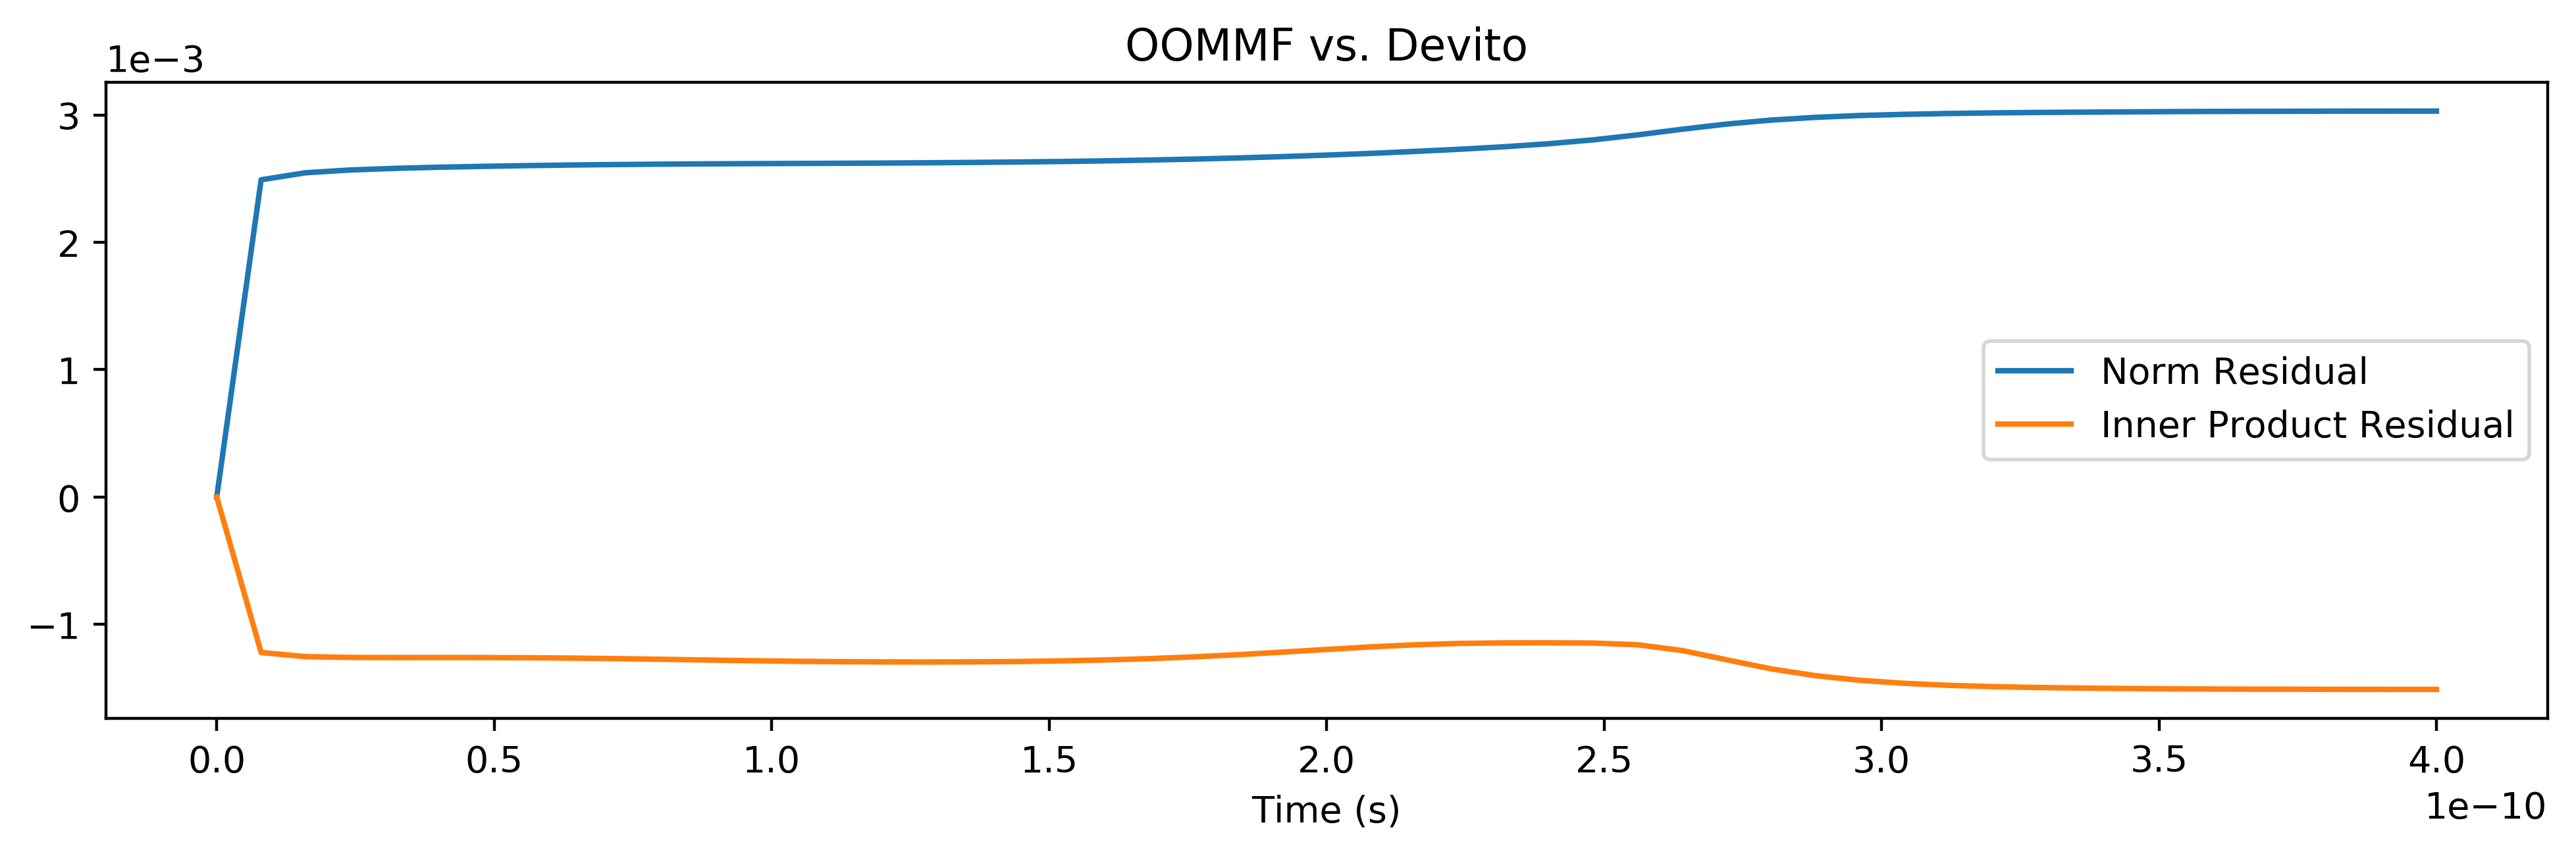

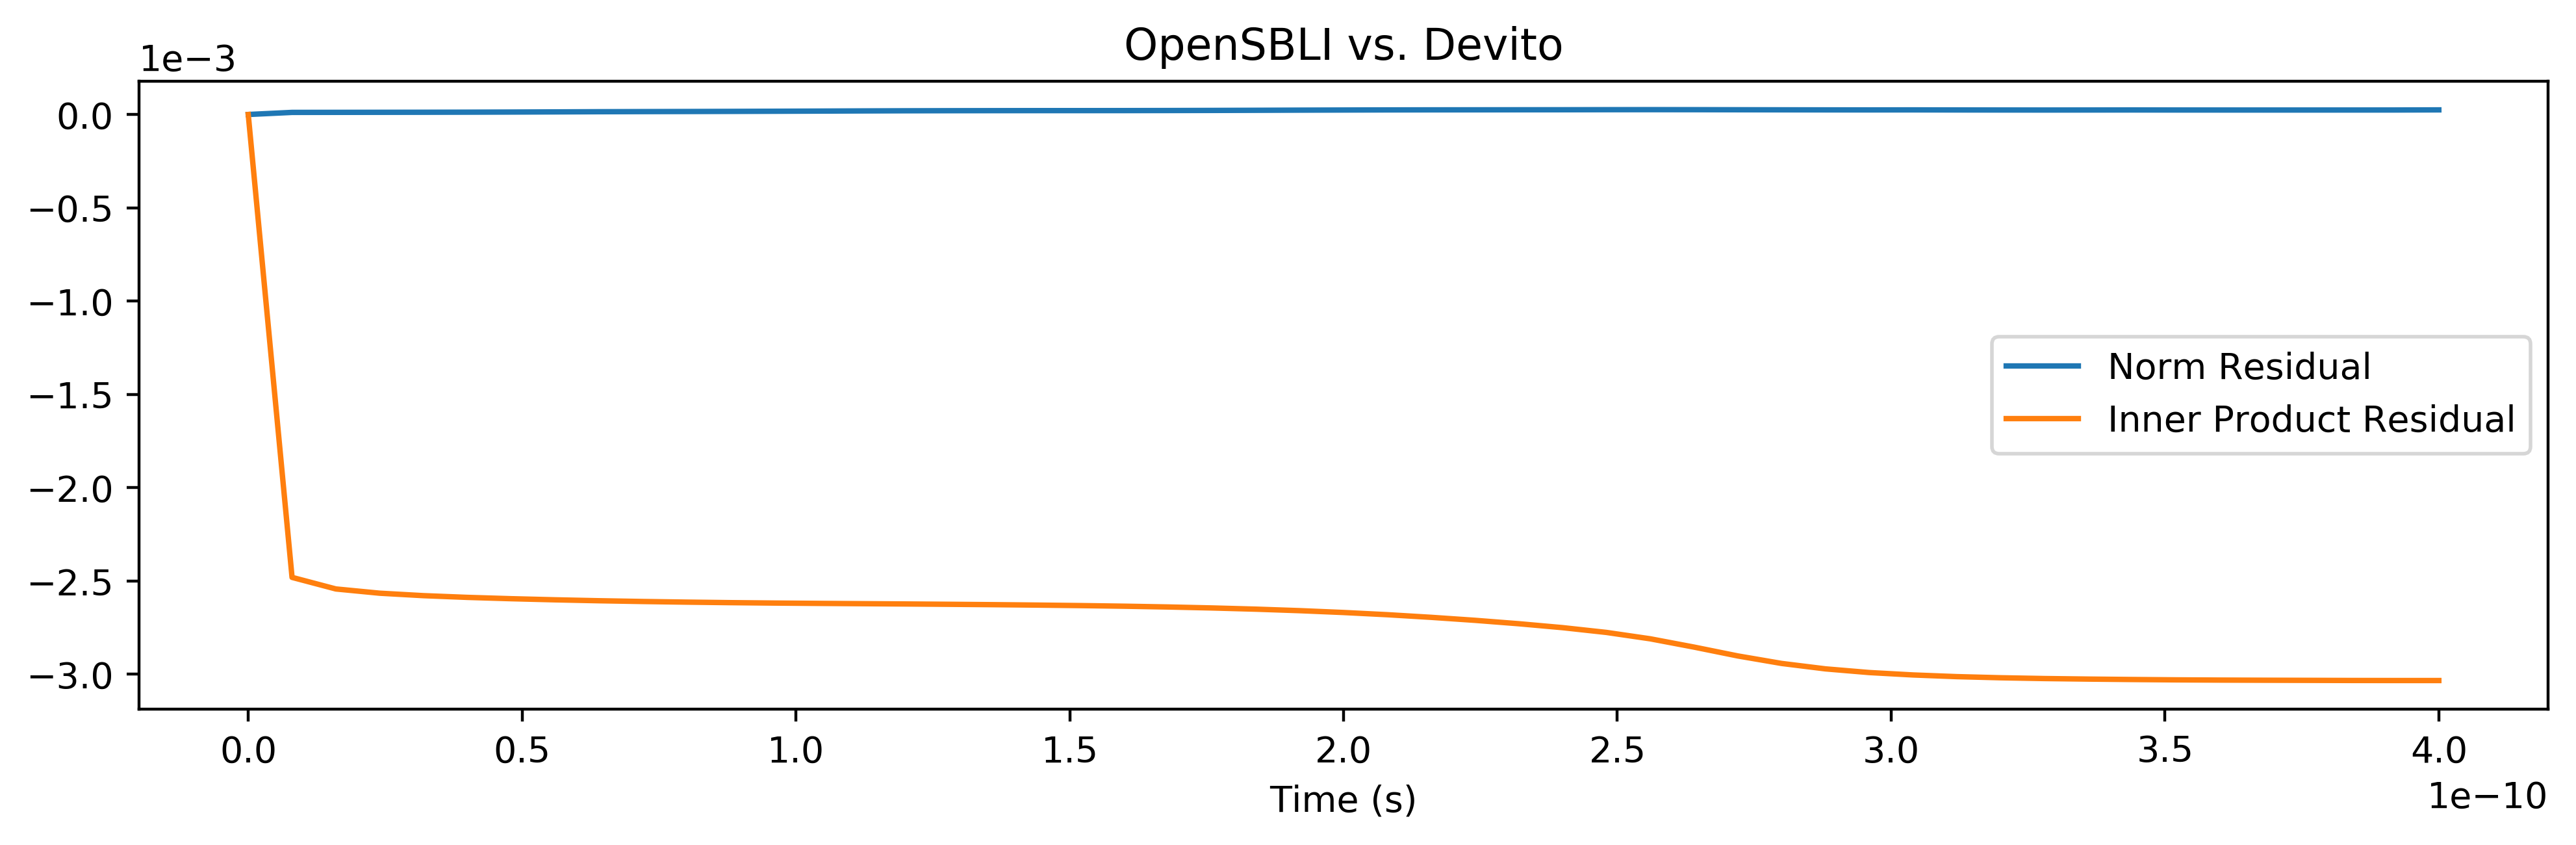

In [2]:
import os
import shutil

def fix_filename(name):
    return name.replace(",", "").replace(".", "").replace(" ", "_")

path = "testing_{}".format(steps)

shutil.rmtree(path, ignore_errors=True)
os.mkdir(path)

comparisons = {}
for pars, sims in completed_sims.items():
    for sim in sims:
        print(sim.framework_name, file=sys.stderr)
        filename = fix_filename('{}/{}_{}'.format(path, sim.framework_name, pars))
        print(filename, file=sys.stderr)
        sim.plot(0, 2, image_width=3.5, filename=(filename + "_start.png"))
        sim.plot(-1, 2, image_width=3.5, filename=(filename + "_end.png"))
        sim.plot_evolution(figsize=(7, 3), filename=(filename + '_evolution.png'))
        sim.plot_energy(figsize=(7, 2), filename=(filename + '_energy.png'))
        if sim.framework_name == "OOMMF":
            sim.plot_evolution(figsize=(7, 3), test_names={"Norm"}, filename=(filename + '_norm_evolution.png'))
        
    for i in range(len(sims) - 1):
        for j in range(i + 1, len(sims)):
            name = sims[i].framework_name + " vs. " + sims[j].framework_name
            if not name in comparisons:
                comparisons[name] = {}
            _, comparisons[name][pars] = sims[i].compare(sims[j])

testing_40000/OOMMF_vs_OpenSBLI_Norm_Residual.png


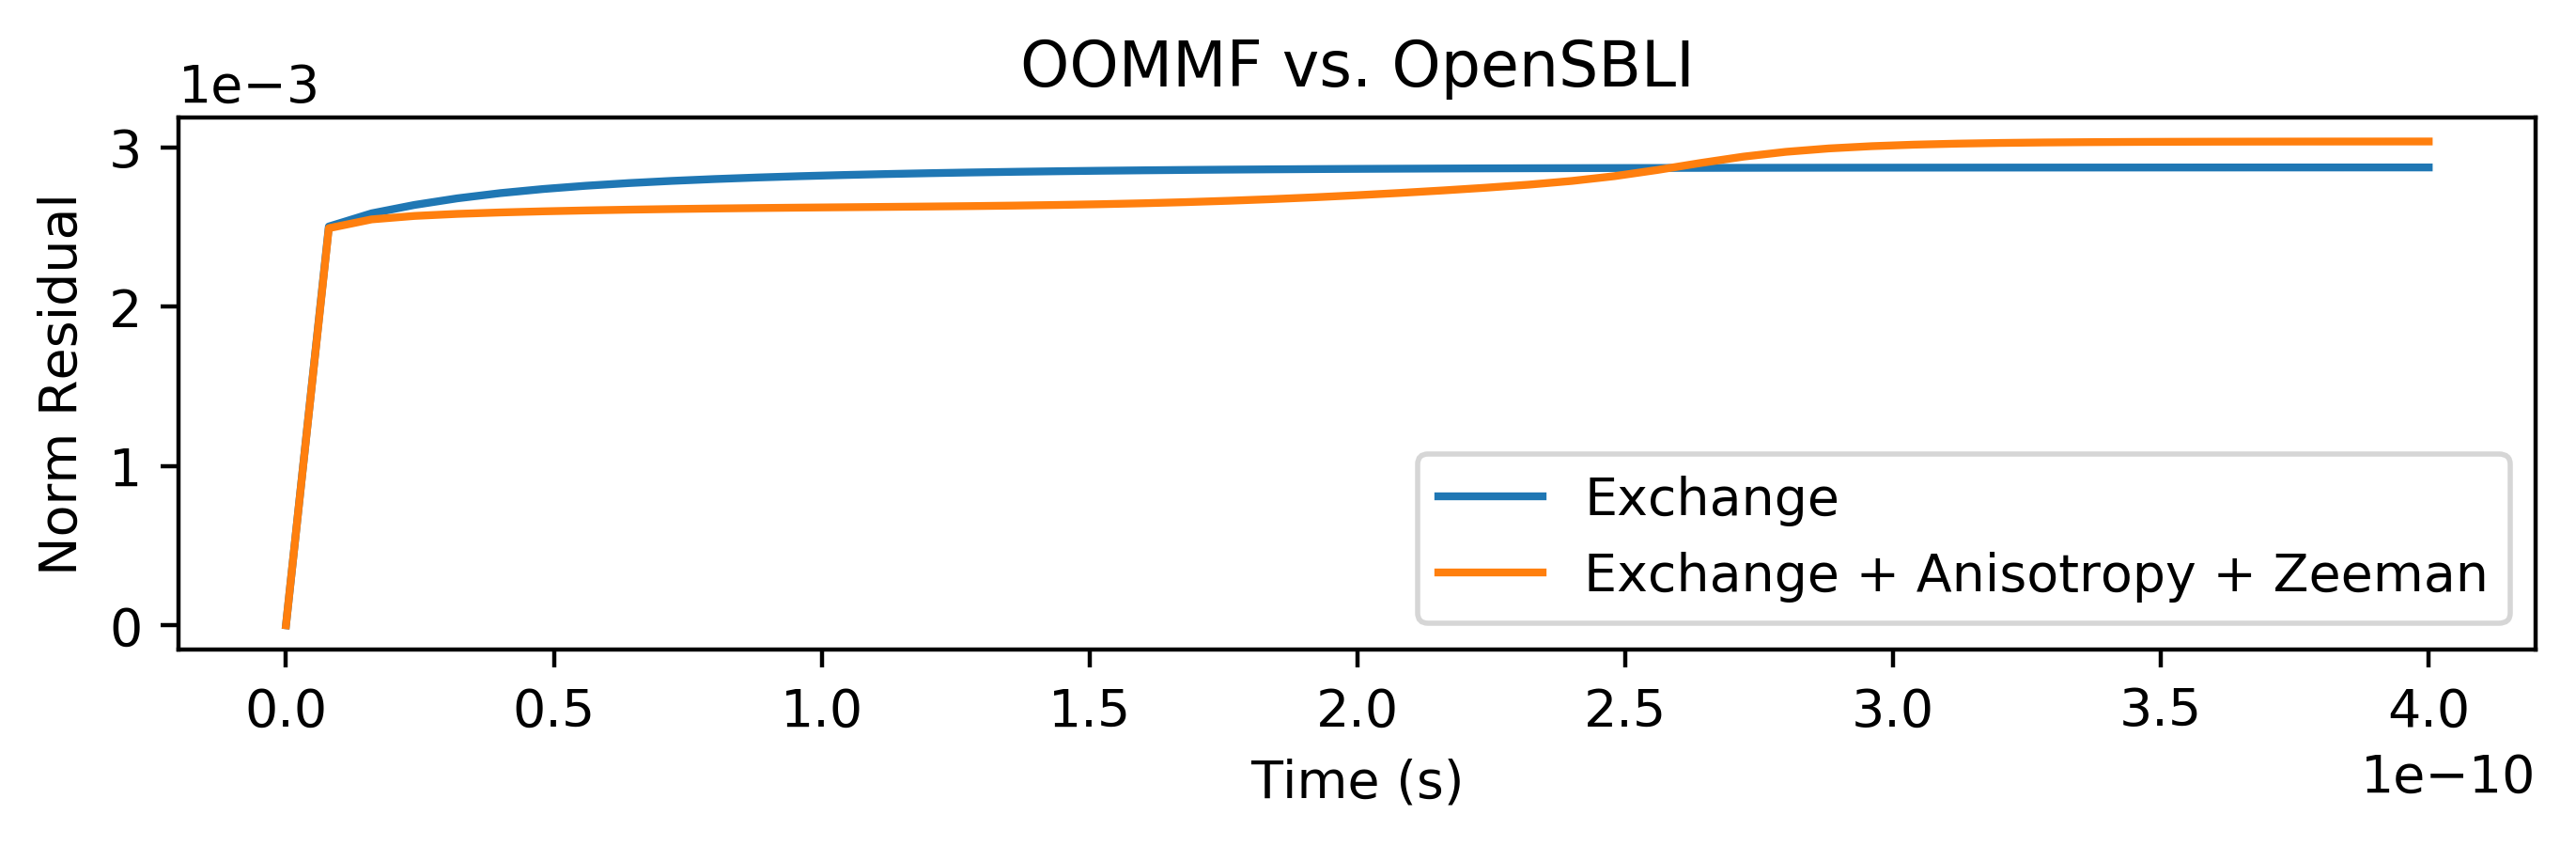

testing_40000/OOMMF_vs_OpenSBLI_Inner_Product_Residual.png


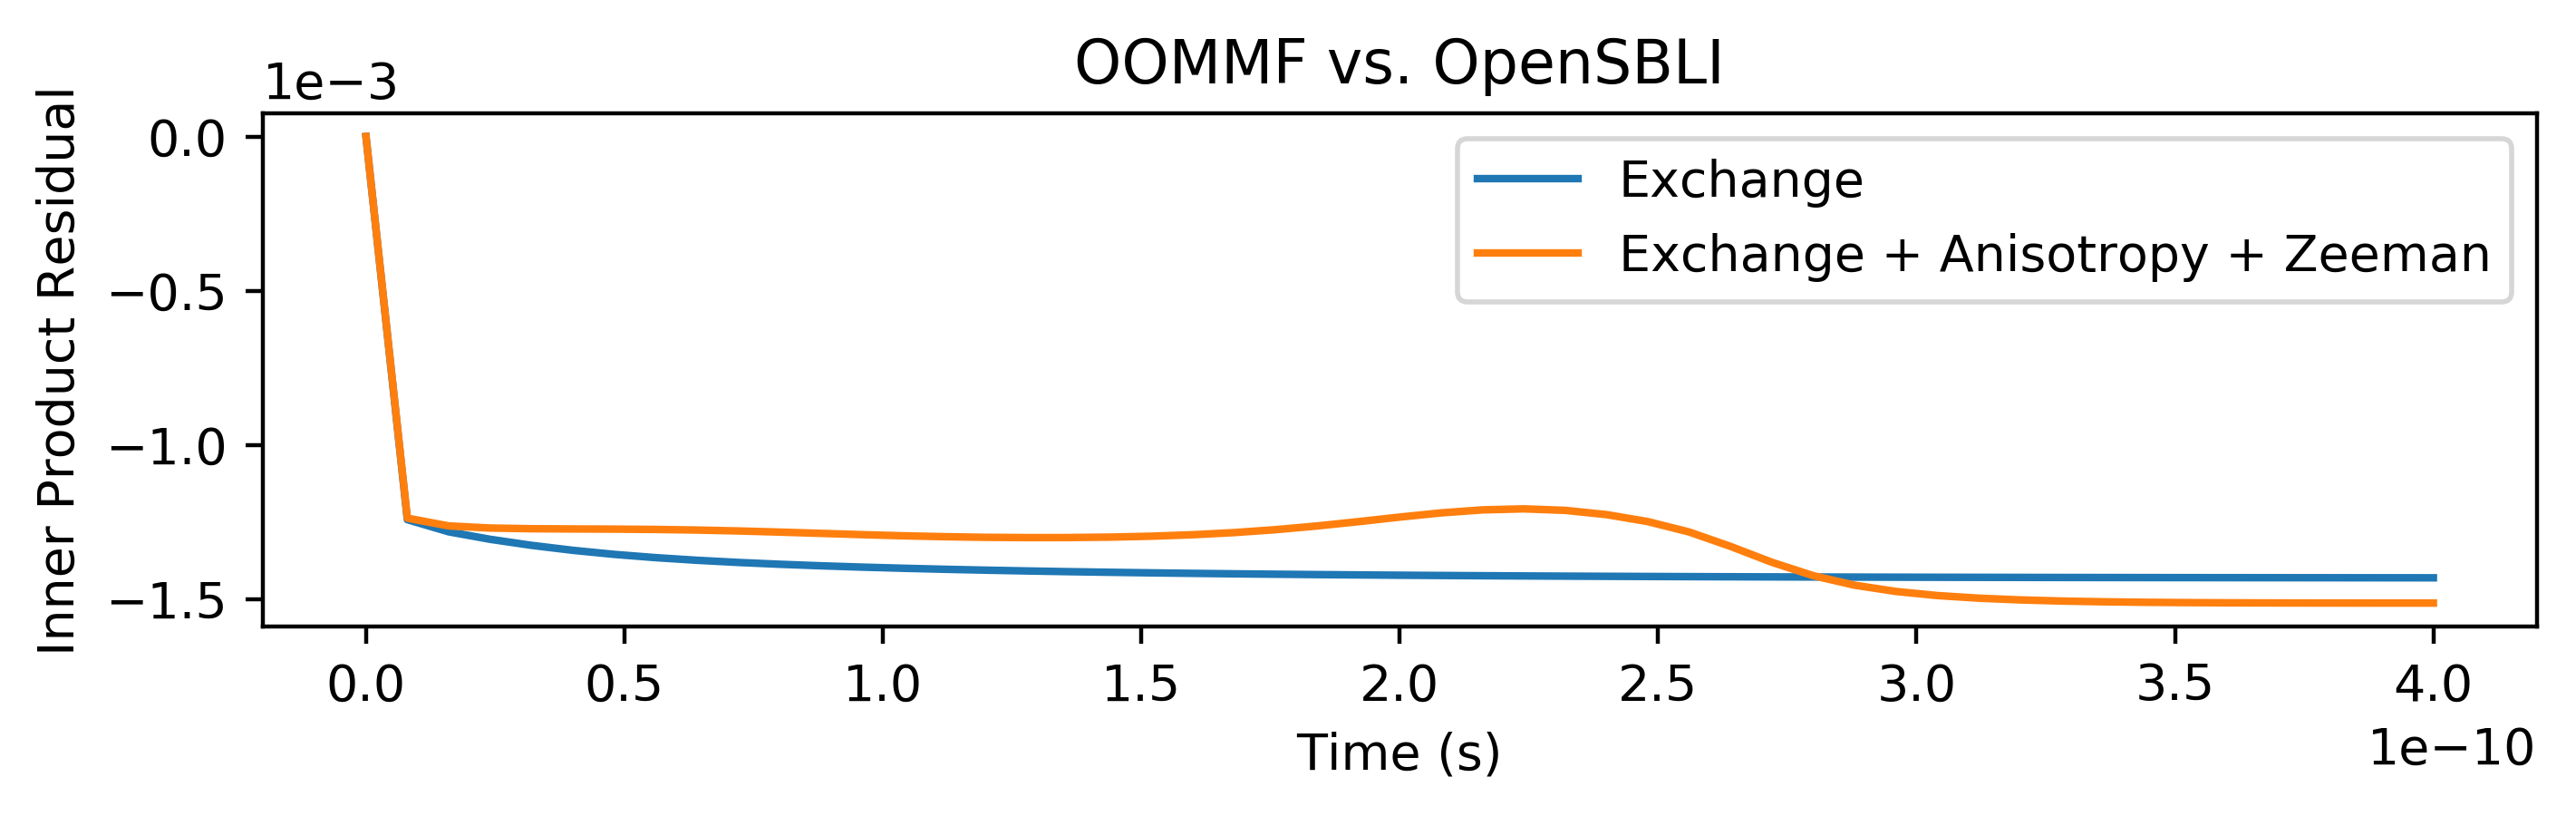

testing_40000/OOMMF_vs_Devito_Norm_Residual.png


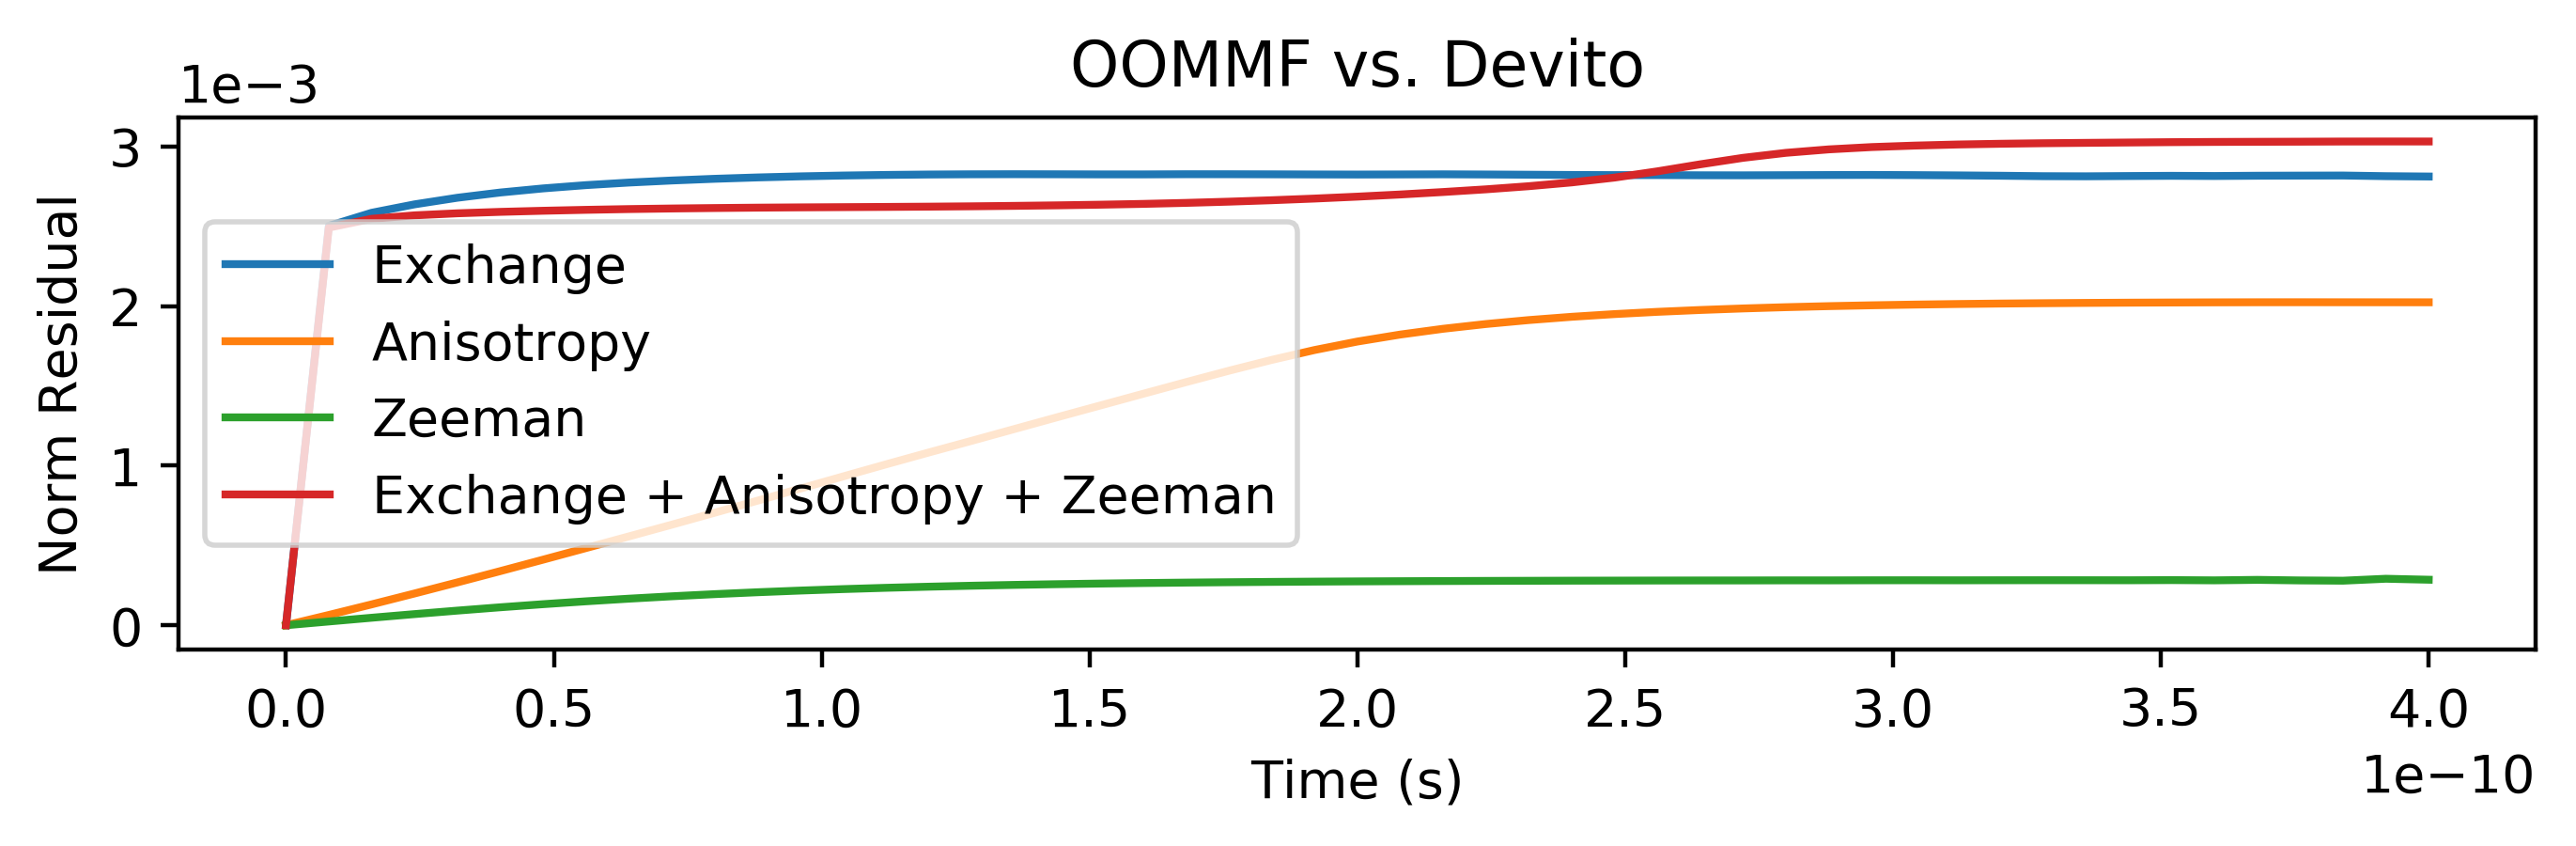

testing_40000/OOMMF_vs_Devito_Inner_Product_Residual.png


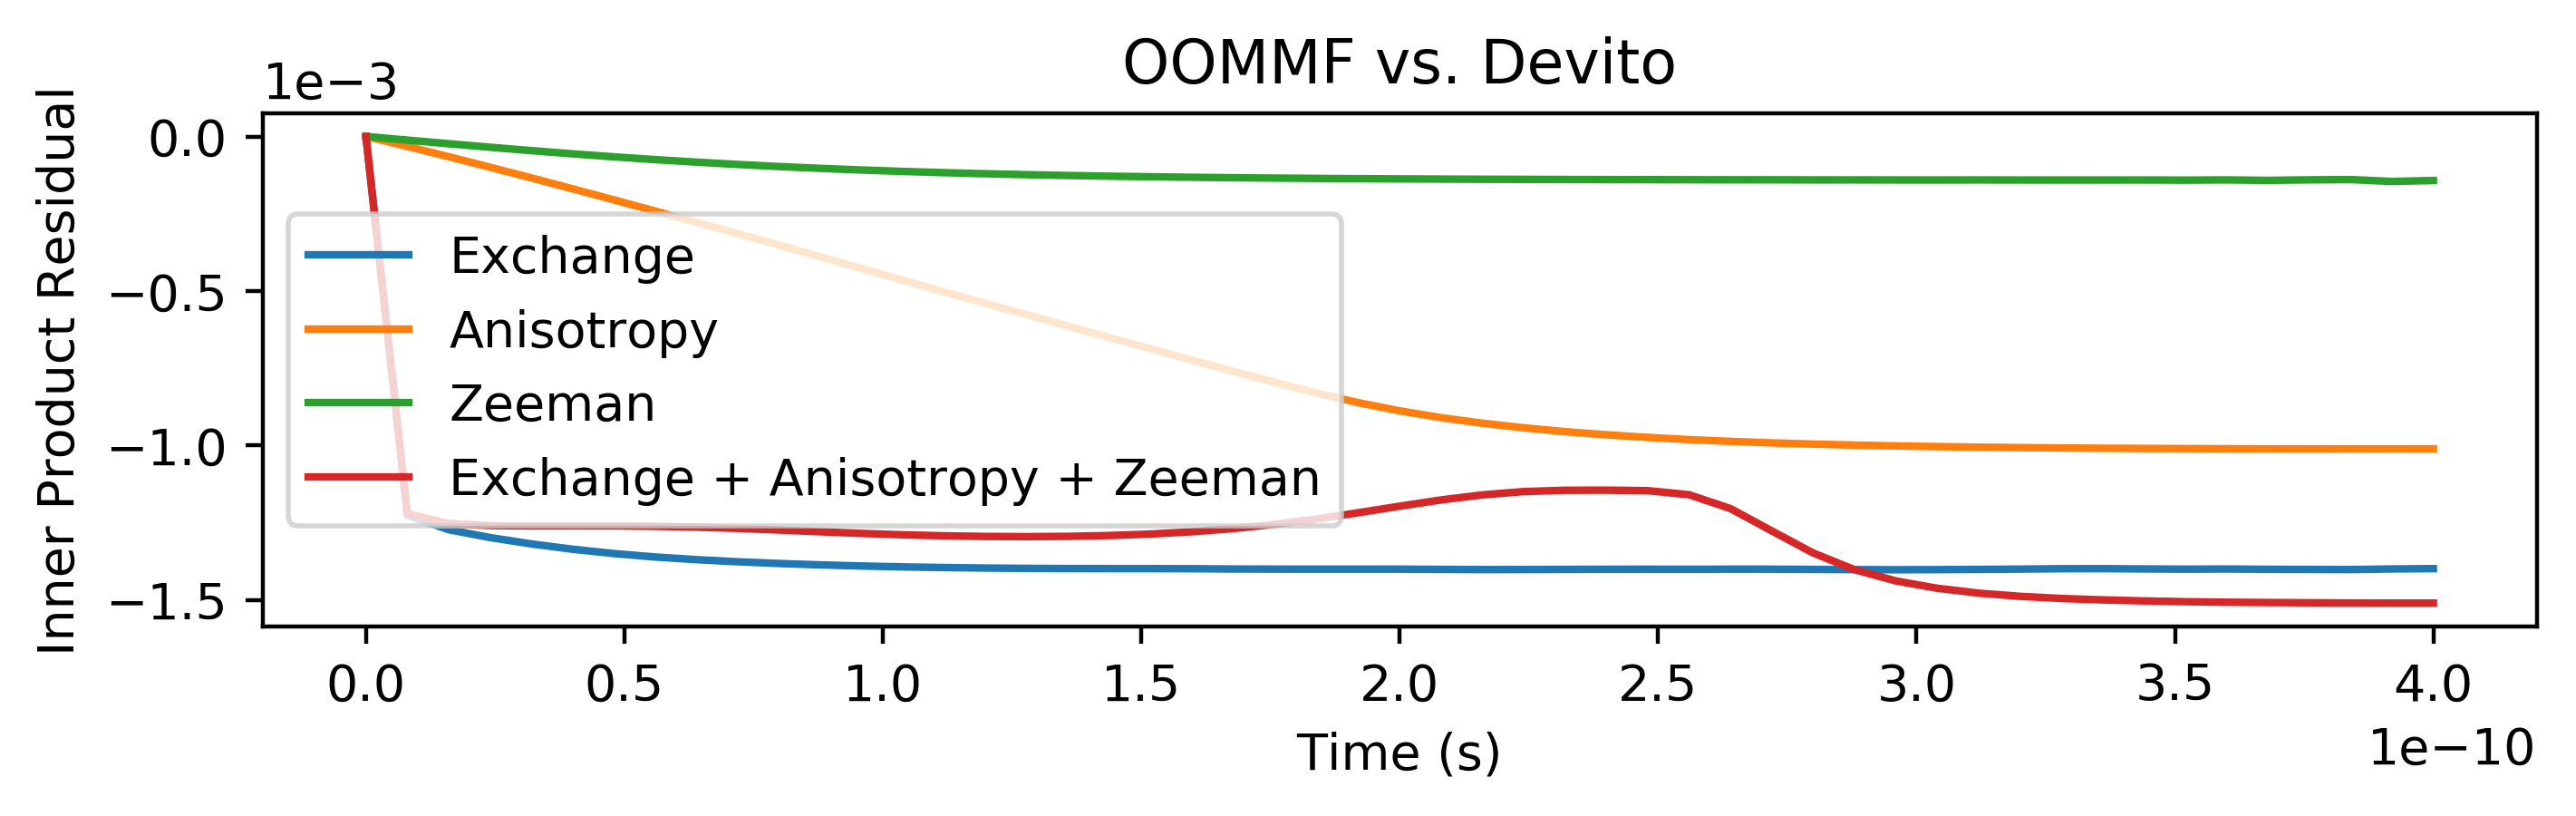

testing_40000/OpenSBLI_vs_Devito_Norm_Residual.png


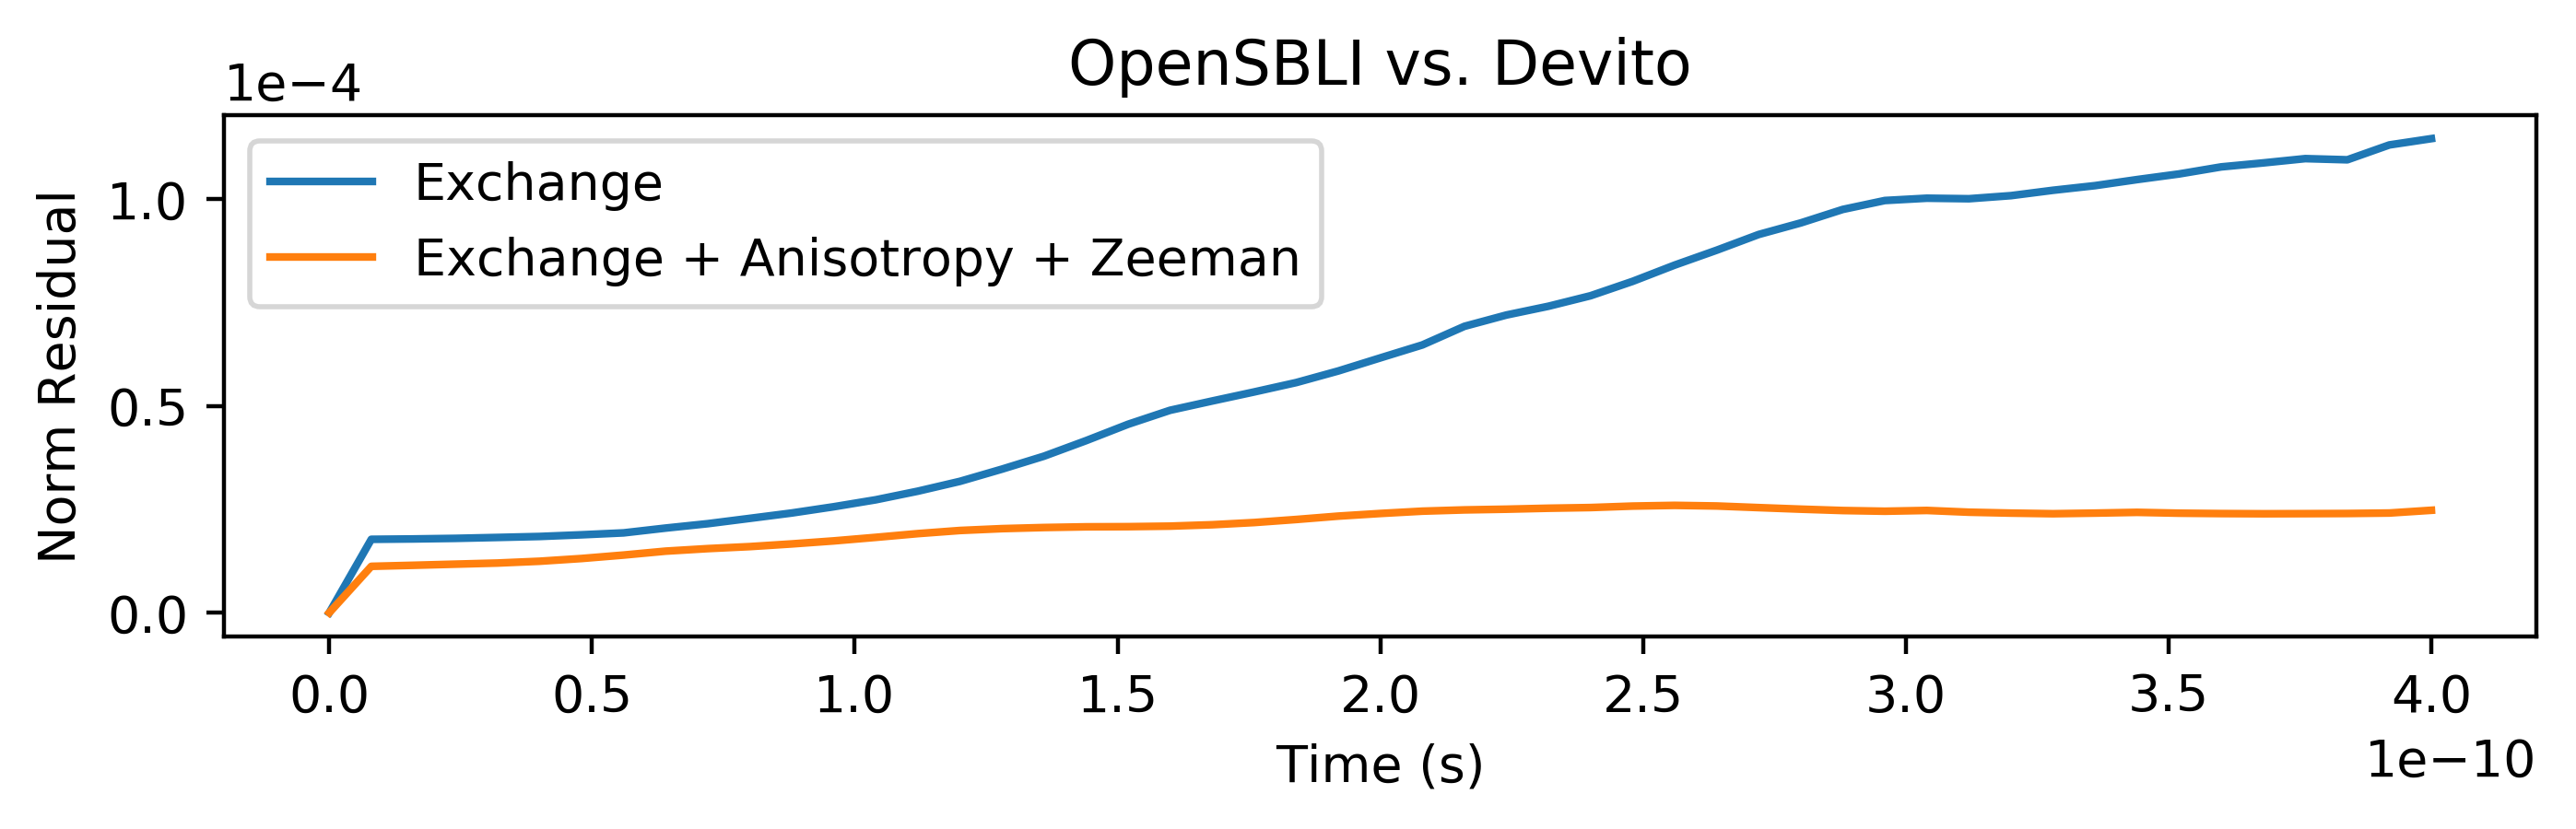

testing_40000/OpenSBLI_vs_Devito_Inner_Product_Residual.png


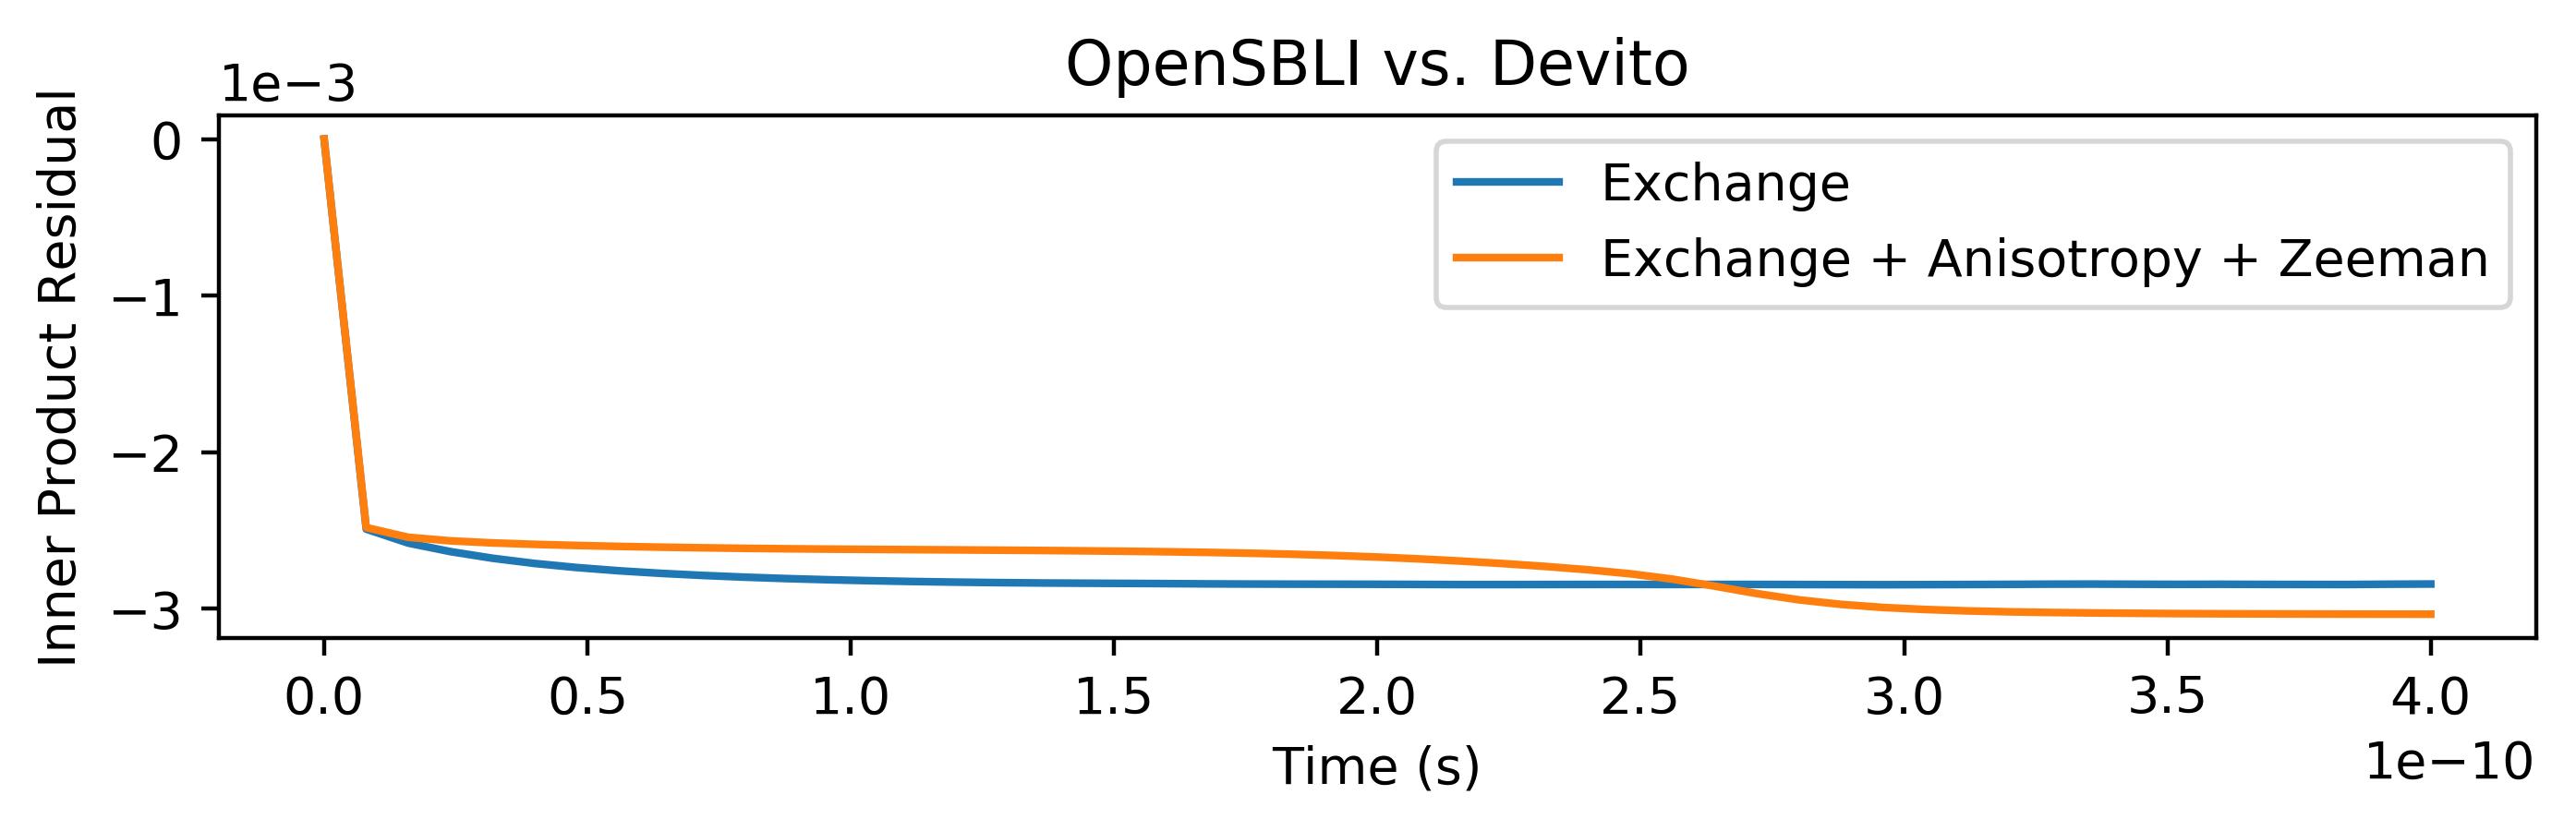

In [3]:
import numpy as np
import matplotlib.pyplot as plt

steps_list = np.arange(frames + 1) * save_every * time_params.d
figsize = (7,2)

for pn, p in comparisons.items():
    norm_lines = {}
    inner_lines = {}
    for vn, v in p.items():
        norm_lines[vn] = v['Norm Residual']
        inner_lines[vn] = v['Inner Product Residual']
    
    wrapper_pkg.DataPlot(steps_list, norm_lines, {"xlabel":r"Time (s)", "ylabel":"Norm Residual", "title":pn}, figsize=figsize)
    filename = fix_filename('{}/{}_{}'.format(path, pn, "Norm Residual")) + '.png'
    print(filename, file=sys.stderr)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    wrapper_pkg.DataPlot(steps_list, inner_lines, {"xlabel":r"Time (s)", "ylabel":"Inner Product Residual", "title":pn}, figsize=figsize)
    filename = fix_filename('{}/{}_{}'.format(path, pn, "Inner Product Residual")) + '.png'
    print(filename, file=sys.stderr)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()